## Edge participation predicts anatomical and functional features in the MICrONS data

This notebook demonstrates that the topological parameter of "edge participation" predicts plasticity-related structural and functional features in the MICrONS mm^3 EM reconstruction.

First imports and data loading.

In [1]:
import numpy
import pandas

# For plotting the results
from matplotlib import pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
numpy.seterr(all="ignore")

import conntility  # pip install Connectome_Utilities
import connalysis  # obtain from github.com/danielaegassan/connectome_analysis/

from conntility import analysis

# Main dataset. Collected MICrONS data.
# https://zenodo.org/records/8364070
fn = '/scratch/datasets/microns_reimann/microns_mm3_connectome.h5'

# Create ConnectivityMatrix object for the analysis
M = conntility.ConnectivityMatrix.from_h5(fn, "condensed")
M.add_vertex_property("gid", M.gids)
# A version of the ConnectivityMatrix with non-reciprocal edges removed
RC = M.to_reciprocal()



### Analysis parameters

In [2]:
INHs = ["BC", "MC", "NGC"]
PCs = ["23P", "4P", "6CT", "5P_IT", "5P_PT", "5P_NP", "6IT"]
min_neighborhood_sz = 100

center_x = [700000, 1200000]
center_z = [700000, 1000000]

max_dim = 6

### Neighborhoods instead of assemblies
We found in morphologically detailed simulations of a calcium-based model of synaptic plasticity that a high value of "edge participation", especially in high dimensions, predicts an edge undergoing plasticicty. The strength of this effect was enhanced when edge participation in the subgraph on the nodes of a functional assembly (neurons firing together) was considered.

In the MICrONS data we can only possibly calculate assemblies on a very, very sparse subset of neurons that have functional data available. Not enough for a thorough analysis of this trend. 
Therefore, here we instead consider individual neuron "neighborhoods", i.e. all neurons connected to a given neuron. This may be loosely comparable for the following reasons: Neurons in a neighborhood are more strongly connected to each other than expected by chance. This makes it more likely that they participate in the same assembly.

In [3]:
# Get a dataframe listing for each node the node ids of its neighborhood.
# Note that this does _not_ include the center node itself and therefore also does not include the edges from the center node to its neighborhood.
I = analysis.neighborhood_indices(M.matrix)

# To minimize possible edge effects, we limit to neighborhoods where the center node is inside a rectangle central to the reconstructed volume
is_central = (M.vertices["x_nm"] > center_x[0]) & (M.vertices["x_nm"] < center_x[1]) & (M.vertices["z_nm"] > center_z[0]) & (M.vertices["z_nm"] < center_z[1])
I = I[is_central]
# We only consider the excitatory neighborhood.
I = I.apply(lambda x: x[M.vertices.iloc[x]["cell_type"].isin(PCs)])

# Finally, we want the neighborhood to be of sufficient size.
degree = I.apply(len)
I = I[degree >= min_neighborhood_sz]

Some utility functions to estimate distance-dependent connection probabilities and compare observed results to a reference.

In [4]:
from scipy import stats
from scipy.stats import binom

dbins = numpy.linspace(1.0, 1000.0, 41)
dbins = numpy.hstack([dbins, 10000.0])

def michaelson(a, b):
    return (a - b) / (a + b)

def connected_distances(mat, edge_filters={}):
    for _fltr_spec, _fltr_vals in edge_filters.items():
        mat = mat.filter(*_fltr_spec).isin(_fltr_vals)
    deltas = [mat.edge_associated_vertex_properties(_prop).diff(axis=1)["col"]
              for _prop in ["x_nm", "y_nm", "z_nm"]]
    D = numpy.sqrt((pandas.concat(deltas, axis=1) ** 2).sum(axis=1)) / 1000
    W = mat.edges[mat._default_edge]
    return D, W

def all_distances(mat, vertex_filters={}, nsample=2000000):
    val_pre = numpy.ones(len(mat), dtype=bool)
    val_post = numpy.ones(len(mat), dtype=bool)
    for _fltr_spec, _fltr_vals in vertex_filters.items():
        _fltr_col, _fltr_side = _fltr_spec
        if _fltr_side == "col":
            val_post = val_post & mat.vertices[_fltr_col].isin(_fltr_vals)
        elif _fltr_side == "row":
            val_pre = val_pre & mat.vertices[_fltr_col].isin(_fltr_vals)
    pop_pre = mat.gids[val_pre]
    pop_post = mat.gids[val_post]
    npairs = len(pop_pre) * len(pop_post) - len(numpy.intersect1d(pop_pre, pop_post))
    f = npairs / nsample
    rnd1 = numpy.random.choice(pop_pre, nsample)
    rnd2 = numpy.random.choice(pop_post, nsample)

    delta = mat._vertex_properties[["x_nm", "y_nm", "z_nm"]].loc[rnd1].values - mat._vertex_properties[["x_nm", "y_nm", "z_nm"]].loc[rnd2].values
    D = numpy.sqrt(numpy.sum(delta ** 2, axis=1)) / 1000
    return D, f

def distance_dependent_con_prob(mat, fltr_spec={}, include_weights=False, **kwargs):
    A, w = connected_distances(mat, fltr_spec)
    B, f = all_distances(mat, fltr_spec, **kwargs)
    if include_weights:
        Ah = numpy.histogram(A, bins=dbins, weights=w)[0]
    else:
        Ah = numpy.histogram(A, bins=dbins)[0]
    Bh = numpy.histogram(B, bins=dbins)[0] * f
    return Ah / Bh

def distance_dependent_zscores(mat, reference, fltr_spec={}, include_weights=False, **kwargs):
    A, w = connected_distances(mat, fltr_spec)
    B, f = all_distances(mat, fltr_spec, **kwargs)
    if include_weights:
        Ah = numpy.histogram(A, bins=dbins, weights=w)[0]
    else:
        Ah = numpy.histogram(A, bins=dbins)[0]
    Bh = numpy.histogram(B, bins=dbins)[0] * f
    
    expected_mn = stats.binom(Bh.astype(int), reference).mean()
    overexpression_fac = michaelson(Ah.sum(), expected_mn.sum())
    expected_sd = stats.binom(Bh.astype(int), reference).std()
    return {
        "overexpression_factor": overexpression_fac,
        "overexpression": michaelson(Ah, expected_mn),
        "pairs": Ah,
        "expected_mean": expected_mn,
        "expected_sd": expected_sd
    }

## Illustrating the analysis using a randomly picked example

### A. Connectivity in the neighborhood is higher than expected

0.37841975843914805


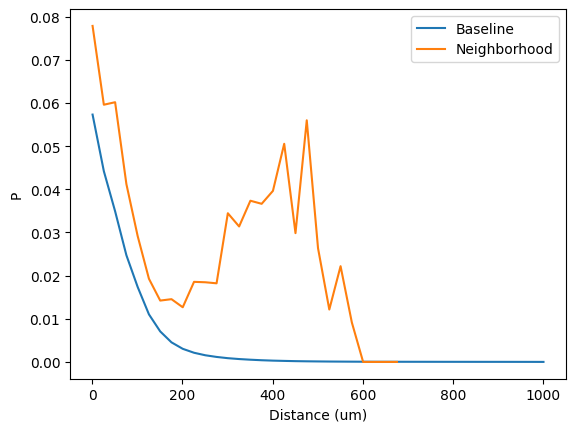

In [5]:
# Calculate the distance-dependent connection probability of PCs. Comparison to this probability
# will be used to demonstrate that connectivity in neighborhoods is higher than expected.
P_pc_pc = distance_dependent_con_prob(M, 
                                    {("cell_type", "row"): PCs, ("cell_type", "col"): PCs},
                                    include_weights=False)

# Look up neighborhood connectivity and calculate distance-dependent connectivity in the neighborhood
neighborhood = M.subpopulation(I.iloc[101])
P_neigh = distance_dependent_con_prob(neighborhood)

# Plot and compare distance-dependent connection probabilities.
plt.plot(dbins[:-1], P_pc_pc, label="Baseline")
plt.plot(dbins[:-1], P_neigh, label="Neighborhood")
plt.gca().set_xlabel("Distance (um)")
plt.gca().set_ylabel("P")
plt.legend()

# A measure of how much connectivity is stronger in the neighborhood than the reference. Specifically:
# The michaelson contrast between the number of edes in the neighborhood and the expected number of edges
# expected from the distance-dependent reference.
# That is: Values are within [-1, 1].
# < 0 indicates lower than expected connectivity; 0 as expected; > 0 stronger than expected.
print(distance_dependent_zscores(neighborhood, P_pc_pc)["overexpression_factor"])

### B. The total (=sum of) size of synapses in a connection is predicted by edge participation
The motivation is as follows: A high value of total size is an indicator of a structurally or functionally strong synaptic connection. That is, either it contains many individual synaptic contacts, or contacts that are individually strong. This in turn indicates that the connection is potentiated.

In [6]:
def add_edge_participation(neighborhood, max_dim=5):
    """
    add_edge_participation: Add edge participation in various dimensions as an edge property to a ConnectivityMatrix object.

    Args:
      neighborhood: A conntility.ConnectivityMatrix.
      max_dim (optional, default: 5): Highest dimension to consider. 

    Returns:
      None, but modifies the input ConnectivityMatrix.

    Adds additional edge properties to the object. "edge_particip_dim_{dimension}" indicates for each edge the number of directed
    simplices of dimension {dimension} it is participating in, in the given network. "max_dim" is the highest dimension with non-zero
    edge participation for each edge.
    """
    edge_particip = connalysis.network.edge_participation(neighborhood.matrix, max_dim=max_dim)
    edge_particip.index = pandas.MultiIndex.from_frame(pandas.DataFrame(list(zip(*edge_particip.index)), index=["row", "col"]).transpose())
    edge_particip = edge_particip.loc[pandas.MultiIndex.from_frame(neighborhood._edge_indices)]
    
    neighborhood.add_edge_property("max_dim", edge_particip.apply(lambda _x: _x.index[_x > 0].values[-1], axis=1).values)
    
    for dim in range(2, max_dim + 1):
        if dim in edge_particip.columns:
            colname = "edge_particip_dim_{0}".format(dim)
            neighborhood.add_edge_property(colname, edge_particip[dim].values)

Plot max. dimension against total size.
We see an increase, but it is unsure if this is significant for a single neighborhood.

Done running flagser


<ErrorbarContainer object of 3 artists>

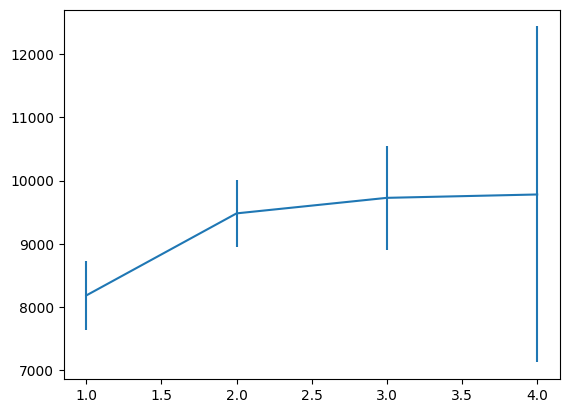

In [7]:
add_edge_participation(neighborhood)
result_mn = neighborhood.edges.groupby("max_dim")["total_size"].mean()
result_sem = neighborhood.edges.groupby("max_dim")["total_size"].apply(lambda _x: _x.std() / numpy.sqrt(len(_x)))

plt.errorbar(result_mn.index, result_mn.values, yerr=result_sem.values)

## Running the analysis for many randomly picked neighborhoods for more solid statistics.

In [8]:
import tqdm

smpls = numpy.random.choice(I.index, 5000, replace=False)
smpl_nrn_df = M.vertices.iloc[smpls]

overexpression = []
edges = []
for smpl in tqdm.tqdm(smpls):
    neighborhood = M.subpopulation(I[smpl])
    
    score = distance_dependent_zscores(neighborhood, P_pc_pc)["overexpression_factor"]
    overexpression.append(score)

    add_edge_participation(neighborhood, max_dim=max_dim)
    edges.append(neighborhood.edges)

  0%|                                                                                  | 1/5000 [00:00<30:49,  2.70it/s]

Done running flagser


  0%|                                                                                  | 2/5000 [00:00<27:20,  3.05it/s]

Done running flagser


  0%|                                                                                  | 3/5000 [00:01<28:52,  2.88it/s]

Done running flagser


  0%|                                                                                  | 4/5000 [00:01<33:07,  2.51it/s]

Done running flagser


  0%|                                                                                  | 5/5000 [00:01<32:49,  2.54it/s]

Done running flagser


  0%|                                                                                  | 6/5000 [00:02<32:45,  2.54it/s]

Done running flagser
Done running flagser


  0%|▏                                                                                 | 8/5000 [00:03<35:45,  2.33it/s]

Done running flagser


  0%|▏                                                                                 | 9/5000 [00:03<33:51,  2.46it/s]

Done running flagser


  0%|▏                                                                                | 10/5000 [00:03<30:33,  2.72it/s]

Done running flagser
Done running flagser


  0%|▏                                                                                | 12/5000 [00:04<32:46,  2.54it/s]

Done running flagser


  0%|▏                                                                                | 13/5000 [00:05<30:07,  2.76it/s]

Done running flagser


  0%|▏                                                                                | 14/5000 [00:05<31:24,  2.65it/s]

Done running flagser


  0%|▏                                                                                | 15/5000 [00:05<33:11,  2.50it/s]

Done running flagser


  0%|▎                                                                                | 16/5000 [00:06<34:25,  2.41it/s]

Done running flagser


  0%|▎                                                                                | 17/5000 [00:06<33:04,  2.51it/s]

Done running flagser


  0%|▎                                                                                | 18/5000 [00:07<35:42,  2.33it/s]

Done running flagser


  0%|▎                                                                                | 19/5000 [00:07<33:58,  2.44it/s]

Done running flagser


  0%|▎                                                                                | 20/5000 [00:08<33:41,  2.46it/s]

Done running flagser


  0%|▎                                                                                | 21/5000 [00:08<32:47,  2.53it/s]

Done running flagser
Done running flagser


  0%|▎                                                                              | 22/5000 [00:15<3:08:35,  2.27s/it]

Done running flagser


  0%|▍                                                                              | 24/5000 [00:17<2:15:54,  1.64s/it]

Done running flagser


  0%|▍                                                                              | 25/5000 [00:17<1:44:27,  1.26s/it]

Done running flagser


  1%|▍                                                                              | 26/5000 [00:18<1:20:44,  1.03it/s]

Done running flagser


  1%|▍                                                                              | 27/5000 [00:18<1:06:44,  1.24it/s]

Done running flagser


  1%|▍                                                                                | 28/5000 [00:18<56:36,  1.46it/s]

Done running flagser
Done running flagser


  1%|▍                                                                                | 30/5000 [00:19<49:19,  1.68it/s]

Done running flagser


  1%|▌                                                                                | 31/5000 [00:20<45:06,  1.84it/s]

Done running flagser


  1%|▌                                                                                | 32/5000 [00:20<42:03,  1.97it/s]

Done running flagser


  1%|▌                                                                                | 33/5000 [00:21<41:00,  2.02it/s]

Done running flagser
Done running flagser


  1%|▌                                                                                | 34/5000 [00:21<43:41,  1.89it/s]

Done running flagser


  1%|▌                                                                                | 36/5000 [00:22<42:22,  1.95it/s]

Done running flagser


  1%|▌                                                                                | 37/5000 [00:23<38:54,  2.13it/s]

Done running flagser


  1%|▌                                                                                | 38/5000 [00:23<35:58,  2.30it/s]

Done running flagser


  1%|▋                                                                                | 39/5000 [00:24<35:34,  2.32it/s]

Done running flagser


  1%|▋                                                                                | 40/5000 [00:24<35:23,  2.34it/s]

Done running flagser
Done running flagser


  1%|▋                                                                                | 42/5000 [00:25<36:03,  2.29it/s]

Done running flagser


  1%|▋                                                                                | 43/5000 [00:25<32:41,  2.53it/s]

Done running flagser


  1%|▋                                                                                | 44/5000 [00:26<31:42,  2.61it/s]

Done running flagser


  1%|▋                                                                                | 45/5000 [00:26<32:48,  2.52it/s]

Done running flagser


  1%|▋                                                                                | 46/5000 [00:26<34:49,  2.37it/s]

Done running flagser


  1%|▊                                                                                | 47/5000 [00:27<32:54,  2.51it/s]

Done running flagser


  1%|▊                                                                                | 48/5000 [00:27<32:41,  2.52it/s]

Done running flagser


  1%|▊                                                                                | 49/5000 [00:28<33:08,  2.49it/s]

Done running flagser


  1%|▊                                                                                | 50/5000 [00:28<32:19,  2.55it/s]

Done running flagser


  1%|▊                                                                                | 51/5000 [00:28<32:22,  2.55it/s]

Done running flagser


  1%|▊                                                                                | 52/5000 [00:29<32:10,  2.56it/s]

Done running flagser


  1%|▊                                                                                | 53/5000 [00:29<30:06,  2.74it/s]

Done running flagser


  1%|▊                                                                                | 54/5000 [00:29<30:28,  2.70it/s]

Done running flagser


  1%|▉                                                                                | 55/5000 [00:30<31:11,  2.64it/s]

Done running flagser


  1%|▉                                                                                | 56/5000 [00:30<31:13,  2.64it/s]

Done running flagser


  1%|▉                                                                                | 57/5000 [00:31<31:05,  2.65it/s]

Done running flagser
Done running flagser


  1%|▉                                                                                | 59/5000 [00:33<57:29,  1.43it/s]

Done running flagser


  1%|▉                                                                                | 60/5000 [00:33<49:40,  1.66it/s]

Done running flagser


  1%|▉                                                                                | 61/5000 [00:34<45:52,  1.79it/s]

Done running flagser


  1%|█                                                                                | 62/5000 [00:34<41:10,  2.00it/s]

Done running flagser


  1%|█                                                                                | 63/5000 [00:34<36:14,  2.27it/s]

Done running flagser


  1%|█                                                                                | 64/5000 [00:35<32:31,  2.53it/s]

Done running flagser


  1%|█                                                                                | 65/5000 [00:35<29:55,  2.75it/s]

Done running flagser


  1%|█                                                                                | 66/5000 [00:35<29:22,  2.80it/s]

Done running flagser


  1%|█                                                                                | 67/5000 [00:36<32:29,  2.53it/s]

Done running flagser


  1%|█                                                                                | 68/5000 [00:36<31:08,  2.64it/s]

Done running flagser
Done running flagser


  1%|█▏                                                                               | 70/5000 [00:37<37:23,  2.20it/s]

Done running flagser


  1%|█▏                                                                               | 71/5000 [00:38<33:43,  2.44it/s]

Done running flagser


  1%|█▏                                                                               | 72/5000 [00:38<32:42,  2.51it/s]

Done running flagser


  1%|█▏                                                                               | 73/5000 [00:38<32:51,  2.50it/s]

Done running flagser


  1%|█▏                                                                               | 74/5000 [00:39<31:59,  2.57it/s]

Done running flagser


  2%|█▏                                                                               | 75/5000 [00:39<30:53,  2.66it/s]

Done running flagser


  2%|█▏                                                                               | 76/5000 [00:39<28:44,  2.85it/s]

Done running flagser


  2%|█▏                                                                               | 77/5000 [00:40<31:11,  2.63it/s]

Done running flagser


  2%|█▎                                                                               | 78/5000 [00:40<30:56,  2.65it/s]

Done running flagser


  2%|█▎                                                                               | 79/5000 [00:40<29:10,  2.81it/s]

Done running flagser


  2%|█▎                                                                               | 80/5000 [00:41<27:51,  2.94it/s]

Done running flagser


  2%|█▎                                                                               | 81/5000 [00:41<27:25,  2.99it/s]

Done running flagser


  2%|█▎                                                                               | 82/5000 [00:41<28:07,  2.91it/s]

Done running flagser


  2%|█▎                                                                               | 83/5000 [00:42<27:46,  2.95it/s]

Done running flagser


  2%|█▎                                                                               | 84/5000 [00:42<26:49,  3.05it/s]

Done running flagser


  2%|█▍                                                                               | 85/5000 [00:42<27:37,  2.97it/s]

Done running flagser
Done running flagser


  2%|█▍                                                                               | 87/5000 [00:43<30:33,  2.68it/s]

Done running flagser


  2%|█▍                                                                               | 88/5000 [00:44<30:05,  2.72it/s]

Done running flagser


  2%|█▍                                                                               | 89/5000 [00:44<28:10,  2.90it/s]

Done running flagser


  2%|█▍                                                                               | 90/5000 [00:44<27:01,  3.03it/s]

Done running flagser


  2%|█▍                                                                               | 91/5000 [00:45<32:04,  2.55it/s]

Done running flagser


  2%|█▍                                                                               | 92/5000 [00:45<32:09,  2.54it/s]

Done running flagser


  2%|█▌                                                                               | 93/5000 [00:45<31:35,  2.59it/s]

Done running flagser


  2%|█▌                                                                               | 94/5000 [00:46<29:22,  2.78it/s]

Done running flagser


  2%|█▌                                                                               | 95/5000 [00:46<28:16,  2.89it/s]

Done running flagser


  2%|█▌                                                                               | 96/5000 [00:46<27:00,  3.03it/s]

Done running flagser


  2%|█▌                                                                               | 97/5000 [00:47<27:45,  2.94it/s]

Done running flagser


  2%|█▌                                                                               | 98/5000 [00:47<29:35,  2.76it/s]

Done running flagser


  2%|█▌                                                                               | 99/5000 [00:47<28:23,  2.88it/s]

Done running flagser


  2%|█▌                                                                              | 100/5000 [00:48<28:42,  2.85it/s]

Done running flagser


  2%|█▌                                                                              | 101/5000 [00:48<29:25,  2.77it/s]

Done running flagser
Done running flagser


  2%|█▋                                                                              | 103/5000 [00:49<37:02,  2.20it/s]

Done running flagser


  2%|█▋                                                                              | 104/5000 [00:50<33:10,  2.46it/s]

Done running flagser


  2%|█▋                                                                              | 105/5000 [00:50<30:42,  2.66it/s]

Done running flagser


  2%|█▋                                                                              | 106/5000 [00:50<28:41,  2.84it/s]

Done running flagser
Done running flagser


  2%|█▋                                                                              | 108/5000 [00:51<35:54,  2.27it/s]

Done running flagser


  2%|█▋                                                                              | 109/5000 [00:52<36:08,  2.26it/s]

Done running flagser


  2%|█▊                                                                              | 110/5000 [00:52<35:14,  2.31it/s]

Done running flagser


  2%|█▊                                                                              | 111/5000 [00:53<34:08,  2.39it/s]

Done running flagser


  2%|█▊                                                                              | 112/5000 [00:53<32:33,  2.50it/s]

Done running flagser


  2%|█▊                                                                              | 113/5000 [00:53<31:09,  2.61it/s]

Done running flagser


  2%|█▊                                                                              | 114/5000 [00:54<31:27,  2.59it/s]

Done running flagser
Done running flagser


  2%|█▊                                                                              | 116/5000 [00:55<36:43,  2.22it/s]

Done running flagser


  2%|█▊                                                                              | 117/5000 [00:55<36:10,  2.25it/s]

Done running flagser


  2%|█▉                                                                              | 118/5000 [00:56<34:39,  2.35it/s]

Done running flagser


  2%|█▉                                                                              | 119/5000 [00:56<32:07,  2.53it/s]

Done running flagser


  2%|█▉                                                                              | 120/5000 [00:56<33:15,  2.45it/s]

Done running flagser


  2%|█▉                                                                              | 121/5000 [00:57<36:06,  2.25it/s]

Done running flagser


  2%|█▉                                                                              | 122/5000 [00:57<34:19,  2.37it/s]

Done running flagser


  2%|█▉                                                                              | 123/5000 [00:58<33:22,  2.44it/s]

Done running flagser
Done running flagser


  2%|██                                                                              | 125/5000 [00:59<37:06,  2.19it/s]

Done running flagser


  3%|██                                                                              | 126/5000 [00:59<36:18,  2.24it/s]

Done running flagser


  3%|██                                                                              | 127/5000 [00:59<33:25,  2.43it/s]

Done running flagser


  3%|██                                                                              | 128/5000 [01:00<30:44,  2.64it/s]

Done running flagser


  3%|██                                                                              | 129/5000 [01:00<32:31,  2.50it/s]

Done running flagser


  3%|██                                                                              | 130/5000 [01:01<33:32,  2.42it/s]

Done running flagser


  3%|██                                                                              | 131/5000 [01:01<32:16,  2.51it/s]

Done running flagser
Done running flagser


  3%|██                                                                            | 133/5000 [01:04<1:10:48,  1.15it/s]

Done running flagser


  3%|██▏                                                                             | 134/5000 [01:04<57:22,  1.41it/s]

Done running flagser
Done running flagser


  3%|██▏                                                                             | 136/5000 [01:05<47:06,  1.72it/s]

Done running flagser


  3%|██▏                                                                             | 137/5000 [01:06<42:09,  1.92it/s]

Done running flagser


  3%|██▏                                                                             | 138/5000 [01:06<38:29,  2.10it/s]

Done running flagser


  3%|██▏                                                                             | 139/5000 [01:07<36:21,  2.23it/s]

Done running flagser


  3%|██▏                                                                             | 140/5000 [01:07<36:09,  2.24it/s]

Done running flagser


  3%|██▎                                                                             | 141/5000 [01:07<35:26,  2.29it/s]

Done running flagser


  3%|██▎                                                                             | 142/5000 [01:08<33:36,  2.41it/s]

Done running flagser


  3%|██▎                                                                             | 143/5000 [01:08<31:01,  2.61it/s]

Done running flagser


  3%|██▎                                                                             | 144/5000 [01:08<31:23,  2.58it/s]

Done running flagser


  3%|██▎                                                                             | 145/5000 [01:09<31:11,  2.59it/s]

Done running flagser


  3%|██▎                                                                             | 146/5000 [01:09<30:13,  2.68it/s]

Done running flagser


  3%|██▎                                                                             | 147/5000 [01:10<31:36,  2.56it/s]

Done running flagser


  3%|██▎                                                                             | 148/5000 [01:10<29:07,  2.78it/s]

Done running flagser


  3%|██▍                                                                             | 149/5000 [01:10<29:56,  2.70it/s]

Done running flagser


  3%|██▍                                                                             | 150/5000 [01:11<28:07,  2.87it/s]

Done running flagser
Done running flagser


  3%|██▍                                                                             | 152/5000 [01:11<30:45,  2.63it/s]

Done running flagser


  3%|██▍                                                                             | 153/5000 [01:12<31:52,  2.54it/s]

Done running flagser


  3%|██▍                                                                             | 154/5000 [01:12<29:49,  2.71it/s]

Done running flagser


  3%|██▍                                                                             | 155/5000 [01:13<29:08,  2.77it/s]

Done running flagser


  3%|██▍                                                                             | 156/5000 [01:13<29:53,  2.70it/s]

Done running flagser


  3%|██▌                                                                             | 157/5000 [01:13<29:43,  2.72it/s]

Done running flagser


  3%|██▌                                                                             | 158/5000 [01:14<29:55,  2.70it/s]

Done running flagser


  3%|██▌                                                                             | 159/5000 [01:14<29:29,  2.74it/s]

Done running flagser
Done running flagser


  3%|██▌                                                                             | 161/5000 [01:16<50:42,  1.59it/s]

Done running flagser


  3%|██▌                                                                             | 162/5000 [01:16<43:45,  1.84it/s]

Done running flagser
Done running flagser


  3%|██▌                                                                           | 163/5000 [01:19<1:24:37,  1.05s/it]

Done running flagser


  3%|██▌                                                                           | 165/5000 [01:20<1:03:04,  1.28it/s]

Done running flagser


  3%|██▋                                                                             | 166/5000 [01:20<52:24,  1.54it/s]

Done running flagser


  3%|██▋                                                                             | 167/5000 [01:20<45:38,  1.76it/s]

Done running flagser


  3%|██▋                                                                             | 168/5000 [01:21<41:21,  1.95it/s]

Done running flagser


  3%|██▋                                                                             | 169/5000 [01:21<37:29,  2.15it/s]

Done running flagser


  3%|██▋                                                                             | 170/5000 [01:21<33:54,  2.37it/s]

Done running flagser


  3%|██▋                                                                             | 171/5000 [01:22<32:08,  2.50it/s]

Done running flagser


  3%|██▊                                                                             | 172/5000 [01:22<31:14,  2.58it/s]

Done running flagser


  3%|██▊                                                                             | 173/5000 [01:23<30:35,  2.63it/s]

Done running flagser


  3%|██▊                                                                             | 174/5000 [01:23<30:35,  2.63it/s]

Done running flagser


  4%|██▊                                                                             | 175/5000 [01:23<33:55,  2.37it/s]

Done running flagser


  4%|██▊                                                                             | 176/5000 [01:24<34:37,  2.32it/s]

Done running flagser


  4%|██▊                                                                             | 177/5000 [01:24<34:18,  2.34it/s]

Done running flagser


  4%|██▊                                                                             | 178/5000 [01:25<32:01,  2.51it/s]

Done running flagser


  4%|██▊                                                                             | 179/5000 [01:25<31:19,  2.57it/s]

Done running flagser


  4%|██▉                                                                             | 180/5000 [01:25<30:04,  2.67it/s]

Done running flagser


  4%|██▉                                                                             | 181/5000 [01:26<32:40,  2.46it/s]

Done running flagser
Done running flagser


  4%|██▉                                                                             | 183/5000 [01:27<35:57,  2.23it/s]

Done running flagser


  4%|██▉                                                                             | 184/5000 [01:27<32:07,  2.50it/s]

Done running flagser


  4%|██▉                                                                             | 185/5000 [01:28<31:56,  2.51it/s]

Done running flagser


  4%|██▉                                                                             | 186/5000 [01:28<31:21,  2.56it/s]

Done running flagser
Done running flagser


  4%|███                                                                             | 188/5000 [01:29<43:31,  1.84it/s]

Done running flagser


  4%|███                                                                             | 189/5000 [01:30<40:44,  1.97it/s]

Done running flagser


  4%|███                                                                             | 190/5000 [01:30<39:21,  2.04it/s]

Done running flagser


  4%|███                                                                             | 191/5000 [01:31<36:25,  2.20it/s]

Done running flagser


  4%|███                                                                             | 192/5000 [01:31<35:49,  2.24it/s]

Done running flagser


  4%|███                                                                             | 193/5000 [01:31<32:47,  2.44it/s]

Done running flagser


  4%|███                                                                             | 194/5000 [01:32<35:04,  2.28it/s]

Done running flagser


  4%|███                                                                             | 195/5000 [01:32<33:24,  2.40it/s]

Done running flagser


  4%|███▏                                                                            | 196/5000 [01:33<30:16,  2.64it/s]

Done running flagser


  4%|███▏                                                                            | 197/5000 [01:33<28:10,  2.84it/s]

Done running flagser


  4%|███▏                                                                            | 198/5000 [01:33<29:23,  2.72it/s]

Done running flagser


  4%|███▏                                                                            | 199/5000 [01:34<28:24,  2.82it/s]

Done running flagser


  4%|███▏                                                                            | 200/5000 [01:34<26:59,  2.96it/s]

Done running flagser


  4%|███▏                                                                            | 201/5000 [01:34<25:52,  3.09it/s]

Done running flagser


  4%|███▏                                                                            | 202/5000 [01:35<27:59,  2.86it/s]

Done running flagser


  4%|███▏                                                                            | 203/5000 [01:35<28:02,  2.85it/s]

Done running flagser


  4%|███▎                                                                            | 204/5000 [01:35<27:16,  2.93it/s]

Done running flagser


  4%|███▎                                                                            | 205/5000 [01:36<26:00,  3.07it/s]

Done running flagser


  4%|███▎                                                                            | 206/5000 [01:36<25:12,  3.17it/s]

Done running flagser


  4%|███▎                                                                            | 207/5000 [01:36<24:47,  3.22it/s]

Done running flagser


  4%|███▎                                                                            | 208/5000 [01:36<24:37,  3.24it/s]

Done running flagser


  4%|███▎                                                                            | 209/5000 [01:37<30:04,  2.66it/s]

Done running flagser


  4%|███▎                                                                            | 210/5000 [01:37<27:56,  2.86it/s]

Done running flagser


  4%|███▍                                                                            | 211/5000 [01:38<26:15,  3.04it/s]

Done running flagser


  4%|███▍                                                                            | 212/5000 [01:38<25:17,  3.16it/s]

Done running flagser


  4%|███▍                                                                            | 213/5000 [01:38<27:44,  2.88it/s]

Done running flagser


  4%|███▍                                                                            | 214/5000 [01:39<28:13,  2.83it/s]

Done running flagser


  4%|███▍                                                                            | 215/5000 [01:39<26:40,  2.99it/s]

Done running flagser


  4%|███▍                                                                            | 216/5000 [01:39<27:43,  2.88it/s]

Done running flagser


  4%|███▍                                                                            | 217/5000 [01:40<27:55,  2.85it/s]

Done running flagser


  4%|███▍                                                                            | 218/5000 [01:40<26:53,  2.96it/s]

Done running flagser
Done running flagser


  4%|███▌                                                                            | 220/5000 [01:41<33:02,  2.41it/s]

Done running flagser
Done running flagser


  4%|███▌                                                                            | 222/5000 [01:42<33:03,  2.41it/s]

Done running flagser


  4%|███▌                                                                            | 223/5000 [01:42<30:22,  2.62it/s]

Done running flagser


  4%|███▌                                                                            | 224/5000 [01:43<30:37,  2.60it/s]

Done running flagser


  4%|███▌                                                                            | 225/5000 [01:43<33:35,  2.37it/s]

Done running flagser


  5%|███▌                                                                            | 226/5000 [01:43<31:16,  2.54it/s]

Done running flagser


  5%|███▋                                                                            | 227/5000 [01:44<30:11,  2.63it/s]

Done running flagser


  5%|███▋                                                                            | 228/5000 [01:44<30:00,  2.65it/s]

Done running flagser


  5%|███▋                                                                            | 229/5000 [01:45<30:34,  2.60it/s]

Done running flagser
Done running flagser


  5%|███▋                                                                            | 231/5000 [01:46<35:55,  2.21it/s]

Done running flagser


  5%|███▋                                                                            | 232/5000 [01:46<34:47,  2.28it/s]

Done running flagser


  5%|███▋                                                                            | 233/5000 [01:46<30:54,  2.57it/s]

Done running flagser


  5%|███▋                                                                            | 234/5000 [01:47<28:53,  2.75it/s]

Done running flagser


  5%|███▊                                                                            | 235/5000 [01:47<32:21,  2.45it/s]

Done running flagser


  5%|███▊                                                                            | 236/5000 [01:47<31:34,  2.51it/s]

Done running flagser


  5%|███▊                                                                            | 237/5000 [01:48<31:52,  2.49it/s]

Done running flagser
Done running flagser


  5%|███▊                                                                            | 238/5000 [01:49<39:11,  2.03it/s]

Done running flagser


  5%|███▊                                                                            | 240/5000 [01:50<38:50,  2.04it/s]

Done running flagser


  5%|███▊                                                                            | 241/5000 [01:50<37:49,  2.10it/s]

Done running flagser
Done running flagser


  5%|███▉                                                                            | 243/5000 [01:51<39:39,  2.00it/s]

Done running flagser
Done running flagser


  5%|███▊                                                                          | 245/5000 [01:58<2:13:54,  1.69s/it]

Done running flagser
Done running flagser


  5%|███▊                                                                          | 247/5000 [01:59<1:30:26,  1.14s/it]

Done running flagser


  5%|███▊                                                                          | 248/5000 [02:00<1:12:20,  1.09it/s]

Done running flagser


  5%|███▉                                                                          | 249/5000 [02:00<1:00:14,  1.31it/s]

Done running flagser


  5%|████                                                                            | 250/5000 [02:00<51:29,  1.54it/s]

Done running flagser
Done running flagser


  5%|████                                                                            | 252/5000 [02:02<48:37,  1.63it/s]

Done running flagser


  5%|████                                                                            | 253/5000 [02:02<43:02,  1.84it/s]

Done running flagser
Done running flagser


  5%|████                                                                            | 255/5000 [02:03<41:13,  1.92it/s]

Done running flagser


  5%|████                                                                            | 256/5000 [02:03<37:55,  2.08it/s]

Done running flagser
Done running flagser


  5%|████▏                                                                           | 258/5000 [02:05<45:17,  1.74it/s]

Done running flagser


  5%|████▏                                                                           | 259/5000 [02:05<42:22,  1.87it/s]

Done running flagser


  5%|████▏                                                                           | 260/5000 [02:06<37:00,  2.13it/s]

Done running flagser


  5%|████▏                                                                           | 261/5000 [02:06<33:30,  2.36it/s]

Done running flagser


  5%|████▏                                                                           | 262/5000 [02:06<31:47,  2.48it/s]

Done running flagser


  5%|████▏                                                                           | 263/5000 [02:07<32:08,  2.46it/s]

Done running flagser


  5%|████▏                                                                           | 264/5000 [02:07<31:31,  2.50it/s]

Done running flagser


  5%|████▏                                                                           | 265/5000 [02:07<30:34,  2.58it/s]

Done running flagser


  5%|████▎                                                                           | 266/5000 [02:08<30:30,  2.59it/s]

Done running flagser


  5%|████▎                                                                           | 267/5000 [02:08<34:22,  2.29it/s]

Done running flagser


  5%|████▎                                                                           | 268/5000 [02:09<32:09,  2.45it/s]

Done running flagser


  5%|████▎                                                                           | 269/5000 [02:09<30:29,  2.59it/s]

Done running flagser


  5%|████▎                                                                           | 270/5000 [02:09<28:24,  2.77it/s]

Done running flagser


  5%|████▎                                                                           | 271/5000 [02:10<29:05,  2.71it/s]

Done running flagser


  5%|████▎                                                                           | 272/5000 [02:10<27:31,  2.86it/s]

Done running flagser


  5%|████▎                                                                           | 273/5000 [02:10<26:57,  2.92it/s]

Done running flagser


  5%|████▍                                                                           | 274/5000 [02:11<26:06,  3.02it/s]

Done running flagser


  6%|████▍                                                                           | 275/5000 [02:11<26:11,  3.01it/s]

Done running flagser


  6%|████▍                                                                           | 276/5000 [02:11<27:07,  2.90it/s]

Done running flagser


  6%|████▍                                                                           | 277/5000 [02:12<27:14,  2.89it/s]

Done running flagser


  6%|████▍                                                                           | 278/5000 [02:12<26:11,  3.00it/s]

Done running flagser


  6%|████▍                                                                           | 279/5000 [02:12<25:24,  3.10it/s]

Done running flagser


  6%|████▍                                                                           | 280/5000 [02:13<26:23,  2.98it/s]

Done running flagser


  6%|████▍                                                                           | 281/5000 [02:13<26:31,  2.97it/s]

Done running flagser


  6%|████▌                                                                           | 282/5000 [02:13<25:50,  3.04it/s]

Done running flagser


  6%|████▌                                                                           | 283/5000 [02:14<28:33,  2.75it/s]

Done running flagser


  6%|████▌                                                                           | 284/5000 [02:14<27:07,  2.90it/s]

Done running flagser


  6%|████▌                                                                           | 285/5000 [02:14<25:33,  3.07it/s]

Done running flagser


  6%|████▌                                                                           | 286/5000 [02:15<26:35,  2.95it/s]

Done running flagser


  6%|████▌                                                                           | 287/5000 [02:15<25:38,  3.06it/s]

Done running flagser


  6%|████▌                                                                           | 288/5000 [02:15<24:50,  3.16it/s]

Done running flagser


  6%|████▌                                                                           | 289/5000 [02:16<26:32,  2.96it/s]

Done running flagser


  6%|████▋                                                                           | 290/5000 [02:16<26:24,  2.97it/s]

Done running flagser


  6%|████▋                                                                           | 291/5000 [02:17<28:20,  2.77it/s]

Done running flagser


  6%|████▋                                                                           | 292/5000 [02:17<29:05,  2.70it/s]

Done running flagser


  6%|████▋                                                                           | 293/5000 [02:17<27:47,  2.82it/s]

Done running flagser


  6%|████▋                                                                           | 294/5000 [02:18<27:29,  2.85it/s]

Done running flagser


  6%|████▋                                                                           | 295/5000 [02:18<29:04,  2.70it/s]

Done running flagser


  6%|████▋                                                                           | 296/5000 [02:18<29:54,  2.62it/s]

Done running flagser


  6%|████▊                                                                           | 297/5000 [02:19<27:38,  2.84it/s]

Done running flagser


  6%|████▊                                                                           | 298/5000 [02:19<29:05,  2.69it/s]

Done running flagser


  6%|████▊                                                                           | 299/5000 [02:19<28:58,  2.70it/s]

Done running flagser


  6%|████▊                                                                           | 300/5000 [02:20<28:25,  2.76it/s]

Done running flagser


  6%|████▊                                                                           | 301/5000 [02:20<28:35,  2.74it/s]

Done running flagser


  6%|████▊                                                                           | 302/5000 [02:21<30:46,  2.54it/s]

Done running flagser


  6%|████▊                                                                           | 303/5000 [02:21<30:25,  2.57it/s]

Done running flagser


  6%|████▊                                                                           | 304/5000 [02:21<28:27,  2.75it/s]

Done running flagser


  6%|████▉                                                                           | 305/5000 [02:22<28:05,  2.79it/s]

Done running flagser


  6%|████▉                                                                           | 306/5000 [02:22<26:31,  2.95it/s]

Done running flagser


  6%|████▉                                                                           | 307/5000 [02:22<27:37,  2.83it/s]

Done running flagser


  6%|████▉                                                                           | 308/5000 [02:23<28:00,  2.79it/s]

Done running flagser


  6%|████▉                                                                           | 309/5000 [02:23<28:37,  2.73it/s]

Done running flagser


  6%|████▉                                                                           | 310/5000 [02:23<28:24,  2.75it/s]

Done running flagser


  6%|████▉                                                                           | 311/5000 [02:24<29:00,  2.69it/s]

Done running flagser


  6%|████▉                                                                           | 312/5000 [02:24<27:12,  2.87it/s]

Done running flagser


  6%|█████                                                                           | 313/5000 [02:25<27:47,  2.81it/s]

Done running flagser


  6%|█████                                                                           | 314/5000 [02:25<26:37,  2.93it/s]

Done running flagser


  6%|█████                                                                           | 315/5000 [02:25<29:55,  2.61it/s]

Done running flagser


  6%|█████                                                                           | 316/5000 [02:26<30:11,  2.59it/s]

Done running flagser


  6%|█████                                                                           | 317/5000 [02:26<31:00,  2.52it/s]

Done running flagser


  6%|█████                                                                           | 318/5000 [02:27<30:38,  2.55it/s]

Done running flagser


  6%|█████                                                                           | 319/5000 [02:27<29:21,  2.66it/s]

Done running flagser


  6%|█████                                                                           | 320/5000 [02:27<29:40,  2.63it/s]

Done running flagser


  6%|█████▏                                                                          | 321/5000 [02:28<29:05,  2.68it/s]

Done running flagser


  6%|█████▏                                                                          | 322/5000 [02:28<28:26,  2.74it/s]

Done running flagser


  6%|█████▏                                                                          | 323/5000 [02:28<28:12,  2.76it/s]

Done running flagser


  6%|█████▏                                                                          | 324/5000 [02:29<28:47,  2.71it/s]

Done running flagser


  6%|█████▏                                                                          | 325/5000 [02:29<30:07,  2.59it/s]

Done running flagser
Done running flagser


  7%|█████▏                                                                          | 327/5000 [02:30<37:13,  2.09it/s]

Done running flagser


  7%|█████▏                                                                          | 328/5000 [02:31<38:19,  2.03it/s]

Done running flagser


  7%|█████▎                                                                          | 329/5000 [02:31<35:01,  2.22it/s]

Done running flagser


  7%|█████▎                                                                          | 330/5000 [02:32<31:22,  2.48it/s]

Done running flagser


  7%|█████▎                                                                          | 331/5000 [02:32<31:36,  2.46it/s]

Done running flagser


  7%|█████▎                                                                          | 332/5000 [02:32<29:54,  2.60it/s]

Done running flagser
Done running flagser


  7%|█████▎                                                                          | 334/5000 [02:34<39:15,  1.98it/s]

Done running flagser


  7%|█████▎                                                                          | 335/5000 [02:34<35:27,  2.19it/s]

Done running flagser


  7%|█████▍                                                                          | 336/5000 [02:34<33:39,  2.31it/s]

Done running flagser


  7%|█████▍                                                                          | 337/5000 [02:35<36:23,  2.14it/s]

Done running flagser
Done running flagser


  7%|█████▍                                                                          | 339/5000 [02:36<39:59,  1.94it/s]

Done running flagser


  7%|█████▍                                                                          | 340/5000 [02:36<37:10,  2.09it/s]

Done running flagser


  7%|█████▍                                                                          | 341/5000 [02:37<36:03,  2.15it/s]

Done running flagser


  7%|█████▍                                                                          | 342/5000 [02:37<33:48,  2.30it/s]

Done running flagser


  7%|█████▍                                                                          | 343/5000 [02:38<32:00,  2.42it/s]

Done running flagser


  7%|█████▌                                                                          | 344/5000 [02:38<29:19,  2.65it/s]

Done running flagser
Done running flagser


  7%|█████▍                                                                        | 346/5000 [02:46<2:31:51,  1.96s/it]

Done running flagser


  7%|█████▍                                                                        | 347/5000 [02:47<1:53:30,  1.46s/it]

Done running flagser


  7%|█████▍                                                                        | 348/5000 [02:47<1:28:21,  1.14s/it]

Done running flagser


  7%|█████▍                                                                        | 349/5000 [02:47<1:10:04,  1.11it/s]

Done running flagser


  7%|█████▌                                                                          | 350/5000 [02:48<58:22,  1.33it/s]

Done running flagser


  7%|█████▌                                                                          | 351/5000 [02:48<47:56,  1.62it/s]

Done running flagser


  7%|█████▋                                                                          | 352/5000 [02:48<40:30,  1.91it/s]

Done running flagser


  7%|█████▋                                                                          | 353/5000 [02:49<35:41,  2.17it/s]

Done running flagser


  7%|█████▋                                                                          | 354/5000 [02:49<31:45,  2.44it/s]

Done running flagser


  7%|█████▋                                                                          | 355/5000 [02:49<33:46,  2.29it/s]

Done running flagser
Done running flagser


  7%|█████▋                                                                          | 356/5000 [02:50<36:00,  2.15it/s]

Done running flagser


  7%|█████▋                                                                          | 358/5000 [02:51<36:14,  2.13it/s]

Done running flagser


  7%|█████▋                                                                          | 359/5000 [02:51<36:24,  2.12it/s]

Done running flagser


  7%|█████▊                                                                          | 360/5000 [02:52<32:41,  2.37it/s]

Done running flagser


  7%|█████▊                                                                          | 361/5000 [02:52<34:01,  2.27it/s]

Done running flagser


  7%|█████▊                                                                          | 362/5000 [02:53<32:42,  2.36it/s]

Done running flagser


  7%|█████▊                                                                          | 363/5000 [02:53<31:39,  2.44it/s]

Done running flagser
Done running flagser


  7%|█████▊                                                                          | 365/5000 [02:54<42:36,  1.81it/s]

Done running flagser


  7%|█████▊                                                                          | 366/5000 [02:55<38:46,  1.99it/s]

Done running flagser


  7%|█████▊                                                                          | 367/5000 [02:55<35:27,  2.18it/s]

Done running flagser


  7%|█████▉                                                                          | 368/5000 [02:56<32:30,  2.37it/s]

Done running flagser
Done running flagser


  7%|█████▊                                                                        | 370/5000 [02:58<1:00:43,  1.27it/s]

Done running flagser


  7%|█████▉                                                                          | 371/5000 [02:58<50:08,  1.54it/s]

Done running flagser
Done running flagser


  7%|█████▉                                                                          | 373/5000 [02:59<41:38,  1.85it/s]

Done running flagser


  7%|█████▉                                                                          | 374/5000 [03:00<37:02,  2.08it/s]

Done running flagser


  8%|██████                                                                          | 375/5000 [03:00<35:52,  2.15it/s]

Done running flagser


  8%|██████                                                                          | 376/5000 [03:01<34:20,  2.24it/s]

Done running flagser


  8%|██████                                                                          | 377/5000 [03:01<33:59,  2.27it/s]

Done running flagser


  8%|██████                                                                          | 378/5000 [03:01<33:03,  2.33it/s]

Done running flagser


  8%|██████                                                                          | 379/5000 [03:02<34:00,  2.26it/s]

Done running flagser


  8%|██████                                                                          | 380/5000 [03:02<32:23,  2.38it/s]

Done running flagser


  8%|██████                                                                          | 381/5000 [03:03<34:08,  2.25it/s]

Done running flagser


  8%|██████                                                                          | 382/5000 [03:03<30:37,  2.51it/s]

Done running flagser


  8%|██████▏                                                                         | 383/5000 [03:03<29:29,  2.61it/s]

Done running flagser


  8%|██████▏                                                                         | 384/5000 [03:04<27:11,  2.83it/s]

Done running flagser


  8%|██████▏                                                                         | 385/5000 [03:04<25:50,  2.98it/s]

Done running flagser


  8%|██████▏                                                                         | 386/5000 [03:04<26:45,  2.87it/s]

Done running flagser
Done running flagser


  8%|██████                                                                        | 388/5000 [03:08<1:10:19,  1.09it/s]

Done running flagser


  8%|██████▏                                                                         | 389/5000 [03:08<57:33,  1.34it/s]

Done running flagser


  8%|██████▏                                                                         | 390/5000 [03:08<47:35,  1.61it/s]

Done running flagser


  8%|██████▎                                                                         | 391/5000 [03:09<41:18,  1.86it/s]

Done running flagser


  8%|██████▎                                                                         | 392/5000 [03:09<37:41,  2.04it/s]

Done running flagser


  8%|██████▎                                                                         | 393/5000 [03:09<33:27,  2.30it/s]

Done running flagser


  8%|██████▎                                                                         | 394/5000 [03:10<30:57,  2.48it/s]

Done running flagser


  8%|██████▎                                                                         | 395/5000 [03:10<28:38,  2.68it/s]

Done running flagser


  8%|██████▎                                                                         | 396/5000 [03:10<26:45,  2.87it/s]

Done running flagser
Done running flagser


  8%|██████▎                                                                         | 398/5000 [03:12<36:15,  2.12it/s]

Done running flagser


  8%|██████▍                                                                         | 399/5000 [03:12<34:32,  2.22it/s]

Done running flagser


  8%|██████▍                                                                         | 400/5000 [03:12<30:58,  2.47it/s]

Done running flagser


  8%|██████▍                                                                         | 401/5000 [03:13<30:03,  2.55it/s]

Done running flagser
Done running flagser


  8%|██████▍                                                                         | 403/5000 [03:15<51:55,  1.48it/s]

Done running flagser


  8%|██████▍                                                                         | 404/5000 [03:15<45:01,  1.70it/s]

Done running flagser


  8%|██████▍                                                                         | 405/5000 [03:15<39:41,  1.93it/s]

Done running flagser


  8%|██████▍                                                                         | 406/5000 [03:16<34:56,  2.19it/s]

Done running flagser
Done running flagser


  8%|██████▎                                                                       | 408/5000 [03:18<1:02:35,  1.22it/s]

Done running flagser


  8%|██████▌                                                                         | 409/5000 [03:19<51:13,  1.49it/s]

Done running flagser
Done running flagser


  8%|██████▌                                                                         | 411/5000 [03:20<47:39,  1.60it/s]

Done running flagser


  8%|██████▌                                                                         | 412/5000 [03:20<41:26,  1.85it/s]

Done running flagser


  8%|██████▌                                                                         | 413/5000 [03:21<37:56,  2.02it/s]

Done running flagser


  8%|██████▌                                                                         | 414/5000 [03:21<36:05,  2.12it/s]

Done running flagser


  8%|██████▋                                                                         | 415/5000 [03:22<33:25,  2.29it/s]

Done running flagser


  8%|██████▋                                                                         | 416/5000 [03:22<31:36,  2.42it/s]

Done running flagser
Done running flagser


  8%|██████▋                                                                         | 417/5000 [03:22<33:14,  2.30it/s]

Done running flagser


  8%|██████▋                                                                         | 418/5000 [03:23<46:29,  1.64it/s]

Done running flagser


  8%|██████▋                                                                         | 420/5000 [03:25<50:59,  1.50it/s]

Done running flagser


  8%|██████▋                                                                         | 421/5000 [03:25<44:25,  1.72it/s]

Done running flagser


  8%|██████▊                                                                         | 422/5000 [03:26<42:51,  1.78it/s]

Done running flagser


  8%|██████▊                                                                         | 423/5000 [03:26<39:14,  1.94it/s]

Done running flagser


  8%|██████▊                                                                         | 424/5000 [03:27<36:29,  2.09it/s]

Done running flagser


  8%|██████▊                                                                         | 425/5000 [03:27<32:00,  2.38it/s]

Done running flagser
Done running flagser


  9%|██████▊                                                                         | 427/5000 [03:28<42:44,  1.78it/s]

Done running flagser


  9%|██████▊                                                                         | 428/5000 [03:29<37:14,  2.05it/s]

Done running flagser


  9%|██████▊                                                                         | 429/5000 [03:29<34:46,  2.19it/s]

Done running flagser


  9%|██████▉                                                                         | 430/5000 [03:30<33:58,  2.24it/s]

Done running flagser


  9%|██████▉                                                                         | 431/5000 [03:30<32:41,  2.33it/s]

Done running flagser
Done running flagser


  9%|██████▉                                                                         | 433/5000 [03:31<30:54,  2.46it/s]

Done running flagser


  9%|██████▉                                                                         | 434/5000 [03:31<31:12,  2.44it/s]

Done running flagser
Done running flagser


  9%|██████▊                                                                       | 435/5000 [03:33<1:07:33,  1.13it/s]

Done running flagser


  9%|██████▊                                                                       | 437/5000 [03:36<1:17:01,  1.01s/it]

Done running flagser


  9%|██████▊                                                                       | 438/5000 [03:36<1:00:22,  1.26it/s]

Done running flagser


  9%|███████                                                                         | 439/5000 [03:36<50:35,  1.50it/s]

Done running flagser


  9%|███████                                                                         | 440/5000 [03:37<45:26,  1.67it/s]

Done running flagser


  9%|███████                                                                         | 441/5000 [03:37<38:42,  1.96it/s]

Done running flagser


  9%|███████                                                                         | 442/5000 [03:38<38:47,  1.96it/s]

Done running flagser


  9%|███████                                                                         | 443/5000 [03:38<35:58,  2.11it/s]

Done running flagser


  9%|███████                                                                         | 444/5000 [03:38<33:18,  2.28it/s]

Done running flagser


  9%|███████                                                                         | 445/5000 [03:39<31:31,  2.41it/s]

Done running flagser


  9%|███████▏                                                                        | 446/5000 [03:39<30:07,  2.52it/s]

Done running flagser


  9%|███████▏                                                                        | 447/5000 [03:40<29:33,  2.57it/s]

Done running flagser


  9%|███████▏                                                                        | 448/5000 [03:40<27:14,  2.78it/s]

Done running flagser


  9%|███████▏                                                                        | 449/5000 [03:40<25:45,  2.94it/s]

Done running flagser


  9%|███████▏                                                                        | 450/5000 [03:41<26:53,  2.82it/s]

Done running flagser
Done running flagser


  9%|███████                                                                       | 452/5000 [03:44<1:06:29,  1.14it/s]

Done running flagser


  9%|███████▏                                                                        | 453/5000 [03:44<53:32,  1.42it/s]

Done running flagser


  9%|███████▎                                                                        | 454/5000 [03:44<43:52,  1.73it/s]

Done running flagser


  9%|███████▎                                                                        | 455/5000 [03:45<37:29,  2.02it/s]

Done running flagser


  9%|███████▎                                                                        | 456/5000 [03:45<39:45,  1.91it/s]

Done running flagser


  9%|███████▎                                                                        | 457/5000 [03:46<36:36,  2.07it/s]

Done running flagser


  9%|███████▎                                                                        | 458/5000 [03:46<34:56,  2.17it/s]

Done running flagser
Done running flagser


  9%|███████▏                                                                      | 460/5000 [03:52<1:51:56,  1.48s/it]

Done running flagser


  9%|███████▏                                                                      | 461/5000 [03:52<1:27:03,  1.15s/it]

Done running flagser


  9%|███████▏                                                                      | 462/5000 [03:52<1:07:34,  1.12it/s]

Done running flagser


  9%|███████▍                                                                        | 463/5000 [03:53<59:20,  1.27it/s]

Done running flagser


  9%|███████▍                                                                        | 464/5000 [03:53<51:26,  1.47it/s]

Done running flagser


  9%|███████▍                                                                        | 465/5000 [03:54<46:00,  1.64it/s]

Done running flagser
Done running flagser


  9%|███████▍                                                                        | 467/5000 [03:55<45:13,  1.67it/s]

Done running flagser


  9%|███████▍                                                                        | 468/5000 [03:55<39:20,  1.92it/s]

Done running flagser


  9%|███████▌                                                                        | 469/5000 [03:56<36:09,  2.09it/s]

Done running flagser


  9%|███████▌                                                                        | 470/5000 [03:56<32:13,  2.34it/s]

Done running flagser


  9%|███████▌                                                                        | 471/5000 [03:57<30:53,  2.44it/s]

Done running flagser


  9%|███████▌                                                                        | 472/5000 [03:57<30:50,  2.45it/s]

Done running flagser


  9%|███████▌                                                                        | 473/5000 [03:57<30:23,  2.48it/s]

Done running flagser


  9%|███████▌                                                                        | 474/5000 [03:58<28:14,  2.67it/s]

Done running flagser


 10%|███████▌                                                                        | 475/5000 [03:58<28:00,  2.69it/s]

Done running flagser


 10%|███████▌                                                                        | 476/5000 [03:58<28:07,  2.68it/s]

Done running flagser


 10%|███████▋                                                                        | 477/5000 [03:59<26:21,  2.86it/s]

Done running flagser


 10%|███████▋                                                                        | 478/5000 [03:59<26:25,  2.85it/s]

Done running flagser


 10%|███████▋                                                                        | 479/5000 [03:59<27:06,  2.78it/s]

Done running flagser


 10%|███████▋                                                                        | 480/5000 [04:00<27:35,  2.73it/s]

Done running flagser


 10%|███████▋                                                                        | 481/5000 [04:00<25:44,  2.93it/s]

Done running flagser
Done running flagser


 10%|███████▋                                                                        | 483/5000 [04:03<58:16,  1.29it/s]

Done running flagser


 10%|███████▋                                                                        | 484/5000 [04:03<49:07,  1.53it/s]

Done running flagser


 10%|███████▊                                                                        | 485/5000 [04:04<42:16,  1.78it/s]

Done running flagser


 10%|███████▊                                                                        | 486/5000 [04:04<37:56,  1.98it/s]

Done running flagser


 10%|███████▊                                                                        | 487/5000 [04:04<36:22,  2.07it/s]

Done running flagser


 10%|███████▊                                                                        | 488/5000 [04:05<32:09,  2.34it/s]

Done running flagser


 10%|███████▊                                                                        | 489/5000 [04:05<31:10,  2.41it/s]

Done running flagser
Done running flagser


 10%|███████▊                                                                        | 491/5000 [04:07<46:00,  1.63it/s]

Done running flagser


 10%|███████▊                                                                        | 492/5000 [04:07<38:55,  1.93it/s]

Done running flagser


 10%|███████▉                                                                        | 493/5000 [04:07<35:17,  2.13it/s]

Done running flagser


 10%|███████▉                                                                        | 494/5000 [04:08<34:13,  2.19it/s]

Done running flagser


 10%|███████▉                                                                        | 495/5000 [04:08<32:24,  2.32it/s]

Done running flagser


 10%|███████▉                                                                        | 496/5000 [04:09<31:06,  2.41it/s]

Done running flagser


 10%|███████▉                                                                        | 497/5000 [04:09<33:53,  2.21it/s]

Done running flagser


 10%|███████▉                                                                        | 498/5000 [04:09<30:07,  2.49it/s]

Done running flagser


 10%|███████▉                                                                        | 499/5000 [04:10<27:47,  2.70it/s]

Done running flagser


 10%|████████                                                                        | 500/5000 [04:10<29:05,  2.58it/s]

Done running flagser


 10%|████████                                                                        | 501/5000 [04:11<28:53,  2.60it/s]

Done running flagser


 10%|████████                                                                        | 502/5000 [04:11<29:05,  2.58it/s]

Done running flagser
Done running flagser


 10%|████████                                                                        | 503/5000 [04:12<37:28,  2.00it/s]

Done running flagser


 10%|████████                                                                        | 504/5000 [04:12<37:41,  1.99it/s]

Done running flagser


 10%|███████▉                                                                      | 506/5000 [04:15<1:06:40,  1.12it/s]

Done running flagser


 10%|████████                                                                        | 507/5000 [04:15<53:14,  1.41it/s]

Done running flagser


 10%|████████▏                                                                       | 508/5000 [04:16<45:15,  1.65it/s]

Done running flagser


 10%|████████▏                                                                       | 509/5000 [04:16<38:35,  1.94it/s]

Done running flagser


 10%|████████▏                                                                       | 510/5000 [04:17<36:23,  2.06it/s]

Done running flagser


 10%|████████▏                                                                       | 511/5000 [04:17<33:43,  2.22it/s]

Done running flagser


 10%|████████▏                                                                       | 512/5000 [04:17<34:02,  2.20it/s]

Done running flagser


 10%|████████▏                                                                       | 513/5000 [04:18<30:43,  2.43it/s]

Done running flagser


 10%|████████▏                                                                       | 514/5000 [04:18<29:52,  2.50it/s]

Done running flagser
Done running flagser


 10%|████████▎                                                                       | 516/5000 [04:19<32:45,  2.28it/s]

Done running flagser


 10%|████████▎                                                                       | 517/5000 [04:19<33:01,  2.26it/s]

Done running flagser


 10%|████████▎                                                                       | 518/5000 [04:20<30:41,  2.43it/s]

Done running flagser


 10%|████████▎                                                                       | 519/5000 [04:20<27:48,  2.69it/s]

Done running flagser


 10%|████████▎                                                                       | 520/5000 [04:20<25:53,  2.88it/s]

Done running flagser


 10%|████████▎                                                                       | 521/5000 [04:21<24:58,  2.99it/s]

Done running flagser
Done running flagser


 10%|████████▎                                                                       | 523/5000 [04:22<30:15,  2.47it/s]

Done running flagser


 10%|████████▍                                                                       | 524/5000 [04:22<29:09,  2.56it/s]

Done running flagser


 10%|████████▍                                                                       | 525/5000 [04:22<29:00,  2.57it/s]

Done running flagser


 11%|████████▍                                                                       | 526/5000 [04:23<26:40,  2.80it/s]

Done running flagser


 11%|████████▍                                                                       | 527/5000 [04:23<25:11,  2.96it/s]

Done running flagser


 11%|████████▍                                                                       | 528/5000 [04:23<28:28,  2.62it/s]

Done running flagser


 11%|████████▍                                                                       | 529/5000 [04:24<28:52,  2.58it/s]

Done running flagser


 11%|████████▍                                                                       | 530/5000 [04:24<26:31,  2.81it/s]

Done running flagser


 11%|████████▍                                                                       | 531/5000 [04:25<26:35,  2.80it/s]

Done running flagser


 11%|████████▌                                                                       | 532/5000 [04:25<26:42,  2.79it/s]

Done running flagser


 11%|████████▌                                                                       | 533/5000 [04:25<27:15,  2.73it/s]

Done running flagser


 11%|████████▌                                                                       | 534/5000 [04:26<27:41,  2.69it/s]

Done running flagser


 11%|████████▌                                                                       | 535/5000 [04:26<31:35,  2.36it/s]

Done running flagser


 11%|████████▌                                                                       | 536/5000 [04:27<30:18,  2.45it/s]

Done running flagser


 11%|████████▌                                                                       | 537/5000 [04:27<29:28,  2.52it/s]

Done running flagser


 11%|████████▌                                                                       | 538/5000 [04:27<28:31,  2.61it/s]

Done running flagser
Done running flagser


 11%|████████▋                                                                       | 540/5000 [04:29<41:19,  1.80it/s]

Done running flagser


 11%|████████▋                                                                       | 541/5000 [04:29<39:10,  1.90it/s]

Done running flagser


 11%|████████▋                                                                       | 542/5000 [04:30<37:54,  1.96it/s]

Done running flagser


 11%|████████▋                                                                       | 543/5000 [04:30<35:23,  2.10it/s]

Done running flagser


 11%|████████▋                                                                       | 544/5000 [04:31<36:05,  2.06it/s]

Done running flagser
Done running flagser


 11%|████████▋                                                                       | 545/5000 [04:31<36:44,  2.02it/s]

Done running flagser


 11%|████████▌                                                                     | 547/5000 [04:34<1:03:51,  1.16it/s]

Done running flagser


 11%|████████▊                                                                       | 548/5000 [04:34<52:12,  1.42it/s]

Done running flagser


 11%|████████▊                                                                       | 549/5000 [04:35<45:40,  1.62it/s]

Done running flagser


 11%|████████▊                                                                       | 550/5000 [04:35<38:52,  1.91it/s]

Done running flagser


 11%|████████▊                                                                       | 551/5000 [04:36<36:02,  2.06it/s]

Done running flagser


 11%|████████▊                                                                       | 552/5000 [04:36<31:51,  2.33it/s]

Done running flagser


 11%|████████▊                                                                       | 553/5000 [04:36<30:33,  2.43it/s]

Done running flagser


 11%|████████▊                                                                       | 554/5000 [04:36<27:53,  2.66it/s]

Done running flagser


 11%|████████▉                                                                       | 555/5000 [04:37<28:37,  2.59it/s]

Done running flagser
Done running flagser


 11%|████████▉                                                                       | 557/5000 [04:39<45:11,  1.64it/s]

Done running flagser


 11%|████████▉                                                                       | 558/5000 [04:39<41:10,  1.80it/s]

Done running flagser


 11%|████████▉                                                                       | 559/5000 [04:40<39:11,  1.89it/s]

Done running flagser


 11%|████████▉                                                                       | 560/5000 [04:40<35:15,  2.10it/s]

Done running flagser


 11%|████████▉                                                                       | 561/5000 [04:40<32:40,  2.26it/s]

Done running flagser


 11%|████████▉                                                                       | 562/5000 [04:41<29:42,  2.49it/s]

Done running flagser


 11%|█████████                                                                       | 563/5000 [04:41<27:18,  2.71it/s]

Done running flagser


 11%|█████████                                                                       | 564/5000 [04:41<25:50,  2.86it/s]

Done running flagser


 11%|█████████                                                                       | 565/5000 [04:42<24:49,  2.98it/s]

Done running flagser


 11%|█████████                                                                       | 566/5000 [04:42<28:03,  2.63it/s]

Done running flagser


 11%|█████████                                                                       | 567/5000 [04:42<28:21,  2.61it/s]

Done running flagser


 11%|█████████                                                                       | 568/5000 [04:43<28:30,  2.59it/s]

Done running flagser


 11%|█████████                                                                       | 569/5000 [04:43<27:04,  2.73it/s]

Done running flagser


 11%|█████████                                                                       | 570/5000 [04:44<27:26,  2.69it/s]

Done running flagser


 11%|█████████▏                                                                      | 571/5000 [04:44<25:18,  2.92it/s]

Done running flagser


 11%|█████████▏                                                                      | 572/5000 [04:44<25:27,  2.90it/s]

Done running flagser


 11%|█████████▏                                                                      | 573/5000 [04:45<26:07,  2.82it/s]

Done running flagser
Done running flagser


 12%|█████████▏                                                                      | 575/5000 [04:46<29:59,  2.46it/s]

Done running flagser


 12%|█████████▏                                                                      | 576/5000 [04:46<28:55,  2.55it/s]

Done running flagser


 12%|█████████▏                                                                      | 577/5000 [04:46<28:44,  2.56it/s]

Done running flagser
Done running flagser


 12%|█████████▎                                                                      | 579/5000 [04:49<53:20,  1.38it/s]

Done running flagser


 12%|█████████▎                                                                      | 580/5000 [04:49<45:24,  1.62it/s]

Done running flagser


 12%|█████████▎                                                                      | 581/5000 [04:49<39:48,  1.85it/s]

Done running flagser


 12%|█████████▎                                                                      | 582/5000 [04:50<35:53,  2.05it/s]

Done running flagser


 12%|█████████▎                                                                      | 583/5000 [04:50<31:26,  2.34it/s]

Done running flagser


 12%|█████████▎                                                                      | 584/5000 [04:50<28:54,  2.55it/s]

Done running flagser
Done running flagser


 12%|█████████▍                                                                      | 586/5000 [04:52<43:01,  1.71it/s]

Done running flagser


 12%|█████████▍                                                                      | 587/5000 [04:52<38:17,  1.92it/s]

Done running flagser


 12%|█████████▍                                                                      | 588/5000 [04:53<35:35,  2.07it/s]

Done running flagser
Done running flagser


 12%|█████████▍                                                                      | 590/5000 [04:54<36:37,  2.01it/s]

Done running flagser
Done running flagser


 12%|█████████▍                                                                      | 592/5000 [04:55<36:14,  2.03it/s]

Done running flagser
Done running flagser


 12%|█████████▌                                                                      | 594/5000 [04:56<36:26,  2.01it/s]

Done running flagser


 12%|█████████▌                                                                      | 595/5000 [04:56<32:19,  2.27it/s]

Done running flagser


 12%|█████████▌                                                                      | 596/5000 [04:57<31:29,  2.33it/s]

Done running flagser


 12%|█████████▌                                                                      | 597/5000 [04:57<29:48,  2.46it/s]

Done running flagser


 12%|█████████▌                                                                      | 598/5000 [04:57<30:52,  2.38it/s]

Done running flagser


 12%|█████████▌                                                                      | 599/5000 [04:58<29:42,  2.47it/s]

Done running flagser


 12%|█████████▌                                                                      | 600/5000 [04:58<28:48,  2.55it/s]

Done running flagser


 12%|█████████▌                                                                      | 601/5000 [04:59<28:36,  2.56it/s]

Done running flagser


 12%|█████████▋                                                                      | 602/5000 [04:59<26:21,  2.78it/s]

Done running flagser


 12%|█████████▋                                                                      | 603/5000 [04:59<27:19,  2.68it/s]

Done running flagser


 12%|█████████▋                                                                      | 604/5000 [05:00<27:15,  2.69it/s]

Done running flagser


 12%|█████████▋                                                                      | 605/5000 [05:00<28:33,  2.57it/s]

Done running flagser


 12%|█████████▋                                                                      | 606/5000 [05:00<28:24,  2.58it/s]

Done running flagser


 12%|█████████▋                                                                      | 607/5000 [05:01<30:22,  2.41it/s]

Done running flagser


 12%|█████████▋                                                                      | 608/5000 [05:01<27:54,  2.62it/s]

Done running flagser


 12%|█████████▋                                                                      | 609/5000 [05:02<27:22,  2.67it/s]

Done running flagser


 12%|█████████▊                                                                      | 610/5000 [05:02<27:43,  2.64it/s]

Done running flagser


 12%|█████████▊                                                                      | 611/5000 [05:02<26:43,  2.74it/s]

Done running flagser


 12%|█████████▊                                                                      | 612/5000 [05:03<27:00,  2.71it/s]

Done running flagser


 12%|█████████▊                                                                      | 613/5000 [05:03<25:31,  2.87it/s]

Done running flagser


 12%|█████████▊                                                                      | 614/5000 [05:03<24:13,  3.02it/s]

Done running flagser


 12%|█████████▊                                                                      | 615/5000 [05:04<25:34,  2.86it/s]

Done running flagser


 12%|█████████▊                                                                      | 616/5000 [05:04<26:04,  2.80it/s]

Done running flagser


 12%|█████████▊                                                                      | 617/5000 [05:04<26:16,  2.78it/s]

Done running flagser


 12%|█████████▉                                                                      | 618/5000 [05:05<27:30,  2.65it/s]

Done running flagser


 12%|█████████▉                                                                      | 619/5000 [05:05<27:13,  2.68it/s]

Done running flagser
Done running flagser


 12%|█████████▋                                                                    | 621/5000 [05:09<1:21:09,  1.11s/it]

Done running flagser


 12%|█████████▋                                                                    | 622/5000 [05:10<1:04:15,  1.14it/s]

Done running flagser


 12%|█████████▉                                                                      | 623/5000 [05:10<56:21,  1.29it/s]

Done running flagser


 12%|█████████▉                                                                      | 624/5000 [05:11<47:14,  1.54it/s]

Done running flagser


 12%|██████████                                                                      | 625/5000 [05:11<39:29,  1.85it/s]

Done running flagser


 13%|██████████                                                                      | 626/5000 [05:11<36:25,  2.00it/s]

Done running flagser
Done running flagser


 13%|██████████                                                                      | 628/5000 [05:13<39:14,  1.86it/s]

Done running flagser


 13%|██████████                                                                      | 629/5000 [05:13<33:58,  2.14it/s]

Done running flagser
Done running flagser


 13%|██████████                                                                      | 630/5000 [05:14<37:58,  1.92it/s]

Done running flagser


 13%|██████████                                                                      | 632/5000 [05:15<37:48,  1.93it/s]

Done running flagser


 13%|██████████▏                                                                     | 633/5000 [05:15<32:58,  2.21it/s]

Done running flagser


 13%|██████████▏                                                                     | 634/5000 [05:15<31:07,  2.34it/s]

Done running flagser


 13%|██████████▏                                                                     | 635/5000 [05:16<28:38,  2.54it/s]

Done running flagser


 13%|██████████▏                                                                     | 636/5000 [05:16<28:47,  2.53it/s]

Done running flagser


 13%|██████████▏                                                                     | 637/5000 [05:16<26:35,  2.73it/s]

Done running flagser


 13%|██████████▏                                                                     | 638/5000 [05:17<26:29,  2.75it/s]

Done running flagser


 13%|██████████▏                                                                     | 639/5000 [05:17<27:53,  2.61it/s]

Done running flagser


 13%|██████████▏                                                                     | 640/5000 [05:18<28:14,  2.57it/s]

Done running flagser


 13%|██████████▎                                                                     | 641/5000 [05:18<27:27,  2.65it/s]

Done running flagser


 13%|██████████▎                                                                     | 642/5000 [05:18<27:11,  2.67it/s]

Done running flagser


 13%|██████████▎                                                                     | 643/5000 [05:19<30:14,  2.40it/s]

Done running flagser


 13%|██████████▎                                                                     | 644/5000 [05:19<29:18,  2.48it/s]

Done running flagser


 13%|██████████▎                                                                     | 645/5000 [05:19<26:53,  2.70it/s]

Done running flagser


 13%|██████████▎                                                                     | 646/5000 [05:20<26:54,  2.70it/s]

Done running flagser


 13%|██████████▎                                                                     | 647/5000 [05:20<27:47,  2.61it/s]

Done running flagser


 13%|██████████▎                                                                     | 648/5000 [05:21<28:58,  2.50it/s]

Done running flagser


 13%|██████████▍                                                                     | 649/5000 [05:21<27:16,  2.66it/s]

Done running flagser


 13%|██████████▍                                                                     | 650/5000 [05:21<25:53,  2.80it/s]

Done running flagser


 13%|██████████▍                                                                     | 651/5000 [05:22<27:50,  2.60it/s]

Done running flagser


 13%|██████████▍                                                                     | 652/5000 [05:22<28:34,  2.54it/s]

Done running flagser
Done running flagser


 13%|██████████▍                                                                     | 654/5000 [05:23<33:56,  2.13it/s]

Done running flagser


 13%|██████████▍                                                                     | 655/5000 [05:24<31:28,  2.30it/s]

Done running flagser


 13%|██████████▍                                                                     | 656/5000 [05:24<28:31,  2.54it/s]

Done running flagser
Done running flagser


 13%|██████████▌                                                                     | 658/5000 [05:25<36:49,  1.97it/s]

Done running flagser


 13%|██████████▌                                                                     | 659/5000 [05:26<32:33,  2.22it/s]

Done running flagser


 13%|██████████▌                                                                     | 660/5000 [05:26<28:58,  2.50it/s]

Done running flagser


 13%|██████████▌                                                                     | 661/5000 [05:26<28:18,  2.55it/s]

Done running flagser


 13%|██████████▌                                                                     | 662/5000 [05:27<28:03,  2.58it/s]

Done running flagser
Done running flagser


 13%|██████████▌                                                                     | 664/5000 [05:28<32:40,  2.21it/s]

Done running flagser


 13%|██████████▋                                                                     | 665/5000 [05:28<33:11,  2.18it/s]

Done running flagser


 13%|██████████▋                                                                     | 666/5000 [05:29<29:45,  2.43it/s]

Done running flagser


 13%|██████████▋                                                                     | 667/5000 [05:29<30:33,  2.36it/s]

Done running flagser


 13%|██████████▋                                                                     | 668/5000 [05:29<30:07,  2.40it/s]

Done running flagser


 13%|██████████▋                                                                     | 669/5000 [05:30<28:29,  2.53it/s]

Done running flagser


 13%|██████████▋                                                                     | 670/5000 [05:30<27:42,  2.60it/s]

Done running flagser


 13%|██████████▋                                                                     | 671/5000 [05:30<27:30,  2.62it/s]

Done running flagser
Done running flagser


 13%|██████████▊                                                                     | 673/5000 [05:31<31:02,  2.32it/s]

Done running flagser


 13%|██████████▊                                                                     | 674/5000 [05:32<29:24,  2.45it/s]

Done running flagser


 14%|██████████▊                                                                     | 675/5000 [05:32<28:26,  2.53it/s]

Done running flagser


 14%|██████████▊                                                                     | 676/5000 [05:32<26:26,  2.73it/s]

Done running flagser


 14%|██████████▊                                                                     | 677/5000 [05:33<26:00,  2.77it/s]

Done running flagser


 14%|██████████▊                                                                     | 678/5000 [05:33<26:29,  2.72it/s]

Done running flagser


 14%|██████████▊                                                                     | 679/5000 [05:34<25:44,  2.80it/s]

Done running flagser
Done running flagser


 14%|██████████▉                                                                     | 681/5000 [05:35<42:19,  1.70it/s]

Done running flagser


 14%|██████████▉                                                                     | 682/5000 [05:36<37:20,  1.93it/s]

Done running flagser


 14%|██████████▉                                                                     | 683/5000 [05:36<32:43,  2.20it/s]

Done running flagser


 14%|██████████▉                                                                     | 684/5000 [05:36<30:26,  2.36it/s]

Done running flagser


 14%|██████████▉                                                                     | 685/5000 [05:37<28:55,  2.49it/s]

Done running flagser


 14%|██████████▉                                                                     | 686/5000 [05:37<28:10,  2.55it/s]

Done running flagser


 14%|██████████▉                                                                     | 687/5000 [05:37<28:05,  2.56it/s]

Done running flagser


 14%|███████████                                                                     | 688/5000 [05:38<26:01,  2.76it/s]

Done running flagser


 14%|███████████                                                                     | 689/5000 [05:38<24:38,  2.92it/s]

Done running flagser


 14%|███████████                                                                     | 690/5000 [05:38<24:58,  2.88it/s]

Done running flagser


 14%|███████████                                                                     | 691/5000 [05:39<25:48,  2.78it/s]

Done running flagser


 14%|███████████                                                                     | 692/5000 [05:39<26:58,  2.66it/s]

Done running flagser


 14%|███████████                                                                     | 693/5000 [05:40<26:49,  2.68it/s]

Done running flagser
Done running flagser


 14%|███████████                                                                     | 695/5000 [05:41<40:21,  1.78it/s]

Done running flagser


 14%|███████████▏                                                                    | 696/5000 [05:42<38:59,  1.84it/s]

Done running flagser
Done running flagser


 14%|███████████▏                                                                    | 698/5000 [05:43<33:56,  2.11it/s]

Done running flagser


 14%|███████████▏                                                                    | 699/5000 [05:43<31:32,  2.27it/s]

Done running flagser
Done running flagser


 14%|███████████▏                                                                    | 700/5000 [05:44<34:28,  2.08it/s]

Done running flagser


 14%|███████████▏                                                                    | 702/5000 [05:46<58:50,  1.22it/s]

Done running flagser


 14%|███████████▏                                                                    | 703/5000 [05:47<49:24,  1.45it/s]

Done running flagser


 14%|███████████▎                                                                    | 704/5000 [05:47<45:24,  1.58it/s]

Done running flagser


 14%|███████████▎                                                                    | 705/5000 [05:48<40:16,  1.78it/s]

Done running flagser


 14%|███████████▎                                                                    | 706/5000 [05:48<38:54,  1.84it/s]

Done running flagser


 14%|███████████▎                                                                    | 707/5000 [05:48<34:01,  2.10it/s]

Done running flagser
Done running flagser


 14%|███████████▎                                                                    | 709/5000 [05:50<37:09,  1.92it/s]

Done running flagser


 14%|███████████▎                                                                    | 710/5000 [05:50<33:55,  2.11it/s]

Done running flagser


 14%|███████████▍                                                                    | 711/5000 [05:50<32:13,  2.22it/s]

Done running flagser


 14%|███████████▍                                                                    | 712/5000 [05:51<29:52,  2.39it/s]

Done running flagser


 14%|███████████▍                                                                    | 713/5000 [05:51<27:03,  2.64it/s]

Done running flagser
Done running flagser


 14%|███████████▍                                                                    | 714/5000 [05:51<30:28,  2.34it/s]

Done running flagser


 14%|███████████▍                                                                    | 716/5000 [05:53<45:08,  1.58it/s]

Done running flagser


 14%|███████████▍                                                                    | 717/5000 [05:54<37:47,  1.89it/s]

Done running flagser


 14%|███████████▍                                                                    | 718/5000 [05:54<34:03,  2.09it/s]

Done running flagser
Done running flagser


 14%|███████████▌                                                                    | 720/5000 [05:55<32:49,  2.17it/s]

Done running flagser


 14%|███████████▌                                                                    | 721/5000 [05:55<30:46,  2.32it/s]

Done running flagser


 14%|███████████▌                                                                    | 722/5000 [05:56<27:59,  2.55it/s]

Done running flagser
Done running flagser


 14%|███████████▌                                                                    | 724/5000 [05:56<29:31,  2.41it/s]

Done running flagser


 14%|███████████▌                                                                    | 725/5000 [05:57<29:50,  2.39it/s]

Done running flagser


 15%|███████████▌                                                                    | 726/5000 [05:57<27:25,  2.60it/s]

Done running flagser


 15%|███████████▋                                                                    | 727/5000 [05:58<27:24,  2.60it/s]

Done running flagser


 15%|███████████▋                                                                    | 728/5000 [05:58<26:30,  2.69it/s]

Done running flagser


 15%|███████████▋                                                                    | 729/5000 [05:58<26:04,  2.73it/s]

Done running flagser


 15%|███████████▋                                                                    | 730/5000 [05:59<26:13,  2.71it/s]

Done running flagser


 15%|███████████▋                                                                    | 731/5000 [05:59<27:17,  2.61it/s]

Done running flagser


 15%|███████████▋                                                                    | 732/5000 [05:59<26:00,  2.73it/s]

Done running flagser


 15%|███████████▋                                                                    | 733/5000 [06:00<29:23,  2.42it/s]

Done running flagser
Done running flagser


 15%|███████████▊                                                                    | 735/5000 [06:01<32:51,  2.16it/s]

Done running flagser


 15%|███████████▊                                                                    | 736/5000 [06:01<29:43,  2.39it/s]

Done running flagser
Done running flagser


 15%|███████████▊                                                                    | 738/5000 [06:03<48:50,  1.45it/s]

Done running flagser


 15%|███████████▊                                                                    | 739/5000 [06:04<42:09,  1.68it/s]

Done running flagser


 15%|███████████▊                                                                    | 740/5000 [06:04<37:09,  1.91it/s]

Done running flagser


 15%|███████████▊                                                                    | 741/5000 [06:04<32:10,  2.21it/s]

Done running flagser


 15%|███████████▊                                                                    | 742/5000 [06:05<32:27,  2.19it/s]

Done running flagser


 15%|███████████▉                                                                    | 743/5000 [06:05<30:57,  2.29it/s]

Done running flagser


 15%|███████████▉                                                                    | 744/5000 [06:06<30:29,  2.33it/s]

Done running flagser


 15%|███████████▉                                                                    | 745/5000 [06:06<29:01,  2.44it/s]

Done running flagser


 15%|███████████▉                                                                    | 746/5000 [06:06<27:55,  2.54it/s]

Done running flagser


 15%|███████████▉                                                                    | 747/5000 [06:07<27:32,  2.57it/s]

Done running flagser


 15%|███████████▉                                                                    | 748/5000 [06:07<26:22,  2.69it/s]

Done running flagser


 15%|███████████▉                                                                    | 749/5000 [06:08<26:50,  2.64it/s]

Done running flagser


 15%|████████████                                                                    | 750/5000 [06:08<25:19,  2.80it/s]

Done running flagser
Done running flagser


 15%|████████████                                                                    | 752/5000 [06:10<48:22,  1.46it/s]

Done running flagser


 15%|████████████                                                                    | 753/5000 [06:10<40:56,  1.73it/s]

Done running flagser
Done running flagser


 15%|████████████                                                                    | 755/5000 [06:11<35:29,  1.99it/s]

Done running flagser


 15%|████████████                                                                    | 756/5000 [06:12<31:07,  2.27it/s]

Done running flagser


 15%|████████████                                                                    | 757/5000 [06:12<28:04,  2.52it/s]

Done running flagser


 15%|████████████▏                                                                   | 758/5000 [06:12<27:42,  2.55it/s]

Done running flagser


 15%|████████████▏                                                                   | 759/5000 [06:13<25:29,  2.77it/s]

Done running flagser
Done running flagser


 15%|████████████▏                                                                   | 761/5000 [06:14<28:46,  2.45it/s]

Done running flagser


 15%|████████████▏                                                                   | 762/5000 [06:14<26:53,  2.63it/s]

Done running flagser


 15%|████████████▏                                                                   | 763/5000 [06:14<29:55,  2.36it/s]

Done running flagser


 15%|████████████▏                                                                   | 764/5000 [06:15<27:17,  2.59it/s]

Done running flagser
Done running flagser


 15%|████████████▎                                                                   | 766/5000 [06:16<31:58,  2.21it/s]

Done running flagser


 15%|████████████▎                                                                   | 767/5000 [06:16<29:17,  2.41it/s]

Done running flagser


 15%|████████████▎                                                                   | 768/5000 [06:16<28:18,  2.49it/s]

Done running flagser


 15%|████████████▎                                                                   | 769/5000 [06:17<26:09,  2.70it/s]

Done running flagser


 15%|████████████▎                                                                   | 770/5000 [06:17<25:49,  2.73it/s]

Done running flagser


 15%|████████████▎                                                                   | 771/5000 [06:18<25:57,  2.72it/s]

Done running flagser


 15%|████████████▎                                                                   | 772/5000 [06:18<28:16,  2.49it/s]

Done running flagser


 15%|████████████▎                                                                   | 773/5000 [06:18<27:32,  2.56it/s]

Done running flagser


 15%|████████████▍                                                                   | 774/5000 [06:19<27:08,  2.59it/s]

Done running flagser


 16%|████████████▍                                                                   | 775/5000 [06:19<28:41,  2.45it/s]

Done running flagser
Done running flagser


 16%|████████████▍                                                                   | 777/5000 [06:22<56:23,  1.25it/s]

Done running flagser


 16%|████████████▍                                                                   | 778/5000 [06:22<50:01,  1.41it/s]

Done running flagser


 16%|████████████▍                                                                   | 779/5000 [06:23<44:20,  1.59it/s]

Done running flagser


 16%|████████████▍                                                                   | 780/5000 [06:23<37:55,  1.85it/s]

Done running flagser


 16%|████████████▍                                                                   | 781/5000 [06:24<36:41,  1.92it/s]

Done running flagser


 16%|████████████▌                                                                   | 782/5000 [06:24<34:26,  2.04it/s]

Done running flagser


 16%|████████████▌                                                                   | 783/5000 [06:25<34:27,  2.04it/s]

Done running flagser


 16%|████████████▌                                                                   | 784/5000 [06:25<31:17,  2.25it/s]

Done running flagser


 16%|████████████▌                                                                   | 785/5000 [06:25<29:56,  2.35it/s]

Done running flagser


 16%|████████████▌                                                                   | 786/5000 [06:26<29:08,  2.41it/s]

Done running flagser


 16%|████████████▌                                                                   | 787/5000 [06:26<26:43,  2.63it/s]

Done running flagser


 16%|████████████▌                                                                   | 788/5000 [06:26<26:41,  2.63it/s]

Done running flagser


 16%|████████████▌                                                                   | 789/5000 [06:27<27:12,  2.58it/s]

Done running flagser


 16%|████████████▋                                                                   | 790/5000 [06:27<25:04,  2.80it/s]

Done running flagser


 16%|████████████▋                                                                   | 791/5000 [06:27<23:49,  2.95it/s]

Done running flagser


 16%|████████████▋                                                                   | 792/5000 [06:28<24:55,  2.81it/s]

Done running flagser


 16%|████████████▋                                                                   | 793/5000 [06:28<25:28,  2.75it/s]

Done running flagser


 16%|████████████▋                                                                   | 794/5000 [06:28<24:13,  2.89it/s]

Done running flagser


 16%|████████████▋                                                                   | 795/5000 [06:29<24:44,  2.83it/s]

Done running flagser


 16%|████████████▋                                                                   | 796/5000 [06:29<25:44,  2.72it/s]

Done running flagser


 16%|████████████▊                                                                   | 797/5000 [06:30<25:49,  2.71it/s]

Done running flagser


 16%|████████████▊                                                                   | 798/5000 [06:30<25:15,  2.77it/s]

Done running flagser


 16%|████████████▊                                                                   | 799/5000 [06:30<27:21,  2.56it/s]

Done running flagser


 16%|████████████▊                                                                   | 800/5000 [06:31<25:04,  2.79it/s]

Done running flagser


 16%|████████████▊                                                                   | 801/5000 [06:31<23:32,  2.97it/s]

Done running flagser


 16%|████████████▊                                                                   | 802/5000 [06:31<22:46,  3.07it/s]

Done running flagser
Done running flagser


 16%|████████████▌                                                                 | 804/5000 [06:37<1:32:42,  1.33s/it]

Done running flagser


 16%|████████████▌                                                                 | 805/5000 [06:37<1:13:26,  1.05s/it]

Done running flagser


 16%|████████████▌                                                                 | 806/5000 [06:37<1:00:36,  1.15it/s]

Done running flagser


 16%|████████████▉                                                                   | 807/5000 [06:38<53:11,  1.31it/s]

Done running flagser


 16%|████████████▉                                                                   | 808/5000 [06:38<44:58,  1.55it/s]

Done running flagser


 16%|████████████▉                                                                   | 809/5000 [06:39<40:42,  1.72it/s]

Done running flagser


 16%|████████████▉                                                                   | 810/5000 [06:39<38:04,  1.83it/s]

Done running flagser


 16%|████████████▉                                                                   | 811/5000 [06:40<35:22,  1.97it/s]

Done running flagser


 16%|████████████▉                                                                   | 812/5000 [06:40<32:36,  2.14it/s]

Done running flagser


 16%|█████████████                                                                   | 813/5000 [06:40<29:35,  2.36it/s]

Done running flagser


 16%|█████████████                                                                   | 814/5000 [06:41<28:53,  2.41it/s]

Done running flagser
Done running flagser


 16%|█████████████                                                                   | 816/5000 [06:42<35:34,  1.96it/s]

Done running flagser
Done running flagser


 16%|█████████████                                                                   | 817/5000 [06:43<38:14,  1.82it/s]

Done running flagser


 16%|█████████████                                                                   | 819/5000 [06:44<38:33,  1.81it/s]

Done running flagser
Done running flagser


 16%|█████████████▏                                                                  | 821/5000 [06:45<41:03,  1.70it/s]

Done running flagser


 16%|█████████████▏                                                                  | 822/5000 [06:46<34:56,  1.99it/s]

Done running flagser


 16%|█████████████▏                                                                  | 823/5000 [06:46<30:54,  2.25it/s]

Done running flagser


 16%|█████████████▏                                                                  | 824/5000 [06:46<29:49,  2.33it/s]

Done running flagser


 16%|█████████████▏                                                                  | 825/5000 [06:47<26:48,  2.60it/s]

Done running flagser


 17%|█████████████▏                                                                  | 826/5000 [06:47<26:45,  2.60it/s]

Done running flagser
Done running flagser


 17%|█████████████▏                                                                  | 828/5000 [06:48<34:11,  2.03it/s]

Done running flagser


 17%|█████████████▎                                                                  | 829/5000 [06:49<31:46,  2.19it/s]

Done running flagser


 17%|█████████████▎                                                                  | 830/5000 [06:49<30:10,  2.30it/s]

Done running flagser


 17%|█████████████▎                                                                  | 831/5000 [06:49<28:57,  2.40it/s]

Done running flagser


 17%|█████████████▎                                                                  | 832/5000 [06:50<26:13,  2.65it/s]

Done running flagser
Done running flagser


 17%|█████████████▎                                                                  | 834/5000 [06:51<28:31,  2.43it/s]

Done running flagser


 17%|█████████████▎                                                                  | 835/5000 [06:51<26:45,  2.59it/s]

Done running flagser


 17%|█████████████▍                                                                  | 836/5000 [06:51<26:03,  2.66it/s]

Done running flagser
Done running flagser


 17%|█████████████▍                                                                  | 838/5000 [06:53<33:19,  2.08it/s]

Done running flagser


 17%|█████████████▍                                                                  | 839/5000 [06:53<32:17,  2.15it/s]

Done running flagser


 17%|█████████████▍                                                                  | 840/5000 [06:53<29:34,  2.34it/s]

Done running flagser


 17%|█████████████▍                                                                  | 841/5000 [06:54<28:09,  2.46it/s]

Done running flagser


 17%|█████████████▍                                                                  | 842/5000 [06:54<26:14,  2.64it/s]

Done running flagser


 17%|█████████████▍                                                                  | 843/5000 [06:54<24:36,  2.81it/s]

Done running flagser


 17%|█████████████▌                                                                  | 844/5000 [06:55<24:59,  2.77it/s]

Done running flagser


 17%|█████████████▌                                                                  | 845/5000 [06:55<25:14,  2.74it/s]

Done running flagser
Done running flagser


 17%|█████████████▌                                                                  | 847/5000 [06:56<28:39,  2.42it/s]

Done running flagser


 17%|█████████████▌                                                                  | 848/5000 [06:56<26:20,  2.63it/s]

Done running flagser


 17%|█████████████▌                                                                  | 849/5000 [06:57<24:22,  2.84it/s]

Done running flagser


 17%|█████████████▌                                                                  | 850/5000 [06:57<24:29,  2.82it/s]

Done running flagser


 17%|█████████████▌                                                                  | 851/5000 [06:57<24:42,  2.80it/s]

Done running flagser


 17%|█████████████▋                                                                  | 852/5000 [06:58<27:27,  2.52it/s]

Done running flagser
Done running flagser


 17%|█████████████▎                                                                | 854/5000 [07:04<1:40:41,  1.46s/it]

Done running flagser


 17%|█████████████▎                                                                | 855/5000 [07:04<1:18:10,  1.13s/it]

Done running flagser


 17%|█████████████▎                                                                | 856/5000 [07:04<1:03:36,  1.09it/s]

Done running flagser


 17%|█████████████▋                                                                  | 857/5000 [07:05<53:08,  1.30it/s]

Done running flagser
Done running flagser


 17%|█████████████▋                                                                  | 859/5000 [07:07<57:46,  1.19it/s]

Done running flagser


 17%|█████████████▊                                                                  | 860/5000 [07:07<46:42,  1.48it/s]

Done running flagser


 17%|█████████████▊                                                                  | 861/5000 [07:08<40:03,  1.72it/s]

Done running flagser


 17%|█████████████▊                                                                  | 862/5000 [07:08<37:26,  1.84it/s]

Done running flagser


 17%|█████████████▊                                                                  | 863/5000 [07:08<34:01,  2.03it/s]

Done running flagser


 17%|█████████████▊                                                                  | 864/5000 [07:09<30:57,  2.23it/s]

Done running flagser


 17%|█████████████▊                                                                  | 865/5000 [07:09<29:35,  2.33it/s]

Done running flagser


 17%|█████████████▊                                                                  | 866/5000 [07:10<29:00,  2.37it/s]

Done running flagser


 17%|█████████████▊                                                                  | 867/5000 [07:10<28:36,  2.41it/s]

Done running flagser


 17%|█████████████▉                                                                  | 868/5000 [07:10<26:57,  2.55it/s]

Done running flagser


 17%|█████████████▉                                                                  | 869/5000 [07:11<25:08,  2.74it/s]

Done running flagser


 17%|█████████████▉                                                                  | 870/5000 [07:11<24:55,  2.76it/s]

Done running flagser


 17%|█████████████▉                                                                  | 871/5000 [07:11<23:42,  2.90it/s]

Done running flagser


 17%|█████████████▉                                                                  | 872/5000 [07:12<22:44,  3.03it/s]

Done running flagser


 17%|█████████████▉                                                                  | 873/5000 [07:12<22:03,  3.12it/s]

Done running flagser


 17%|█████████████▉                                                                  | 874/5000 [07:12<23:05,  2.98it/s]

Done running flagser


 18%|██████████████                                                                  | 875/5000 [07:12<22:11,  3.10it/s]

Done running flagser


 18%|██████████████                                                                  | 876/5000 [07:13<22:40,  3.03it/s]

Done running flagser


 18%|██████████████                                                                  | 877/5000 [07:13<24:28,  2.81it/s]

Done running flagser


 18%|██████████████                                                                  | 878/5000 [07:14<27:10,  2.53it/s]

Done running flagser


 18%|██████████████                                                                  | 879/5000 [07:14<26:45,  2.57it/s]

Done running flagser


 18%|██████████████                                                                  | 880/5000 [07:14<24:58,  2.75it/s]

Done running flagser


 18%|██████████████                                                                  | 881/5000 [07:15<26:17,  2.61it/s]

Done running flagser


 18%|██████████████                                                                  | 882/5000 [07:15<27:54,  2.46it/s]

Done running flagser


 18%|██████████████▏                                                                 | 883/5000 [07:16<26:50,  2.56it/s]

Done running flagser


 18%|██████████████▏                                                                 | 884/5000 [07:16<25:02,  2.74it/s]

Done running flagser


 18%|██████████████▏                                                                 | 885/5000 [07:16<26:18,  2.61it/s]

Done running flagser


 18%|██████████████▏                                                                 | 886/5000 [07:17<24:38,  2.78it/s]

Done running flagser


 18%|██████████████▏                                                                 | 887/5000 [07:17<26:00,  2.64it/s]

Done running flagser


 18%|██████████████▏                                                                 | 888/5000 [07:17<24:20,  2.82it/s]

Done running flagser


 18%|██████████████▏                                                                 | 889/5000 [07:18<24:55,  2.75it/s]

Done running flagser


 18%|██████████████▏                                                                 | 890/5000 [07:18<25:05,  2.73it/s]

Done running flagser


 18%|██████████████▎                                                                 | 891/5000 [07:19<26:15,  2.61it/s]

Done running flagser
Done running flagser


 18%|██████████████▎                                                                 | 893/5000 [07:21<48:39,  1.41it/s]

Done running flagser
Done running flagser


 18%|██████████████▎                                                                 | 895/5000 [07:22<42:30,  1.61it/s]

Done running flagser


 18%|██████████████▎                                                                 | 896/5000 [07:22<37:42,  1.81it/s]

Done running flagser


 18%|██████████████▎                                                                 | 897/5000 [07:23<34:45,  1.97it/s]

Done running flagser


 18%|██████████████▎                                                                 | 898/5000 [07:23<32:25,  2.11it/s]

Done running flagser


 18%|██████████████▍                                                                 | 899/5000 [07:24<29:35,  2.31it/s]

Done running flagser


 18%|██████████████▍                                                                 | 900/5000 [07:24<28:22,  2.41it/s]

Done running flagser


 18%|██████████████▍                                                                 | 901/5000 [07:24<25:53,  2.64it/s]

Done running flagser


 18%|██████████████▍                                                                 | 902/5000 [07:25<24:13,  2.82it/s]

Done running flagser


 18%|██████████████▍                                                                 | 903/5000 [07:25<25:48,  2.65it/s]

Done running flagser


 18%|██████████████▍                                                                 | 904/5000 [07:25<25:28,  2.68it/s]

Done running flagser


 18%|██████████████▍                                                                 | 905/5000 [07:26<23:52,  2.86it/s]

Done running flagser


 18%|██████████████▍                                                                 | 906/5000 [07:26<24:12,  2.82it/s]

Done running flagser


 18%|██████████████▌                                                                 | 907/5000 [07:26<23:58,  2.85it/s]

Done running flagser


 18%|██████████████▌                                                                 | 908/5000 [07:27<23:56,  2.85it/s]

Done running flagser


 18%|██████████████▌                                                                 | 909/5000 [07:27<24:44,  2.76it/s]

Done running flagser


 18%|██████████████▌                                                                 | 910/5000 [07:28<26:36,  2.56it/s]

Done running flagser
Done running flagser


 18%|██████████████▌                                                                 | 912/5000 [07:28<28:08,  2.42it/s]

Done running flagser


 18%|██████████████▌                                                                 | 913/5000 [07:29<26:58,  2.52it/s]

Done running flagser


 18%|██████████████▌                                                                 | 914/5000 [07:29<26:19,  2.59it/s]

Done running flagser


 18%|██████████████▋                                                                 | 915/5000 [07:30<26:19,  2.59it/s]

Done running flagser


 18%|██████████████▋                                                                 | 916/5000 [07:30<29:04,  2.34it/s]

Done running flagser


 18%|██████████████▋                                                                 | 917/5000 [07:31<29:42,  2.29it/s]

Done running flagser


 18%|██████████████▋                                                                 | 918/5000 [07:31<26:59,  2.52it/s]

Done running flagser


 18%|██████████████▋                                                                 | 919/5000 [07:31<24:37,  2.76it/s]

Done running flagser
Done running flagser


 18%|██████████████▋                                                                 | 921/5000 [07:32<26:53,  2.53it/s]

Done running flagser


 18%|██████████████▊                                                                 | 922/5000 [07:32<28:08,  2.42it/s]

Done running flagser


 18%|██████████████▊                                                                 | 923/5000 [07:33<27:32,  2.47it/s]

Done running flagser


 18%|██████████████▊                                                                 | 924/5000 [07:33<27:52,  2.44it/s]

Done running flagser


 18%|██████████████▊                                                                 | 925/5000 [07:34<25:42,  2.64it/s]

Done running flagser


 19%|██████████████▊                                                                 | 926/5000 [07:34<25:45,  2.64it/s]

Done running flagser


 19%|██████████████▊                                                                 | 927/5000 [07:34<25:27,  2.67it/s]

Done running flagser


 19%|██████████████▊                                                                 | 928/5000 [07:35<24:06,  2.82it/s]

Done running flagser


 19%|██████████████▊                                                                 | 929/5000 [07:35<24:37,  2.76it/s]

Done running flagser


 19%|██████████████▉                                                                 | 930/5000 [07:35<25:16,  2.68it/s]

Done running flagser


 19%|██████████████▉                                                                 | 931/5000 [07:36<25:33,  2.65it/s]

Done running flagser


 19%|██████████████▉                                                                 | 932/5000 [07:36<25:17,  2.68it/s]

Done running flagser


 19%|██████████████▉                                                                 | 933/5000 [07:37<26:14,  2.58it/s]

Done running flagser
Done running flagser


 19%|██████████████▉                                                                 | 935/5000 [07:38<31:12,  2.17it/s]

Done running flagser


 19%|██████████████▉                                                                 | 936/5000 [07:38<29:01,  2.33it/s]

Done running flagser


 19%|██████████████▉                                                                 | 937/5000 [07:38<27:47,  2.44it/s]

Done running flagser


 19%|███████████████                                                                 | 938/5000 [07:39<25:43,  2.63it/s]

Done running flagser


 19%|███████████████                                                                 | 939/5000 [07:39<25:16,  2.68it/s]

Done running flagser
Done running flagser


 19%|███████████████                                                                 | 941/5000 [07:40<32:40,  2.07it/s]

Done running flagser


 19%|███████████████                                                                 | 942/5000 [07:41<29:41,  2.28it/s]

Done running flagser
Done running flagser


 19%|███████████████                                                                 | 944/5000 [07:42<27:45,  2.44it/s]

Done running flagser


 19%|███████████████                                                                 | 945/5000 [07:42<25:06,  2.69it/s]

Done running flagser


 19%|███████████████▏                                                                | 946/5000 [07:42<26:03,  2.59it/s]

Done running flagser


 19%|███████████████▏                                                                | 947/5000 [07:43<27:19,  2.47it/s]

Done running flagser


 19%|███████████████▏                                                                | 948/5000 [07:43<25:04,  2.69it/s]

Done running flagser


 19%|███████████████▏                                                                | 949/5000 [07:43<24:10,  2.79it/s]

Done running flagser


 19%|███████████████▏                                                                | 950/5000 [07:44<25:56,  2.60it/s]

Done running flagser


 19%|███████████████▏                                                                | 951/5000 [07:44<26:01,  2.59it/s]

Done running flagser


 19%|███████████████▏                                                                | 952/5000 [07:44<26:05,  2.59it/s]

Done running flagser


 19%|███████████████▏                                                                | 953/5000 [07:45<26:27,  2.55it/s]

Done running flagser
Done running flagser


 19%|███████████████▎                                                                | 955/5000 [07:46<29:23,  2.29it/s]

Done running flagser


 19%|███████████████▎                                                                | 956/5000 [07:46<27:43,  2.43it/s]

Done running flagser


 19%|███████████████▎                                                                | 957/5000 [07:47<27:37,  2.44it/s]

Done running flagser


 19%|███████████████▎                                                                | 958/5000 [07:47<26:28,  2.54it/s]

Done running flagser
Done running flagser


 19%|███████████████▎                                                                | 960/5000 [07:48<29:06,  2.31it/s]

Done running flagser


 19%|███████████████▍                                                                | 961/5000 [07:48<26:36,  2.53it/s]

Done running flagser


 19%|███████████████▍                                                                | 962/5000 [07:49<24:37,  2.73it/s]

Done running flagser


 19%|███████████████▍                                                                | 963/5000 [07:49<23:30,  2.86it/s]

Done running flagser


 19%|███████████████▍                                                                | 964/5000 [07:49<25:19,  2.66it/s]

Done running flagser


 19%|███████████████▍                                                                | 965/5000 [07:50<25:12,  2.67it/s]

Done running flagser


 19%|███████████████▍                                                                | 966/5000 [07:50<23:23,  2.87it/s]

Done running flagser


 19%|███████████████▍                                                                | 967/5000 [07:50<23:18,  2.88it/s]

Done running flagser


 19%|███████████████▍                                                                | 968/5000 [07:51<22:11,  3.03it/s]

Done running flagser


 19%|███████████████▌                                                                | 969/5000 [07:51<23:19,  2.88it/s]

Done running flagser


 19%|███████████████▌                                                                | 970/5000 [07:51<23:49,  2.82it/s]

Done running flagser


 19%|███████████████▌                                                                | 971/5000 [07:52<22:22,  3.00it/s]

Done running flagser
Done running flagser


 19%|███████████████▌                                                                | 973/5000 [07:53<31:07,  2.16it/s]

Done running flagser


 19%|███████████████▌                                                                | 974/5000 [07:54<32:23,  2.07it/s]

Done running flagser


 20%|███████████████▌                                                                | 975/5000 [07:54<28:35,  2.35it/s]

Done running flagser


 20%|███████████████▌                                                                | 976/5000 [07:54<26:30,  2.53it/s]

Done running flagser


 20%|███████████████▋                                                                | 977/5000 [07:54<25:07,  2.67it/s]

Done running flagser


 20%|███████████████▋                                                                | 978/5000 [07:55<23:50,  2.81it/s]

Done running flagser


 20%|███████████████▋                                                                | 979/5000 [07:55<23:19,  2.87it/s]

Done running flagser


 20%|███████████████▋                                                                | 980/5000 [07:55<22:01,  3.04it/s]

Done running flagser
Done running flagser


 20%|███████████████▋                                                                | 982/5000 [07:58<52:55,  1.27it/s]

Done running flagser


 20%|███████████████▋                                                                | 983/5000 [07:59<43:31,  1.54it/s]

Done running flagser


 20%|███████████████▋                                                                | 984/5000 [07:59<37:37,  1.78it/s]

Done running flagser


 20%|███████████████▊                                                                | 985/5000 [07:59<33:39,  1.99it/s]

Done running flagser


 20%|███████████████▊                                                                | 986/5000 [08:00<29:48,  2.24it/s]

Done running flagser


 20%|███████████████▊                                                                | 987/5000 [08:00<26:52,  2.49it/s]

Done running flagser


 20%|███████████████▊                                                                | 988/5000 [08:00<26:27,  2.53it/s]

Done running flagser


 20%|███████████████▊                                                                | 989/5000 [08:01<26:14,  2.55it/s]

Done running flagser


 20%|███████████████▊                                                                | 990/5000 [08:01<25:12,  2.65it/s]

Done running flagser


 20%|███████████████▊                                                                | 991/5000 [08:01<25:48,  2.59it/s]

Done running flagser


 20%|███████████████▊                                                                | 992/5000 [08:02<24:13,  2.76it/s]

Done running flagser


 20%|███████████████▉                                                                | 993/5000 [08:02<23:29,  2.84it/s]

Done running flagser


 20%|███████████████▉                                                                | 994/5000 [08:02<25:13,  2.65it/s]

Done running flagser


 20%|███████████████▉                                                                | 995/5000 [08:03<23:44,  2.81it/s]

Done running flagser


 20%|███████████████▉                                                                | 996/5000 [08:03<22:27,  2.97it/s]

Done running flagser
Done running flagser


 20%|███████████████▉                                                                | 998/5000 [08:04<33:02,  2.02it/s]

Done running flagser


 20%|███████████████▉                                                                | 999/5000 [08:05<29:18,  2.28it/s]

Done running flagser
Done running flagser


 20%|███████████████▍                                                             | 1001/5000 [08:09<1:09:11,  1.04s/it]

Done running flagser


 20%|███████████████▊                                                               | 1002/5000 [08:09<58:35,  1.14it/s]

Done running flagser


 20%|███████████████▊                                                               | 1003/5000 [08:09<48:37,  1.37it/s]

Done running flagser
Done running flagser


 20%|███████████████▍                                                             | 1005/5000 [08:13<1:19:16,  1.19s/it]

Done running flagser


 20%|███████████████▍                                                             | 1006/5000 [08:14<1:01:56,  1.07it/s]

Done running flagser


 20%|███████████████▉                                                               | 1007/5000 [08:14<52:07,  1.28it/s]

Done running flagser


 20%|███████████████▉                                                               | 1008/5000 [08:15<46:34,  1.43it/s]

Done running flagser


 20%|███████████████▉                                                               | 1009/5000 [08:15<41:42,  1.59it/s]

Done running flagser


 20%|███████████████▉                                                               | 1010/5000 [08:15<38:19,  1.74it/s]

Done running flagser


 20%|███████████████▉                                                               | 1011/5000 [08:16<33:38,  1.98it/s]

Done running flagser


 20%|███████████████▉                                                               | 1012/5000 [08:16<29:36,  2.25it/s]

Done running flagser


 20%|████████████████                                                               | 1013/5000 [08:16<28:17,  2.35it/s]

Done running flagser


 20%|████████████████                                                               | 1014/5000 [08:17<26:42,  2.49it/s]

Done running flagser


 20%|████████████████                                                               | 1015/5000 [08:17<27:47,  2.39it/s]

Done running flagser


 20%|████████████████                                                               | 1016/5000 [08:18<27:15,  2.44it/s]

Done running flagser


 20%|████████████████                                                               | 1017/5000 [08:18<26:51,  2.47it/s]

Done running flagser


 20%|████████████████                                                               | 1018/5000 [08:18<25:36,  2.59it/s]

Done running flagser


 20%|████████████████                                                               | 1019/5000 [08:19<24:52,  2.67it/s]

Done running flagser
Done running flagser


 20%|████████████████▏                                                              | 1021/5000 [08:20<27:10,  2.44it/s]

Done running flagser


 20%|████████████████▏                                                              | 1022/5000 [08:20<26:23,  2.51it/s]

Done running flagser
Done running flagser


 20%|████████████████▏                                                              | 1024/5000 [08:21<31:09,  2.13it/s]

Done running flagser
Done running flagser


 21%|████████████████▏                                                              | 1026/5000 [08:23<44:54,  1.47it/s]

Done running flagser


 21%|████████████████▏                                                              | 1027/5000 [08:23<37:15,  1.78it/s]

Done running flagser


 21%|████████████████▏                                                              | 1028/5000 [08:24<33:38,  1.97it/s]

Done running flagser


 21%|████████████████▎                                                              | 1029/5000 [08:24<29:36,  2.24it/s]

Done running flagser


 21%|████████████████▎                                                              | 1030/5000 [08:24<27:54,  2.37it/s]

Done running flagser


 21%|████████████████▎                                                              | 1031/5000 [08:25<25:33,  2.59it/s]

Done running flagser


 21%|████████████████▎                                                              | 1032/5000 [08:25<25:40,  2.58it/s]

Done running flagser


 21%|████████████████▎                                                              | 1033/5000 [08:26<26:50,  2.46it/s]

Done running flagser


 21%|████████████████▎                                                              | 1034/5000 [08:26<24:48,  2.66it/s]

Done running flagser


 21%|████████████████▎                                                              | 1035/5000 [08:26<23:46,  2.78it/s]

Done running flagser


 21%|████████████████▎                                                              | 1036/5000 [08:27<25:42,  2.57it/s]

Done running flagser


 21%|████████████████▍                                                              | 1037/5000 [08:27<26:20,  2.51it/s]

Done running flagser


 21%|████████████████▍                                                              | 1038/5000 [08:28<27:37,  2.39it/s]

Done running flagser


 21%|████████████████▍                                                              | 1039/5000 [08:28<25:20,  2.61it/s]

Done running flagser


 21%|████████████████▍                                                              | 1040/5000 [08:28<27:35,  2.39it/s]

Done running flagser


 21%|████████████████▍                                                              | 1041/5000 [08:29<25:10,  2.62it/s]

Done running flagser


 21%|████████████████▍                                                              | 1042/5000 [08:29<24:41,  2.67it/s]

Done running flagser


 21%|████████████████▍                                                              | 1043/5000 [08:29<23:06,  2.85it/s]

Done running flagser


 21%|████████████████▍                                                              | 1044/5000 [08:30<23:31,  2.80it/s]

Done running flagser
Done running flagser


 21%|████████████████▌                                                              | 1046/5000 [08:31<34:39,  1.90it/s]

Done running flagser


 21%|████████████████▌                                                              | 1047/5000 [08:32<31:40,  2.08it/s]

Done running flagser


 21%|████████████████▌                                                              | 1048/5000 [08:32<31:30,  2.09it/s]

Done running flagser


 21%|████████████████▌                                                              | 1049/5000 [08:32<30:01,  2.19it/s]

Done running flagser


 21%|████████████████▌                                                              | 1050/5000 [08:33<27:31,  2.39it/s]

Done running flagser
Done running flagser


 21%|████████████████▌                                                              | 1052/5000 [08:34<28:25,  2.32it/s]

Done running flagser


 21%|████████████████▋                                                              | 1053/5000 [08:34<27:12,  2.42it/s]

Done running flagser


 21%|████████████████▋                                                              | 1054/5000 [08:34<24:52,  2.64it/s]

Done running flagser
Done running flagser


 21%|████████████████▋                                                              | 1056/5000 [08:36<29:24,  2.24it/s]

Done running flagser


 21%|████████████████▋                                                              | 1057/5000 [08:36<27:20,  2.40it/s]

Done running flagser


 21%|████████████████▋                                                              | 1058/5000 [08:36<25:01,  2.63it/s]

Done running flagser
Done running flagser


 21%|████████████████▋                                                              | 1060/5000 [08:39<51:17,  1.28it/s]

Done running flagser


 21%|████████████████▊                                                              | 1061/5000 [08:39<44:56,  1.46it/s]

Done running flagser


 21%|████████████████▊                                                              | 1062/5000 [08:40<38:44,  1.69it/s]

Done running flagser


 21%|████████████████▊                                                              | 1063/5000 [08:40<36:01,  1.82it/s]

Done running flagser


 21%|████████████████▊                                                              | 1064/5000 [08:41<34:02,  1.93it/s]

Done running flagser


 21%|████████████████▊                                                              | 1065/5000 [08:41<29:58,  2.19it/s]

Done running flagser


 21%|████████████████▊                                                              | 1066/5000 [08:41<26:59,  2.43it/s]

Done running flagser


 21%|████████████████▊                                                              | 1067/5000 [08:42<26:34,  2.47it/s]

Done running flagser


 21%|████████████████▊                                                              | 1068/5000 [08:42<26:06,  2.51it/s]

Done running flagser


 21%|████████████████▉                                                              | 1069/5000 [08:42<27:49,  2.35it/s]

Done running flagser


 21%|████████████████▉                                                              | 1070/5000 [08:43<27:35,  2.37it/s]

Done running flagser


 21%|████████████████▉                                                              | 1071/5000 [08:43<27:22,  2.39it/s]

Done running flagser


 21%|████████████████▉                                                              | 1072/5000 [08:44<27:19,  2.40it/s]

Done running flagser


 21%|████████████████▉                                                              | 1073/5000 [08:44<25:27,  2.57it/s]

Done running flagser


 21%|████████████████▉                                                              | 1074/5000 [08:44<23:48,  2.75it/s]

Done running flagser


 22%|████████████████▉                                                              | 1075/5000 [08:45<24:12,  2.70it/s]

Done running flagser


 22%|█████████████████                                                              | 1076/5000 [08:45<23:14,  2.81it/s]

Done running flagser


 22%|█████████████████                                                              | 1077/5000 [08:46<26:19,  2.48it/s]

Done running flagser


 22%|█████████████████                                                              | 1078/5000 [08:46<26:43,  2.45it/s]

Done running flagser


 22%|█████████████████                                                              | 1079/5000 [08:46<24:57,  2.62it/s]

Done running flagser


 22%|█████████████████                                                              | 1080/5000 [08:47<24:46,  2.64it/s]

Done running flagser


 22%|█████████████████                                                              | 1081/5000 [08:47<24:57,  2.62it/s]

Done running flagser


 22%|█████████████████                                                              | 1082/5000 [08:47<24:54,  2.62it/s]

Done running flagser


 22%|█████████████████                                                              | 1083/5000 [08:48<24:34,  2.66it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1084/5000 [08:48<23:04,  2.83it/s]

Done running flagser
Done running flagser


 22%|█████████████████▏                                                             | 1086/5000 [08:50<46:05,  1.42it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1087/5000 [08:51<38:04,  1.71it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1088/5000 [08:51<34:15,  1.90it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1089/5000 [08:51<31:29,  2.07it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1090/5000 [08:52<28:52,  2.26it/s]

Done running flagser


 22%|█████████████████▏                                                             | 1091/5000 [08:52<26:04,  2.50it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1092/5000 [08:52<24:59,  2.61it/s]

Done running flagser
Done running flagser


 22%|█████████████████▎                                                             | 1093/5000 [08:54<47:12,  1.38it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1095/5000 [08:55<38:07,  1.71it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1096/5000 [08:55<34:41,  1.88it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1097/5000 [08:56<30:06,  2.16it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1098/5000 [08:56<26:41,  2.44it/s]

Done running flagser


 22%|█████████████████▎                                                             | 1099/5000 [08:56<26:25,  2.46it/s]

Done running flagser
Done running flagser


 22%|█████████████████▍                                                             | 1101/5000 [08:59<52:39,  1.23it/s]

Done running flagser


 22%|█████████████████▍                                                             | 1102/5000 [08:59<43:45,  1.48it/s]

Done running flagser


 22%|█████████████████▍                                                             | 1103/5000 [09:00<36:23,  1.78it/s]

Done running flagser
Done running flagser


 22%|█████████████████▍                                                             | 1105/5000 [09:01<38:59,  1.67it/s]

Done running flagser


 22%|█████████████████▍                                                             | 1106/5000 [09:02<35:20,  1.84it/s]

Done running flagser


 22%|█████████████████▍                                                             | 1107/5000 [09:02<32:29,  2.00it/s]

Done running flagser


 22%|█████████████████▌                                                             | 1108/5000 [09:02<28:42,  2.26it/s]

Done running flagser


 22%|█████████████████▌                                                             | 1109/5000 [09:03<26:40,  2.43it/s]

Done running flagser
Done running flagser


 22%|█████████████████▌                                                             | 1111/5000 [09:04<28:53,  2.24it/s]

Done running flagser
Done running flagser


 22%|█████████████████▌                                                             | 1112/5000 [09:05<39:31,  1.64it/s]

Done running flagser


 22%|█████████████████▌                                                             | 1114/5000 [09:06<42:17,  1.53it/s]

Done running flagser


 22%|█████████████████▌                                                             | 1115/5000 [09:06<36:46,  1.76it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1116/5000 [09:07<31:45,  2.04it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1117/5000 [09:07<30:48,  2.10it/s]

Done running flagser
Done running flagser


 22%|█████████████████▋                                                             | 1119/5000 [09:08<33:33,  1.93it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1120/5000 [09:09<29:03,  2.22it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1121/5000 [09:09<30:30,  2.12it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1122/5000 [09:10<28:34,  2.26it/s]

Done running flagser


 22%|█████████████████▋                                                             | 1123/5000 [09:10<26:32,  2.43it/s]

Done running flagser


 22%|█████████████████▊                                                             | 1124/5000 [09:10<24:23,  2.65it/s]

Done running flagser


 22%|█████████████████▊                                                             | 1125/5000 [09:11<24:42,  2.61it/s]

Done running flagser
Done running flagser


 23%|█████████████████▊                                                             | 1127/5000 [09:11<25:29,  2.53it/s]

Done running flagser
Done running flagser


 23%|█████████████████▊                                                             | 1129/5000 [09:12<28:21,  2.27it/s]

Done running flagser


 23%|█████████████████▊                                                             | 1130/5000 [09:13<25:56,  2.49it/s]

Done running flagser


 23%|█████████████████▊                                                             | 1131/5000 [09:13<25:44,  2.50it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1132/5000 [09:14<25:40,  2.51it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1133/5000 [09:14<24:42,  2.61it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1134/5000 [09:14<24:24,  2.64it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1135/5000 [09:15<24:21,  2.64it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1136/5000 [09:15<24:22,  2.64it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1137/5000 [09:15<23:30,  2.74it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1138/5000 [09:16<23:25,  2.75it/s]

Done running flagser


 23%|█████████████████▉                                                             | 1139/5000 [09:16<22:12,  2.90it/s]

Done running flagser


 23%|██████████████████                                                             | 1140/5000 [09:16<22:49,  2.82it/s]

Done running flagser


 23%|██████████████████                                                             | 1141/5000 [09:17<22:27,  2.86it/s]

Done running flagser


 23%|██████████████████                                                             | 1142/5000 [09:17<21:55,  2.93it/s]

Done running flagser


 23%|██████████████████                                                             | 1143/5000 [09:18<24:14,  2.65it/s]

Done running flagser


 23%|██████████████████                                                             | 1144/5000 [09:18<23:03,  2.79it/s]

Done running flagser


 23%|██████████████████                                                             | 1145/5000 [09:18<24:20,  2.64it/s]

Done running flagser


 23%|██████████████████                                                             | 1146/5000 [09:19<24:50,  2.59it/s]

Done running flagser


 23%|██████████████████                                                             | 1147/5000 [09:19<23:02,  2.79it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1148/5000 [09:19<24:27,  2.62it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1149/5000 [09:20<26:59,  2.38it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1150/5000 [09:20<24:38,  2.60it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1151/5000 [09:21<25:27,  2.52it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1152/5000 [09:21<23:24,  2.74it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1153/5000 [09:21<22:31,  2.85it/s]

Done running flagser


 23%|██████████████████▏                                                            | 1154/5000 [09:22<23:06,  2.77it/s]

Done running flagser
Done running flagser


 23%|██████████████████▎                                                            | 1156/5000 [09:23<26:14,  2.44it/s]

Done running flagser


 23%|██████████████████▎                                                            | 1157/5000 [09:23<24:02,  2.66it/s]

Done running flagser
Done running flagser


 23%|██████████████████▎                                                            | 1159/5000 [09:26<58:58,  1.09it/s]

Done running flagser


 23%|██████████████████▎                                                            | 1160/5000 [09:26<47:50,  1.34it/s]

Done running flagser


 23%|██████████████████▎                                                            | 1161/5000 [09:27<40:36,  1.58it/s]

Done running flagser


 23%|██████████████████▎                                                            | 1162/5000 [09:27<34:21,  1.86it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1163/5000 [09:28<31:03,  2.06it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1164/5000 [09:28<28:01,  2.28it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1165/5000 [09:28<25:03,  2.55it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1166/5000 [09:28<22:58,  2.78it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1167/5000 [09:29<22:33,  2.83it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1168/5000 [09:29<23:06,  2.76it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1169/5000 [09:30<23:38,  2.70it/s]

Done running flagser


 23%|██████████████████▍                                                            | 1170/5000 [09:30<23:13,  2.75it/s]

Done running flagser


 23%|██████████████████▌                                                            | 1171/5000 [09:30<23:22,  2.73it/s]

Done running flagser


 23%|██████████████████▌                                                            | 1172/5000 [09:31<21:54,  2.91it/s]

Done running flagser
Done running flagser


 23%|██████████████████▌                                                            | 1174/5000 [09:32<26:14,  2.43it/s]

Done running flagser


 24%|██████████████████▌                                                            | 1175/5000 [09:32<27:16,  2.34it/s]

Done running flagser


 24%|██████████████████▌                                                            | 1176/5000 [09:32<25:56,  2.46it/s]

Done running flagser


 24%|██████████████████▌                                                            | 1177/5000 [09:33<24:26,  2.61it/s]

Done running flagser


 24%|██████████████████▌                                                            | 1178/5000 [09:33<22:53,  2.78it/s]

Done running flagser
Done running flagser


 24%|██████████████████▋                                                            | 1180/5000 [09:34<25:35,  2.49it/s]

Done running flagser


 24%|██████████████████▋                                                            | 1181/5000 [09:34<23:39,  2.69it/s]

Done running flagser


 24%|██████████████████▋                                                            | 1182/5000 [09:35<23:53,  2.66it/s]

Done running flagser


 24%|██████████████████▋                                                            | 1183/5000 [09:35<23:32,  2.70it/s]

Done running flagser


 24%|██████████████████▋                                                            | 1184/5000 [09:35<24:22,  2.61it/s]

Done running flagser
Done running flagser


 24%|██████████████████▋                                                            | 1186/5000 [09:36<27:29,  2.31it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1187/5000 [09:37<25:45,  2.47it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1188/5000 [09:37<25:09,  2.53it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1189/5000 [09:37<23:45,  2.67it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1190/5000 [09:38<22:39,  2.80it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1191/5000 [09:38<23:08,  2.74it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1192/5000 [09:39<23:43,  2.68it/s]

Done running flagser


 24%|██████████████████▊                                                            | 1193/5000 [09:39<26:25,  2.40it/s]

Done running flagser
Done running flagser


 24%|██████████████████▉                                                            | 1195/5000 [09:41<34:29,  1.84it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1196/5000 [09:41<31:24,  2.02it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1197/5000 [09:41<27:36,  2.30it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1198/5000 [09:42<26:17,  2.41it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1199/5000 [09:42<24:42,  2.56it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1200/5000 [09:42<23:07,  2.74it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1201/5000 [09:43<26:00,  2.43it/s]

Done running flagser


 24%|██████████████████▉                                                            | 1202/5000 [09:43<26:35,  2.38it/s]

Done running flagser


 24%|███████████████████                                                            | 1203/5000 [09:43<24:06,  2.62it/s]

Done running flagser


 24%|███████████████████                                                            | 1204/5000 [09:44<22:18,  2.84it/s]

Done running flagser


 24%|███████████████████                                                            | 1205/5000 [09:44<22:10,  2.85it/s]

Done running flagser


 24%|███████████████████                                                            | 1206/5000 [09:44<22:27,  2.82it/s]

Done running flagser


 24%|███████████████████                                                            | 1207/5000 [09:45<23:15,  2.72it/s]

Done running flagser


 24%|███████████████████                                                            | 1208/5000 [09:45<22:04,  2.86it/s]

Done running flagser


 24%|███████████████████                                                            | 1209/5000 [09:46<22:28,  2.81it/s]

Done running flagser
Done running flagser


 24%|██████████████████▋                                                          | 1210/5000 [09:48<1:03:19,  1.00s/it]

Done running flagser


 24%|██████████████████▋                                                          | 1212/5000 [09:52<1:25:56,  1.36s/it]

Done running flagser


 24%|██████████████████▋                                                          | 1213/5000 [09:52<1:07:33,  1.07s/it]

Done running flagser


 24%|███████████████████▏                                                           | 1214/5000 [09:53<52:44,  1.20it/s]

Done running flagser


 24%|███████████████████▏                                                           | 1215/5000 [09:53<44:01,  1.43it/s]

Done running flagser


 24%|███████████████████▏                                                           | 1216/5000 [09:53<37:48,  1.67it/s]

Done running flagser


 24%|███████████████████▏                                                           | 1217/5000 [09:54<33:04,  1.91it/s]

Done running flagser


 24%|███████████████████▏                                                           | 1218/5000 [09:54<29:49,  2.11it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1219/5000 [09:54<27:27,  2.29it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1220/5000 [09:55<24:48,  2.54it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1221/5000 [09:55<23:37,  2.67it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1222/5000 [09:55<22:19,  2.82it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1223/5000 [09:56<23:28,  2.68it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1224/5000 [09:56<22:48,  2.76it/s]

Done running flagser


 24%|███████████████████▎                                                           | 1225/5000 [09:57<23:26,  2.68it/s]

Done running flagser


 25%|███████████████████▎                                                           | 1226/5000 [09:57<22:57,  2.74it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1227/5000 [09:57<21:35,  2.91it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1228/5000 [09:58<24:27,  2.57it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1229/5000 [09:58<25:07,  2.50it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1230/5000 [09:59<24:50,  2.53it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1231/5000 [09:59<23:02,  2.73it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1232/5000 [09:59<22:16,  2.82it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1233/5000 [09:59<21:46,  2.88it/s]

Done running flagser


 25%|███████████████████▍                                                           | 1234/5000 [10:00<21:42,  2.89it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1235/5000 [10:00<23:25,  2.68it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1236/5000 [10:01<24:02,  2.61it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1237/5000 [10:01<23:25,  2.68it/s]

Done running flagser
Done running flagser


 25%|███████████████████▌                                                           | 1239/5000 [10:02<26:05,  2.40it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1240/5000 [10:02<24:54,  2.52it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1241/5000 [10:03<25:40,  2.44it/s]

Done running flagser


 25%|███████████████████▌                                                           | 1242/5000 [10:03<24:41,  2.54it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1243/5000 [10:03<22:31,  2.78it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1244/5000 [10:04<21:10,  2.96it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1245/5000 [10:04<20:16,  3.09it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1246/5000 [10:04<21:53,  2.86it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1247/5000 [10:05<22:12,  2.82it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1248/5000 [10:05<20:57,  2.98it/s]

Done running flagser


 25%|███████████████████▋                                                           | 1249/5000 [10:05<21:11,  2.95it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1250/5000 [10:06<21:37,  2.89it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1251/5000 [10:06<22:28,  2.78it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1252/5000 [10:07<25:11,  2.48it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1253/5000 [10:07<24:02,  2.60it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1254/5000 [10:07<24:48,  2.52it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1255/5000 [10:08<23:11,  2.69it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1256/5000 [10:08<24:57,  2.50it/s]

Done running flagser


 25%|███████████████████▊                                                           | 1257/5000 [10:09<24:50,  2.51it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1258/5000 [10:09<25:06,  2.48it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1259/5000 [10:09<22:46,  2.74it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1260/5000 [10:10<22:35,  2.76it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1261/5000 [10:10<23:34,  2.64it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1262/5000 [10:10<22:34,  2.76it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1263/5000 [10:11<21:32,  2.89it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1264/5000 [10:11<21:32,  2.89it/s]

Done running flagser


 25%|███████████████████▉                                                           | 1265/5000 [10:11<22:04,  2.82it/s]

Done running flagser


 25%|████████████████████                                                           | 1266/5000 [10:12<21:21,  2.91it/s]

Done running flagser
Done running flagser


 25%|████████████████████                                                           | 1267/5000 [10:13<30:29,  2.04it/s]

Done running flagser


 25%|███████████████████▌                                                         | 1269/5000 [10:16<1:07:48,  1.09s/it]

Done running flagser
Done running flagser


 25%|███████████████████▌                                                         | 1271/5000 [10:20<1:19:06,  1.27s/it]

Done running flagser


 25%|███████████████████▌                                                         | 1272/5000 [10:20<1:02:30,  1.01s/it]

Done running flagser


 25%|████████████████████                                                           | 1273/5000 [10:21<51:13,  1.21it/s]

Done running flagser


 25%|████████████████████▏                                                          | 1274/5000 [10:21<42:52,  1.45it/s]

Done running flagser
Done running flagser


 26%|████████████████████▏                                                          | 1276/5000 [10:23<52:38,  1.18it/s]

Done running flagser


 26%|████████████████████▏                                                          | 1277/5000 [10:24<42:42,  1.45it/s]

Done running flagser


 26%|████████████████████▏                                                          | 1278/5000 [10:24<38:47,  1.60it/s]

Done running flagser


 26%|████████████████████▏                                                          | 1279/5000 [10:24<33:58,  1.83it/s]

Done running flagser


 26%|████████████████████▏                                                          | 1280/5000 [10:25<31:38,  1.96it/s]

Done running flagser


 26%|████████████████████▏                                                          | 1281/5000 [10:25<28:11,  2.20it/s]

Done running flagser
Done running flagser


 26%|███████████████████▊                                                         | 1283/5000 [10:30<1:18:21,  1.26s/it]

Done running flagser


 26%|███████████████████▊                                                         | 1284/5000 [10:30<1:00:38,  1.02it/s]

Done running flagser


 26%|████████████████████▎                                                          | 1285/5000 [10:31<52:02,  1.19it/s]

Done running flagser
Done running flagser


 26%|████████████████████▎                                                          | 1287/5000 [10:32<38:24,  1.61it/s]

Done running flagser


 26%|████████████████████▎                                                          | 1288/5000 [10:32<32:48,  1.89it/s]

Done running flagser


 26%|████████████████████▎                                                          | 1289/5000 [10:32<29:19,  2.11it/s]

Done running flagser


 26%|████████████████████▍                                                          | 1290/5000 [10:33<29:12,  2.12it/s]

Done running flagser


 26%|████████████████████▍                                                          | 1291/5000 [10:33<30:36,  2.02it/s]

Done running flagser


 26%|████████████████████▍                                                          | 1292/5000 [10:34<28:40,  2.16it/s]

Done running flagser
Done running flagser


 26%|████████████████████▍                                                          | 1294/5000 [10:36<49:42,  1.24it/s]

Done running flagser


 26%|████████████████████▍                                                          | 1295/5000 [10:37<41:37,  1.48it/s]

Done running flagser
Done running flagser


 26%|████████████████████▍                                                          | 1297/5000 [10:38<36:50,  1.67it/s]

Done running flagser


 26%|████████████████████▌                                                          | 1298/5000 [10:38<31:13,  1.98it/s]

Done running flagser


 26%|████████████████████▌                                                          | 1299/5000 [10:39<30:09,  2.05it/s]

Done running flagser


 26%|████████████████████▌                                                          | 1300/5000 [10:39<27:35,  2.24it/s]

Done running flagser


 26%|████████████████████▌                                                          | 1301/5000 [10:39<26:43,  2.31it/s]

Done running flagser
Done running flagser


 26%|████████████████████▌                                                          | 1303/5000 [10:41<33:37,  1.83it/s]

Done running flagser


 26%|████████████████████▌                                                          | 1304/5000 [10:41<31:43,  1.94it/s]

Done running flagser
Done running flagser


 26%|████████████████████▋                                                          | 1306/5000 [10:42<30:18,  2.03it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1307/5000 [10:43<28:01,  2.20it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1308/5000 [10:43<26:27,  2.32it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1309/5000 [10:43<23:59,  2.56it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1310/5000 [10:44<24:48,  2.48it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1311/5000 [10:44<24:01,  2.56it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1312/5000 [10:44<24:16,  2.53it/s]

Done running flagser


 26%|████████████████████▋                                                          | 1313/5000 [10:45<22:15,  2.76it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1314/5000 [10:45<22:15,  2.76it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1315/5000 [10:45<22:26,  2.74it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1316/5000 [10:46<21:55,  2.80it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1317/5000 [10:46<21:39,  2.84it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1318/5000 [10:46<22:10,  2.77it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1319/5000 [10:47<23:26,  2.62it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1320/5000 [10:47<23:30,  2.61it/s]

Done running flagser


 26%|████████████████████▊                                                          | 1321/5000 [10:48<22:59,  2.67it/s]

Done running flagser


 26%|████████████████████▉                                                          | 1322/5000 [10:48<21:53,  2.80it/s]

Done running flagser


 26%|████████████████████▉                                                          | 1323/5000 [10:48<21:24,  2.86it/s]

Done running flagser


 26%|████████████████████▉                                                          | 1324/5000 [10:49<20:31,  2.98it/s]

Done running flagser


 26%|████████████████████▉                                                          | 1325/5000 [10:49<21:55,  2.79it/s]

Done running flagser


 27%|████████████████████▉                                                          | 1326/5000 [10:49<22:26,  2.73it/s]

Done running flagser
Done running flagser


 27%|████████████████████▉                                                          | 1328/5000 [10:51<34:29,  1.77it/s]

Done running flagser


 27%|████████████████████▉                                                          | 1329/5000 [10:51<31:26,  1.95it/s]

Done running flagser


 27%|█████████████████████                                                          | 1330/5000 [10:52<31:10,  1.96it/s]

Done running flagser


 27%|█████████████████████                                                          | 1331/5000 [10:52<28:45,  2.13it/s]

Done running flagser


 27%|█████████████████████                                                          | 1332/5000 [10:53<28:28,  2.15it/s]

Done running flagser


 27%|█████████████████████                                                          | 1333/5000 [10:53<25:24,  2.41it/s]

Done running flagser


 27%|█████████████████████                                                          | 1334/5000 [10:53<23:31,  2.60it/s]

Done running flagser
Done running flagser


 27%|█████████████████████                                                          | 1336/5000 [10:55<39:18,  1.55it/s]

Done running flagser


 27%|█████████████████████                                                          | 1337/5000 [10:56<33:57,  1.80it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▏                                                         | 1338/5000 [10:56<34:27,  1.77it/s]

Done running flagser


 27%|█████████████████████▏                                                         | 1340/5000 [10:57<33:43,  1.81it/s]

Done running flagser


 27%|█████████████████████▏                                                         | 1341/5000 [10:58<32:02,  1.90it/s]

Done running flagser


 27%|█████████████████████▏                                                         | 1342/5000 [10:58<30:16,  2.01it/s]

Done running flagser


 27%|█████████████████████▏                                                         | 1343/5000 [10:59<27:44,  2.20it/s]

Done running flagser


 27%|█████████████████████▏                                                         | 1344/5000 [10:59<24:52,  2.45it/s]

Done running flagser


 27%|█████████████████████▎                                                         | 1345/5000 [10:59<23:50,  2.56it/s]

Done running flagser


 27%|█████████████████████▎                                                         | 1346/5000 [11:00<24:34,  2.48it/s]

Done running flagser


 27%|█████████████████████▎                                                         | 1347/5000 [11:00<24:38,  2.47it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▎                                                         | 1349/5000 [11:01<26:22,  2.31it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▎                                                         | 1351/5000 [11:02<27:24,  2.22it/s]

Done running flagser


 27%|█████████████████████▎                                                         | 1352/5000 [11:03<27:29,  2.21it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1353/5000 [11:03<26:25,  2.30it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1354/5000 [11:03<23:35,  2.58it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1355/5000 [11:04<23:52,  2.54it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1356/5000 [11:04<25:07,  2.42it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1357/5000 [11:04<23:08,  2.62it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1358/5000 [11:05<21:16,  2.85it/s]

Done running flagser


 27%|█████████████████████▍                                                         | 1359/5000 [11:05<22:13,  2.73it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▌                                                         | 1361/5000 [11:06<27:36,  2.20it/s]

Done running flagser


 27%|█████████████████████▌                                                         | 1362/5000 [11:07<25:36,  2.37it/s]

Done running flagser


 27%|█████████████████████▌                                                         | 1363/5000 [11:07<24:37,  2.46it/s]

Done running flagser


 27%|█████████████████████▌                                                         | 1364/5000 [11:07<23:45,  2.55it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▌                                                         | 1366/5000 [11:08<26:07,  2.32it/s]

Done running flagser


 27%|█████████████████████▌                                                         | 1367/5000 [11:09<23:22,  2.59it/s]

Done running flagser


 27%|█████████████████████▌                                                         | 1368/5000 [11:09<23:00,  2.63it/s]

Done running flagser
Done running flagser


 27%|█████████████████████▋                                                         | 1369/5000 [11:11<49:54,  1.21it/s]

Done running flagser


 27%|█████████████████████                                                        | 1370/5000 [11:14<1:30:56,  1.50s/it]

Done running flagser


 27%|█████████████████████▏                                                       | 1372/5000 [11:20<2:04:49,  2.06s/it]

Done running flagser


 27%|█████████████████████▏                                                       | 1373/5000 [11:20<1:33:59,  1.55s/it]

Done running flagser


 27%|█████████████████████▏                                                       | 1374/5000 [11:21<1:12:20,  1.20s/it]

Done running flagser


 28%|█████████████████████▋                                                         | 1375/5000 [11:21<58:54,  1.03it/s]

Done running flagser


 28%|█████████████████████▋                                                         | 1376/5000 [11:22<46:30,  1.30it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1377/5000 [11:22<41:11,  1.47it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1378/5000 [11:22<34:44,  1.74it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1379/5000 [11:23<31:18,  1.93it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1380/5000 [11:23<29:07,  2.07it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1381/5000 [11:24<28:28,  2.12it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1382/5000 [11:24<28:08,  2.14it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1383/5000 [11:24<26:34,  2.27it/s]

Done running flagser


 28%|█████████████████████▊                                                         | 1384/5000 [11:25<26:57,  2.24it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1385/5000 [11:25<25:12,  2.39it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1386/5000 [11:26<22:50,  2.64it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1387/5000 [11:26<23:32,  2.56it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1388/5000 [11:26<22:46,  2.64it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1389/5000 [11:27<22:47,  2.64it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1390/5000 [11:27<22:21,  2.69it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1391/5000 [11:27<21:18,  2.82it/s]

Done running flagser


 28%|█████████████████████▉                                                         | 1392/5000 [11:28<21:01,  2.86it/s]

Done running flagser


 28%|██████████████████████                                                         | 1393/5000 [11:28<19:49,  3.03it/s]

Done running flagser


 28%|██████████████████████                                                         | 1394/5000 [11:28<21:03,  2.85it/s]

Done running flagser


 28%|██████████████████████                                                         | 1395/5000 [11:29<23:42,  2.54it/s]

Done running flagser


 28%|██████████████████████                                                         | 1396/5000 [11:29<22:52,  2.63it/s]

Done running flagser


 28%|██████████████████████                                                         | 1397/5000 [11:30<22:33,  2.66it/s]

Done running flagser


 28%|██████████████████████                                                         | 1398/5000 [11:30<21:05,  2.85it/s]

Done running flagser


 28%|██████████████████████                                                         | 1399/5000 [11:30<20:56,  2.87it/s]

Done running flagser


 28%|██████████████████████                                                         | 1400/5000 [11:31<20:47,  2.89it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1401/5000 [11:31<21:28,  2.79it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1402/5000 [11:31<20:07,  2.98it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1403/5000 [11:32<19:17,  3.11it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1404/5000 [11:32<20:24,  2.94it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1405/5000 [11:32<20:38,  2.90it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1406/5000 [11:33<22:33,  2.66it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1407/5000 [11:33<20:55,  2.86it/s]

Done running flagser


 28%|██████████████████████▏                                                        | 1408/5000 [11:33<21:02,  2.85it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1409/5000 [11:34<22:38,  2.64it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1410/5000 [11:34<22:45,  2.63it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1411/5000 [11:35<22:31,  2.66it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1412/5000 [11:35<24:02,  2.49it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1413/5000 [11:35<23:01,  2.60it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1414/5000 [11:36<22:02,  2.71it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1415/5000 [11:36<22:36,  2.64it/s]

Done running flagser


 28%|██████████████████████▎                                                        | 1416/5000 [11:36<22:00,  2.71it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1417/5000 [11:37<20:36,  2.90it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1418/5000 [11:37<20:39,  2.89it/s]

Done running flagser
Done running flagser


 28%|██████████████████████▍                                                        | 1420/5000 [11:38<21:34,  2.77it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1421/5000 [11:38<20:17,  2.94it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1422/5000 [11:38<19:32,  3.05it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1423/5000 [11:39<20:15,  2.94it/s]

Done running flagser


 28%|██████████████████████▍                                                        | 1424/5000 [11:39<20:26,  2.92it/s]

Done running flagser
Done running flagser


 29%|██████████████████████▌                                                        | 1426/5000 [11:40<23:10,  2.57it/s]

Done running flagser


 29%|██████████████████████▌                                                        | 1427/5000 [11:40<22:56,  2.59it/s]

Done running flagser


 29%|██████████████████████▌                                                        | 1428/5000 [11:41<22:25,  2.66it/s]

Done running flagser


 29%|██████████████████████▌                                                        | 1429/5000 [11:41<21:10,  2.81it/s]

Done running flagser


 29%|██████████████████████▌                                                        | 1430/5000 [11:42<21:35,  2.76it/s]

Done running flagser
Done running flagser


 29%|██████████████████████▋                                                        | 1432/5000 [11:44<42:07,  1.41it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1433/5000 [11:44<37:00,  1.61it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1434/5000 [11:45<33:20,  1.78it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1435/5000 [11:45<29:29,  2.02it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1436/5000 [11:45<26:55,  2.21it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1437/5000 [11:46<24:08,  2.46it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1438/5000 [11:46<23:21,  2.54it/s]

Done running flagser


 29%|██████████████████████▋                                                        | 1439/5000 [11:46<22:11,  2.67it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1440/5000 [11:47<24:28,  2.42it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1441/5000 [11:47<22:50,  2.60it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1442/5000 [11:48<22:24,  2.65it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1443/5000 [11:48<22:25,  2.64it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1444/5000 [11:48<21:18,  2.78it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1445/5000 [11:49<20:59,  2.82it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1446/5000 [11:49<21:30,  2.75it/s]

Done running flagser


 29%|██████████████████████▊                                                        | 1447/5000 [11:49<21:30,  2.75it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1448/5000 [11:50<21:15,  2.78it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1449/5000 [11:50<23:24,  2.53it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1450/5000 [11:51<24:05,  2.46it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1451/5000 [11:51<24:25,  2.42it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1452/5000 [11:51<23:20,  2.53it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1453/5000 [11:52<21:21,  2.77it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1454/5000 [11:52<21:27,  2.75it/s]

Done running flagser


 29%|██████████████████████▉                                                        | 1455/5000 [11:52<20:08,  2.93it/s]

Done running flagser


 29%|███████████████████████                                                        | 1456/5000 [11:53<19:24,  3.04it/s]

Done running flagser


 29%|███████████████████████                                                        | 1457/5000 [11:53<19:04,  3.10it/s]

Done running flagser


 29%|███████████████████████                                                        | 1458/5000 [11:53<21:50,  2.70it/s]

Done running flagser


 29%|███████████████████████                                                        | 1459/5000 [11:54<22:42,  2.60it/s]

Done running flagser


 29%|███████████████████████                                                        | 1460/5000 [11:54<22:32,  2.62it/s]

Done running flagser


 29%|███████████████████████                                                        | 1461/5000 [11:55<20:53,  2.82it/s]

Done running flagser
Done running flagser


 29%|███████████████████████                                                        | 1463/5000 [11:56<31:42,  1.86it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1464/5000 [11:57<31:09,  1.89it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1465/5000 [11:57<29:24,  2.00it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1466/5000 [11:57<27:41,  2.13it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1467/5000 [11:58<27:01,  2.18it/s]

Done running flagser
Done running flagser


 29%|███████████████████████▏                                                       | 1469/5000 [11:59<28:36,  2.06it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1470/5000 [11:59<27:17,  2.16it/s]

Done running flagser


 29%|███████████████████████▏                                                       | 1471/5000 [12:00<25:30,  2.31it/s]

Done running flagser


 29%|███████████████████████▎                                                       | 1472/5000 [12:00<25:11,  2.33it/s]

Done running flagser


 29%|███████████████████████▎                                                       | 1473/5000 [12:01<25:14,  2.33it/s]

Done running flagser


 29%|███████████████████████▎                                                       | 1474/5000 [12:01<24:17,  2.42it/s]

Done running flagser
Done running flagser


 30%|███████████████████████▎                                                       | 1475/5000 [12:02<42:22,  1.39it/s]

Done running flagser


 30%|███████████████████████▎                                                       | 1477/5000 [12:04<38:43,  1.52it/s]

Done running flagser


 30%|███████████████████████▎                                                       | 1478/5000 [12:04<32:26,  1.81it/s]

Done running flagser


 30%|███████████████████████▎                                                       | 1479/5000 [12:04<30:26,  1.93it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1480/5000 [12:05<27:42,  2.12it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1481/5000 [12:05<26:26,  2.22it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1482/5000 [12:06<24:56,  2.35it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1483/5000 [12:06<22:53,  2.56it/s]

Done running flagser
Done running flagser


 30%|███████████████████████▍                                                       | 1485/5000 [12:08<40:31,  1.45it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1486/5000 [12:09<34:42,  1.69it/s]

Done running flagser


 30%|███████████████████████▍                                                       | 1487/5000 [12:09<30:54,  1.89it/s]

Done running flagser


 30%|███████████████████████▌                                                       | 1488/5000 [12:09<26:46,  2.19it/s]

Done running flagser
Done running flagser


 30%|███████████████████████▌                                                       | 1490/5000 [12:11<38:51,  1.51it/s]

Done running flagser


 30%|███████████████████████▌                                                       | 1491/5000 [12:11<32:16,  1.81it/s]

Done running flagser
Done running flagser


 30%|███████████████████████▌                                                       | 1493/5000 [12:14<44:13,  1.32it/s]

Done running flagser


 30%|███████████████████████▌                                                       | 1494/5000 [12:14<39:02,  1.50it/s]

Done running flagser


 30%|███████████████████████▌                                                       | 1495/5000 [12:14<33:39,  1.74it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1496/5000 [12:15<28:37,  2.04it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1497/5000 [12:15<25:56,  2.25it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1498/5000 [12:15<24:38,  2.37it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1499/5000 [12:16<22:00,  2.65it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1500/5000 [12:16<23:10,  2.52it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1501/5000 [12:17<23:21,  2.50it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1502/5000 [12:17<23:00,  2.53it/s]

Done running flagser


 30%|███████████████████████▋                                                       | 1503/5000 [12:17<22:30,  2.59it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1504/5000 [12:18<20:51,  2.79it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1505/5000 [12:18<21:42,  2.68it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1506/5000 [12:18<20:04,  2.90it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1507/5000 [12:19<20:41,  2.81it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1508/5000 [12:19<20:42,  2.81it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1509/5000 [12:19<20:16,  2.87it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1510/5000 [12:20<21:12,  2.74it/s]

Done running flagser


 30%|███████████████████████▊                                                       | 1511/5000 [12:20<21:33,  2.70it/s]

Done running flagser
Done running flagser


 30%|███████████████████████▉                                                       | 1513/5000 [12:22<38:31,  1.51it/s]

Done running flagser


 30%|███████████████████████▉                                                       | 1514/5000 [12:23<34:26,  1.69it/s]

Done running flagser


 30%|███████████████████████▉                                                       | 1515/5000 [12:23<32:35,  1.78it/s]

Done running flagser


 30%|███████████████████████▉                                                       | 1516/5000 [12:23<27:50,  2.09it/s]

Done running flagser


 30%|███████████████████████▉                                                       | 1517/5000 [12:24<25:47,  2.25it/s]

Done running flagser


 30%|███████████████████████▉                                                       | 1518/5000 [12:24<25:20,  2.29it/s]

Done running flagser


 30%|████████████████████████                                                       | 1519/5000 [12:25<25:08,  2.31it/s]

Done running flagser


 30%|████████████████████████                                                       | 1520/5000 [12:25<24:26,  2.37it/s]

Done running flagser


 30%|████████████████████████                                                       | 1521/5000 [12:25<23:59,  2.42it/s]

Done running flagser


 30%|████████████████████████                                                       | 1522/5000 [12:26<23:07,  2.51it/s]

Done running flagser


 30%|████████████████████████                                                       | 1523/5000 [12:26<22:11,  2.61it/s]

Done running flagser


 30%|████████████████████████                                                       | 1524/5000 [12:27<23:18,  2.49it/s]

Done running flagser


 30%|████████████████████████                                                       | 1525/5000 [12:27<21:46,  2.66it/s]

Done running flagser


 31%|████████████████████████                                                       | 1526/5000 [12:27<22:09,  2.61it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1527/5000 [12:28<21:43,  2.66it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1528/5000 [12:28<20:32,  2.82it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1529/5000 [12:28<20:20,  2.84it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1530/5000 [12:29<20:59,  2.76it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1531/5000 [12:29<20:37,  2.80it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▏                                                      | 1533/5000 [12:30<22:20,  2.59it/s]

Done running flagser


 31%|████████████████████████▏                                                      | 1534/5000 [12:30<22:15,  2.60it/s]

Done running flagser


 31%|████████████████████████▎                                                      | 1535/5000 [12:31<20:42,  2.79it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▎                                                      | 1537/5000 [12:32<26:19,  2.19it/s]

Done running flagser


 31%|████████████████████████▎                                                      | 1538/5000 [12:32<23:58,  2.41it/s]

Done running flagser


 31%|████████████████████████▎                                                      | 1539/5000 [12:32<23:20,  2.47it/s]

Done running flagser


 31%|████████████████████████▎                                                      | 1540/5000 [12:33<23:01,  2.50it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▎                                                      | 1542/5000 [12:34<30:32,  1.89it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1543/5000 [12:35<26:33,  2.17it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1544/5000 [12:35<26:44,  2.15it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▍                                                      | 1546/5000 [12:38<44:26,  1.30it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1547/5000 [12:38<37:15,  1.54it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1548/5000 [12:38<32:27,  1.77it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1549/5000 [12:39<30:39,  1.88it/s]

Done running flagser


 31%|████████████████████████▍                                                      | 1550/5000 [12:39<29:00,  1.98it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▌                                                      | 1552/5000 [12:40<27:57,  2.06it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▌                                                      | 1554/5000 [12:41<30:42,  1.87it/s]

Done running flagser


 31%|████████████████████████▌                                                      | 1555/5000 [12:42<27:54,  2.06it/s]

Done running flagser


 31%|████████████████████████▌                                                      | 1556/5000 [12:42<26:01,  2.21it/s]

Done running flagser


 31%|████████████████████████▌                                                      | 1557/5000 [12:42<24:16,  2.36it/s]

Done running flagser


 31%|████████████████████████▌                                                      | 1558/5000 [12:43<25:33,  2.24it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1559/5000 [12:43<23:58,  2.39it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1560/5000 [12:44<21:40,  2.65it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1561/5000 [12:44<20:52,  2.75it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1562/5000 [12:44<20:34,  2.78it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1563/5000 [12:45<20:09,  2.84it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1564/5000 [12:45<22:30,  2.54it/s]

Done running flagser


 31%|████████████████████████▋                                                      | 1565/5000 [12:45<21:33,  2.66it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▊                                                      | 1567/5000 [12:49<53:48,  1.06it/s]

Done running flagser


 31%|████████████████████████▊                                                      | 1568/5000 [12:49<43:04,  1.33it/s]

Done running flagser


 31%|████████████████████████▊                                                      | 1569/5000 [12:50<37:58,  1.51it/s]

Done running flagser


 31%|████████████████████████▊                                                      | 1570/5000 [12:50<33:36,  1.70it/s]

Done running flagser
Done running flagser


 31%|████████████████████████▊                                                      | 1571/5000 [12:51<33:06,  1.73it/s]

Done running flagser


 31%|████████████████████████▊                                                      | 1573/5000 [12:52<30:14,  1.89it/s]

Done running flagser


 31%|████████████████████████▊                                                      | 1574/5000 [12:52<27:12,  2.10it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1575/5000 [12:52<25:44,  2.22it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1576/5000 [12:53<22:53,  2.49it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1577/5000 [12:53<21:59,  2.59it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1578/5000 [12:53<20:36,  2.77it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1579/5000 [12:54<19:59,  2.85it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1580/5000 [12:54<23:10,  2.46it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1581/5000 [12:55<22:30,  2.53it/s]

Done running flagser


 32%|████████████████████████▉                                                      | 1582/5000 [12:55<22:14,  2.56it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1583/5000 [12:55<22:12,  2.56it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1584/5000 [12:56<21:10,  2.69it/s]

Done running flagser
Done running flagser


 32%|█████████████████████████                                                      | 1586/5000 [12:57<29:31,  1.93it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1587/5000 [12:58<27:26,  2.07it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1588/5000 [12:58<25:54,  2.20it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1589/5000 [12:58<24:38,  2.31it/s]

Done running flagser


 32%|█████████████████████████                                                      | 1590/5000 [12:59<25:15,  2.25it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1591/5000 [12:59<23:48,  2.39it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1592/5000 [13:00<23:25,  2.42it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1593/5000 [13:00<22:42,  2.50it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1594/5000 [13:00<21:52,  2.60it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1595/5000 [13:01<20:19,  2.79it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1596/5000 [13:01<20:07,  2.82it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1597/5000 [13:01<21:36,  2.62it/s]

Done running flagser


 32%|█████████████████████████▏                                                     | 1598/5000 [13:02<22:58,  2.47it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1599/5000 [13:02<22:32,  2.52it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1600/5000 [13:03<21:48,  2.60it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1601/5000 [13:03<20:15,  2.80it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1602/5000 [13:03<19:00,  2.98it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1603/5000 [13:04<19:34,  2.89it/s]

Done running flagser


 32%|█████████████████████████▎                                                     | 1604/5000 [13:04<20:32,  2.75it/s]

Done running flagser
Done running flagser


 32%|█████████████████████████▎                                                     | 1605/5000 [13:05<28:08,  2.01it/s]

Done running flagser


 32%|████████████████████████▋                                                    | 1607/5000 [13:13<1:47:47,  1.91s/it]

Done running flagser


 32%|████████████████████████▊                                                    | 1608/5000 [13:13<1:20:21,  1.42s/it]

Done running flagser


 32%|████████████████████████▊                                                    | 1609/5000 [13:13<1:04:29,  1.14s/it]

Done running flagser


 32%|█████████████████████████▍                                                     | 1610/5000 [13:14<50:42,  1.11it/s]

Done running flagser
Done running flagser


 32%|█████████████████████████▍                                                     | 1612/5000 [13:15<40:40,  1.39it/s]

Done running flagser


 32%|█████████████████████████▍                                                     | 1613/5000 [13:15<33:22,  1.69it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1614/5000 [13:15<28:34,  1.98it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1615/5000 [13:16<26:07,  2.16it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1616/5000 [13:16<23:16,  2.42it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1617/5000 [13:16<22:40,  2.49it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1618/5000 [13:17<22:45,  2.48it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1619/5000 [13:17<22:31,  2.50it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1620/5000 [13:17<20:41,  2.72it/s]

Done running flagser


 32%|█████████████████████████▌                                                     | 1621/5000 [13:18<19:17,  2.92it/s]

Done running flagser


 32%|█████████████████████████▋                                                     | 1622/5000 [13:18<19:05,  2.95it/s]

Done running flagser


 32%|█████████████████████████▋                                                     | 1623/5000 [13:18<18:51,  2.99it/s]

Done running flagser


 32%|█████████████████████████▋                                                     | 1624/5000 [13:19<19:03,  2.95it/s]

Done running flagser
Done running flagser


 33%|█████████████████████████▋                                                     | 1626/5000 [13:20<23:08,  2.43it/s]

Done running flagser


 33%|█████████████████████████▋                                                     | 1627/5000 [13:20<21:10,  2.65it/s]

Done running flagser


 33%|█████████████████████████▋                                                     | 1628/5000 [13:20<20:40,  2.72it/s]

Done running flagser
Done running flagser


 33%|█████████████████████████▊                                                     | 1630/5000 [13:22<36:27,  1.54it/s]

Done running flagser


 33%|█████████████████████████▊                                                     | 1631/5000 [13:23<30:24,  1.85it/s]

Done running flagser
Done running flagser


 33%|█████████████████████████▊                                                     | 1633/5000 [13:24<28:17,  1.98it/s]

Done running flagser


 33%|█████████████████████████▊                                                     | 1634/5000 [13:24<26:32,  2.11it/s]

Done running flagser


 33%|█████████████████████████▊                                                     | 1635/5000 [13:25<26:30,  2.12it/s]

Done running flagser
Done running flagser


 33%|█████████████████████████▊                                                     | 1637/5000 [13:28<56:49,  1.01s/it]

Done running flagser
Done running flagser


 33%|█████████████████████████▏                                                   | 1639/5000 [13:31<1:01:22,  1.10s/it]

Done running flagser


 33%|█████████████████████████▉                                                     | 1640/5000 [13:31<49:16,  1.14it/s]

Done running flagser


 33%|█████████████████████████▉                                                     | 1641/5000 [13:32<41:11,  1.36it/s]

Done running flagser


 33%|█████████████████████████▉                                                     | 1642/5000 [13:32<34:37,  1.62it/s]

Done running flagser
Done running flagser


 33%|█████████████████████████▉                                                     | 1644/5000 [13:35<57:08,  1.02s/it]

Done running flagser
Done running flagser


 33%|█████████████████████████▎                                                   | 1645/5000 [13:39<1:41:03,  1.81s/it]

Done running flagser


 33%|█████████████████████████▎                                                   | 1647/5000 [13:42<1:23:18,  1.49s/it]

Done running flagser


 33%|█████████████████████████▍                                                   | 1648/5000 [13:42<1:04:31,  1.15s/it]

Done running flagser
Done running flagser


 33%|██████████████████████████                                                     | 1650/5000 [13:43<47:39,  1.17it/s]

Done running flagser


 33%|██████████████████████████                                                     | 1651/5000 [13:44<40:21,  1.38it/s]

Done running flagser


 33%|██████████████████████████                                                     | 1652/5000 [13:44<36:04,  1.55it/s]

Done running flagser
Done running flagser


 33%|██████████████████████████▏                                                    | 1654/5000 [13:45<33:09,  1.68it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1655/5000 [13:46<31:22,  1.78it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1656/5000 [13:46<29:02,  1.92it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1657/5000 [13:46<27:25,  2.03it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1658/5000 [13:47<25:19,  2.20it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1659/5000 [13:47<26:05,  2.13it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1660/5000 [13:48<24:53,  2.24it/s]

Done running flagser


 33%|██████████████████████████▏                                                    | 1661/5000 [13:48<22:22,  2.49it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1662/5000 [13:48<22:40,  2.45it/s]

Done running flagser
Done running flagser


 33%|██████████████████████████▎                                                    | 1664/5000 [13:49<23:59,  2.32it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1665/5000 [13:50<22:59,  2.42it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1666/5000 [13:50<22:35,  2.46it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1667/5000 [13:51<21:21,  2.60it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1668/5000 [13:51<21:12,  2.62it/s]

Done running flagser


 33%|██████████████████████████▎                                                    | 1669/5000 [13:51<22:55,  2.42it/s]

Done running flagser


 33%|██████████████████████████▍                                                    | 1670/5000 [13:52<23:59,  2.31it/s]

Done running flagser


 33%|██████████████████████████▍                                                    | 1671/5000 [13:52<24:08,  2.30it/s]

Done running flagser


 33%|██████████████████████████▍                                                    | 1672/5000 [13:53<23:34,  2.35it/s]

Done running flagser


 33%|██████████████████████████▍                                                    | 1673/5000 [13:53<21:23,  2.59it/s]

Done running flagser


 33%|██████████████████████████▍                                                    | 1674/5000 [13:53<21:06,  2.63it/s]

Done running flagser


 34%|██████████████████████████▍                                                    | 1675/5000 [13:54<20:33,  2.69it/s]

Done running flagser


 34%|██████████████████████████▍                                                    | 1676/5000 [13:54<21:32,  2.57it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▌                                                    | 1678/5000 [13:57<45:05,  1.23it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▌                                                    | 1680/5000 [13:59<42:11,  1.31it/s]

Done running flagser


 34%|██████████████████████████▌                                                    | 1681/5000 [13:59<35:46,  1.55it/s]

Done running flagser


 34%|██████████████████████████▌                                                    | 1682/5000 [13:59<31:15,  1.77it/s]

Done running flagser


 34%|██████████████████████████▌                                                    | 1683/5000 [14:00<26:40,  2.07it/s]

Done running flagser


 34%|██████████████████████████▌                                                    | 1684/5000 [14:00<24:35,  2.25it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▋                                                    | 1686/5000 [14:03<47:58,  1.15it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1687/5000 [14:03<41:12,  1.34it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1688/5000 [14:04<35:16,  1.56it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1689/5000 [14:04<31:03,  1.78it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1690/5000 [14:04<26:55,  2.05it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1691/5000 [14:05<25:48,  2.14it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1692/5000 [14:05<24:40,  2.23it/s]

Done running flagser


 34%|██████████████████████████▋                                                    | 1693/5000 [14:06<23:19,  2.36it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▊                                                    | 1695/5000 [14:09<51:48,  1.06it/s]

Done running flagser


 34%|██████████████████████████▊                                                    | 1696/5000 [14:09<41:10,  1.34it/s]

Done running flagser


 34%|██████████████████████████▊                                                    | 1697/5000 [14:10<36:41,  1.50it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▏                                                  | 1699/5000 [14:14<1:14:14,  1.35s/it]

Done running flagser


 34%|██████████████████████████▊                                                    | 1700/5000 [14:15<58:52,  1.07s/it]

Done running flagser


 34%|██████████████████████████▉                                                    | 1701/5000 [14:15<47:54,  1.15it/s]

Done running flagser


 34%|██████████████████████████▉                                                    | 1702/5000 [14:15<38:46,  1.42it/s]

Done running flagser
Done running flagser


 34%|██████████████████████████▏                                                  | 1704/5000 [14:20<1:07:54,  1.24s/it]

Done running flagser
Done running flagser


 34%|██████████████████████████▉                                                    | 1706/5000 [14:21<47:11,  1.16it/s]

Done running flagser


 34%|██████████████████████████▉                                                    | 1707/5000 [14:21<38:47,  1.41it/s]

Done running flagser


 34%|██████████████████████████▉                                                    | 1708/5000 [14:21<33:38,  1.63it/s]

Done running flagser
Done running flagser


 34%|███████████████████████████                                                    | 1710/5000 [14:23<42:09,  1.30it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1711/5000 [14:24<36:04,  1.52it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1712/5000 [14:24<31:39,  1.73it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1713/5000 [14:24<26:58,  2.03it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1714/5000 [14:25<24:04,  2.27it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1715/5000 [14:25<21:58,  2.49it/s]

Done running flagser


 34%|███████████████████████████                                                    | 1716/5000 [14:26<22:34,  2.42it/s]

Done running flagser


 34%|███████████████████████████▏                                                   | 1717/5000 [14:26<20:56,  2.61it/s]

Done running flagser


 34%|███████████████████████████▏                                                   | 1718/5000 [14:26<20:02,  2.73it/s]

Done running flagser
Done running flagser


 34%|███████████████████████████▏                                                   | 1720/5000 [14:27<25:58,  2.10it/s]

Done running flagser


 34%|███████████████████████████▏                                                   | 1721/5000 [14:28<24:43,  2.21it/s]

Done running flagser
Done running flagser


 34%|███████████████████████████▏                                                   | 1723/5000 [14:29<25:31,  2.14it/s]

Done running flagser


 34%|███████████████████████████▏                                                   | 1724/5000 [14:29<23:37,  2.31it/s]

Done running flagser


 34%|███████████████████████████▎                                                   | 1725/5000 [14:30<22:56,  2.38it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1726/5000 [14:30<22:05,  2.47it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1727/5000 [14:30<22:23,  2.44it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1728/5000 [14:31<22:14,  2.45it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1729/5000 [14:31<22:31,  2.42it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1730/5000 [14:32<22:27,  2.43it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1731/5000 [14:32<20:58,  2.60it/s]

Done running flagser


 35%|███████████████████████████▎                                                   | 1732/5000 [14:32<22:01,  2.47it/s]

Done running flagser


 35%|███████████████████████████▍                                                   | 1733/5000 [14:33<20:22,  2.67it/s]

Done running flagser


 35%|███████████████████████████▍                                                   | 1734/5000 [14:33<20:38,  2.64it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▍                                                   | 1736/5000 [14:34<22:42,  2.39it/s]

Done running flagser


 35%|███████████████████████████▍                                                   | 1737/5000 [14:34<22:03,  2.47it/s]

Done running flagser


 35%|███████████████████████████▍                                                   | 1738/5000 [14:35<22:01,  2.47it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▍                                                   | 1740/5000 [14:36<27:45,  1.96it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▌                                                   | 1742/5000 [14:38<33:07,  1.64it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1743/5000 [14:38<28:35,  1.90it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1744/5000 [14:38<26:31,  2.05it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1745/5000 [14:39<23:40,  2.29it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1746/5000 [14:39<24:00,  2.26it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1747/5000 [14:40<23:16,  2.33it/s]

Done running flagser


 35%|███████████████████████████▌                                                   | 1748/5000 [14:40<22:13,  2.44it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1749/5000 [14:40<21:38,  2.50it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1750/5000 [14:41<20:39,  2.62it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1751/5000 [14:41<20:23,  2.66it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1752/5000 [14:41<19:07,  2.83it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▋                                                   | 1754/5000 [14:44<41:03,  1.32it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1755/5000 [14:44<34:43,  1.56it/s]

Done running flagser


 35%|███████████████████████████▋                                                   | 1756/5000 [14:45<29:25,  1.84it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▊                                                   | 1758/5000 [14:46<26:45,  2.02it/s]

Done running flagser


 35%|███████████████████████████▊                                                   | 1759/5000 [14:46<23:47,  2.27it/s]

Done running flagser


 35%|███████████████████████████▊                                                   | 1760/5000 [14:46<21:30,  2.51it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▏                                                 | 1762/5000 [14:51<1:12:19,  1.34s/it]

Done running flagser


 35%|███████████████████████████▊                                                   | 1763/5000 [14:52<57:06,  1.06s/it]

Done running flagser


 35%|███████████████████████████▊                                                   | 1764/5000 [14:52<46:59,  1.15it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1765/5000 [14:53<38:03,  1.42it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1766/5000 [14:53<31:43,  1.70it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1767/5000 [14:53<28:26,  1.90it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1768/5000 [14:54<26:14,  2.05it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1769/5000 [14:54<24:40,  2.18it/s]

Done running flagser


 35%|███████████████████████████▉                                                   | 1770/5000 [14:55<24:31,  2.20it/s]

Done running flagser
Done running flagser


 35%|███████████████████████████▉                                                   | 1772/5000 [14:56<30:59,  1.74it/s]

Done running flagser
Done running flagser


 35%|████████████████████████████                                                   | 1774/5000 [14:59<51:33,  1.04it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1775/5000 [15:00<42:20,  1.27it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1776/5000 [15:00<36:49,  1.46it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1777/5000 [15:00<32:09,  1.67it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1778/5000 [15:01<30:14,  1.78it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1779/5000 [15:01<27:08,  1.98it/s]

Done running flagser


 36%|████████████████████████████                                                   | 1780/5000 [15:02<24:02,  2.23it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1781/5000 [15:02<23:42,  2.26it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1782/5000 [15:02<21:36,  2.48it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1783/5000 [15:03<21:19,  2.51it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1784/5000 [15:03<19:36,  2.73it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1785/5000 [15:03<20:06,  2.66it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1786/5000 [15:04<18:56,  2.83it/s]

Done running flagser


 36%|████████████████████████████▏                                                  | 1787/5000 [15:04<20:33,  2.60it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1788/5000 [15:04<20:05,  2.66it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1789/5000 [15:05<20:42,  2.58it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1790/5000 [15:05<21:35,  2.48it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1791/5000 [15:06<20:01,  2.67it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1792/5000 [15:06<20:15,  2.64it/s]

Done running flagser
Done running flagser


 36%|████████████████████████████▎                                                  | 1794/5000 [15:09<39:43,  1.34it/s]

Done running flagser


 36%|████████████████████████████▎                                                  | 1795/5000 [15:09<35:07,  1.52it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1796/5000 [15:09<30:46,  1.73it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1797/5000 [15:10<26:32,  2.01it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1798/5000 [15:10<26:18,  2.03it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1799/5000 [15:11<23:32,  2.27it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1800/5000 [15:11<22:12,  2.40it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1801/5000 [15:11<21:54,  2.43it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1802/5000 [15:12<20:21,  2.62it/s]

Done running flagser


 36%|████████████████████████████▍                                                  | 1803/5000 [15:12<21:19,  2.50it/s]

Done running flagser


 36%|████████████████████████████▌                                                  | 1804/5000 [15:12<21:21,  2.49it/s]

Done running flagser
Done running flagser


 36%|████████████████████████████▌                                                  | 1806/5000 [15:14<26:20,  2.02it/s]

Done running flagser


 36%|████████████████████████████▌                                                  | 1807/5000 [15:14<23:44,  2.24it/s]

Done running flagser
Done running flagser


 36%|████████████████████████████▌                                                  | 1808/5000 [15:15<35:04,  1.52it/s]

Done running flagser


 36%|███████████████████████████▊                                                 | 1810/5000 [15:21<1:20:35,  1.52s/it]

Done running flagser
Done running flagser


 36%|███████████████████████████▉                                                 | 1812/5000 [15:38<3:49:50,  4.33s/it]

Done running flagser


 36%|███████████████████████████▉                                                 | 1813/5000 [15:38<2:47:45,  3.16s/it]

Done running flagser


 36%|███████████████████████████▉                                                 | 1814/5000 [15:38<2:02:15,  2.30s/it]

Done running flagser


 36%|███████████████████████████▉                                                 | 1815/5000 [15:39<1:32:39,  1.75s/it]

Done running flagser


 36%|███████████████████████████▉                                                 | 1816/5000 [15:39<1:10:30,  1.33s/it]

Done running flagser


 36%|████████████████████████████▋                                                  | 1817/5000 [15:40<57:35,  1.09s/it]

Done running flagser


 36%|████████████████████████████▋                                                  | 1818/5000 [15:40<46:00,  1.15it/s]

Done running flagser


 36%|████████████████████████████▋                                                  | 1819/5000 [15:41<39:25,  1.34it/s]

Done running flagser


 36%|████████████████████████████▊                                                  | 1820/5000 [15:41<33:15,  1.59it/s]

Done running flagser


 36%|████████████████████████████▊                                                  | 1821/5000 [15:41<28:02,  1.89it/s]

Done running flagser


 36%|████████████████████████████▊                                                  | 1822/5000 [15:42<25:52,  2.05it/s]

Done running flagser
Done running flagser


 36%|████████████████████████████▊                                                  | 1824/5000 [15:43<25:36,  2.07it/s]

Done running flagser


 36%|████████████████████████████▊                                                  | 1825/5000 [15:43<23:54,  2.21it/s]

Done running flagser


 37%|████████████████████████████▊                                                  | 1826/5000 [15:43<21:22,  2.47it/s]

Done running flagser


 37%|████████████████████████████▊                                                  | 1827/5000 [15:44<19:54,  2.66it/s]

Done running flagser
Done running flagser


 37%|████████████████████████████▉                                                  | 1829/5000 [15:45<31:57,  1.65it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1830/5000 [15:46<27:19,  1.93it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1831/5000 [15:46<23:39,  2.23it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1832/5000 [15:46<22:28,  2.35it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1833/5000 [15:47<20:33,  2.57it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1834/5000 [15:47<20:36,  2.56it/s]

Done running flagser


 37%|████████████████████████████▉                                                  | 1835/5000 [15:47<20:15,  2.60it/s]

Done running flagser


 37%|█████████████████████████████                                                  | 1836/5000 [15:48<20:10,  2.61it/s]

Done running flagser


 37%|█████████████████████████████                                                  | 1837/5000 [15:48<20:18,  2.60it/s]

Done running flagser


 37%|█████████████████████████████                                                  | 1838/5000 [15:49<20:08,  2.62it/s]

Done running flagser
Done running flagser


 37%|█████████████████████████████                                                  | 1840/5000 [15:50<28:40,  1.84it/s]

Done running flagser


 37%|█████████████████████████████                                                  | 1841/5000 [15:51<26:39,  1.98it/s]

Done running flagser


 37%|█████████████████████████████                                                  | 1842/5000 [15:51<26:28,  1.99it/s]

Done running flagser
Done running flagser


 37%|█████████████████████████████▏                                                 | 1844/5000 [15:52<23:14,  2.26it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1845/5000 [15:52<22:47,  2.31it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1846/5000 [15:53<20:31,  2.56it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1847/5000 [15:53<19:27,  2.70it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1848/5000 [15:53<19:28,  2.70it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1849/5000 [15:54<21:14,  2.47it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1850/5000 [15:54<19:36,  2.68it/s]

Done running flagser


 37%|█████████████████████████████▏                                                 | 1851/5000 [15:54<18:33,  2.83it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1852/5000 [15:55<20:50,  2.52it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1853/5000 [15:55<20:16,  2.59it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1854/5000 [15:56<20:41,  2.53it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1855/5000 [15:56<19:07,  2.74it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1856/5000 [15:56<19:27,  2.69it/s]

Done running flagser


 37%|█████████████████████████████▎                                                 | 1857/5000 [15:57<18:53,  2.77it/s]

Done running flagser
Done running flagser


 37%|█████████████████████████████▎                                                 | 1859/5000 [15:58<23:17,  2.25it/s]

Done running flagser
Done running flagser


 37%|█████████████████████████████▍                                                 | 1860/5000 [15:58<25:30,  2.05it/s]

Done running flagser


 37%|█████████████████████████████▍                                                 | 1861/5000 [15:59<26:10,  2.00it/s]

Done running flagser


 37%|█████████████████████████████▍                                                 | 1863/5000 [16:00<25:16,  2.07it/s]

Done running flagser


 37%|█████████████████████████████▍                                                 | 1864/5000 [16:00<24:09,  2.16it/s]

Done running flagser
Done running flagser


 37%|█████████████████████████████▍                                                 | 1865/5000 [16:02<38:35,  1.35it/s]

Done running flagser


 37%|█████████████████████████████▍                                                 | 1867/5000 [16:03<29:41,  1.76it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1868/5000 [16:03<25:36,  2.04it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1869/5000 [16:03<24:21,  2.14it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1870/5000 [16:04<23:54,  2.18it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1871/5000 [16:04<23:23,  2.23it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1872/5000 [16:05<23:19,  2.24it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1873/5000 [16:05<21:21,  2.44it/s]

Done running flagser


 37%|█████████████████████████████▌                                                 | 1874/5000 [16:05<20:43,  2.51it/s]

Done running flagser
Done running flagser


 38%|█████████████████████████████▋                                                 | 1876/5000 [16:06<22:34,  2.31it/s]

Done running flagser
Done running flagser


 38%|█████████████████████████████▋                                                 | 1877/5000 [16:07<29:23,  1.77it/s]

Done running flagser


 38%|█████████████████████████████▋                                                 | 1879/5000 [16:09<41:47,  1.24it/s]

Done running flagser
Done running flagser


 38%|█████████████████████████████▋                                                 | 1881/5000 [16:10<33:31,  1.55it/s]

Done running flagser


 38%|█████████████████████████████▋                                                 | 1882/5000 [16:11<29:53,  1.74it/s]

Done running flagser


 38%|█████████████████████████████▊                                                 | 1883/5000 [16:11<26:23,  1.97it/s]

Done running flagser


 38%|█████████████████████████████▊                                                 | 1884/5000 [16:12<24:09,  2.15it/s]

Done running flagser
Done running flagser


 38%|█████████████████████████████▊                                                 | 1885/5000 [16:13<42:22,  1.23it/s]

Done running flagser


 38%|█████████████████████████████                                                | 1887/5000 [16:18<1:18:33,  1.51s/it]

Done running flagser


 38%|█████████████████████████████                                                | 1888/5000 [16:19<1:00:10,  1.16s/it]

Done running flagser


 38%|█████████████████████████████▊                                                 | 1889/5000 [16:19<46:35,  1.11it/s]

Done running flagser


 38%|█████████████████████████████▊                                                 | 1890/5000 [16:19<40:03,  1.29it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1891/5000 [16:20<33:24,  1.55it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1892/5000 [16:20<28:55,  1.79it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1893/5000 [16:21<27:48,  1.86it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1894/5000 [16:21<26:28,  1.96it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1895/5000 [16:21<24:17,  2.13it/s]

Done running flagser
Done running flagser


 38%|█████████████████████████████▉                                                 | 1897/5000 [16:23<26:45,  1.93it/s]

Done running flagser


 38%|█████████████████████████████▉                                                 | 1898/5000 [16:23<25:57,  1.99it/s]

Done running flagser
Done running flagser


 38%|██████████████████████████████                                                 | 1900/5000 [16:24<25:52,  2.00it/s]

Done running flagser
Done running flagser


 38%|██████████████████████████████                                                 | 1902/5000 [16:25<25:01,  2.06it/s]

Done running flagser


 38%|██████████████████████████████                                                 | 1903/5000 [16:26<23:08,  2.23it/s]

Done running flagser


 38%|██████████████████████████████                                                 | 1904/5000 [16:26<21:07,  2.44it/s]

Done running flagser


 38%|██████████████████████████████                                                 | 1905/5000 [16:26<20:24,  2.53it/s]

Done running flagser


 38%|██████████████████████████████                                                 | 1906/5000 [16:27<19:47,  2.61it/s]

Done running flagser
Done running flagser


 38%|██████████████████████████████▏                                                | 1908/5000 [16:28<30:01,  1.72it/s]

Done running flagser


 38%|██████████████████████████████▏                                                | 1909/5000 [16:29<29:12,  1.76it/s]

Done running flagser
Done running flagser


 38%|██████████████████████████████▏                                                | 1911/5000 [16:30<28:19,  1.82it/s]

Done running flagser


 38%|██████████████████████████████▏                                                | 1912/5000 [16:30<26:41,  1.93it/s]

Done running flagser


 38%|██████████████████████████████▏                                                | 1913/5000 [16:31<25:16,  2.04it/s]

Done running flagser


 38%|██████████████████████████████▏                                                | 1914/5000 [16:31<23:04,  2.23it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1915/5000 [16:31<20:55,  2.46it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1916/5000 [16:32<19:53,  2.58it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1917/5000 [16:32<20:14,  2.54it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1918/5000 [16:33<19:02,  2.70it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1919/5000 [16:33<19:59,  2.57it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1920/5000 [16:33<20:09,  2.55it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1921/5000 [16:34<20:04,  2.56it/s]

Done running flagser


 38%|██████████████████████████████▎                                                | 1922/5000 [16:34<20:00,  2.56it/s]

Done running flagser


 38%|██████████████████████████████▍                                                | 1923/5000 [16:35<21:05,  2.43it/s]

Done running flagser
Done running flagser


 38%|██████████████████████████████▍                                                | 1925/5000 [16:36<23:16,  2.20it/s]

Done running flagser


 39%|██████████████████████████████▍                                                | 1926/5000 [16:36<21:44,  2.36it/s]

Done running flagser


 39%|██████████████████████████████▍                                                | 1927/5000 [16:36<21:12,  2.42it/s]

Done running flagser


 39%|██████████████████████████████▍                                                | 1928/5000 [16:37<21:13,  2.41it/s]

Done running flagser


 39%|██████████████████████████████▍                                                | 1929/5000 [16:37<19:24,  2.64it/s]

Done running flagser


 39%|██████████████████████████████▍                                                | 1930/5000 [16:38<19:29,  2.63it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1931/5000 [16:38<20:00,  2.56it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1932/5000 [16:38<20:09,  2.54it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1933/5000 [16:39<19:44,  2.59it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1934/5000 [16:39<18:18,  2.79it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1935/5000 [16:39<17:29,  2.92it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1936/5000 [16:40<17:01,  3.00it/s]

Done running flagser


 39%|██████████████████████████████▌                                                | 1937/5000 [16:40<18:02,  2.83it/s]

Done running flagser
Done running flagser


 39%|██████████████████████████████▋                                                | 1939/5000 [16:41<18:46,  2.72it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1940/5000 [16:41<18:47,  2.71it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1941/5000 [16:42<20:09,  2.53it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1942/5000 [16:42<21:02,  2.42it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1943/5000 [16:42<20:24,  2.50it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1944/5000 [16:43<20:25,  2.49it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1945/5000 [16:43<18:42,  2.72it/s]

Done running flagser


 39%|██████████████████████████████▋                                                | 1946/5000 [16:44<18:28,  2.76it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1947/5000 [16:44<17:53,  2.84it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1948/5000 [16:44<18:24,  2.76it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1949/5000 [16:45<18:29,  2.75it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1950/5000 [16:45<18:35,  2.73it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1951/5000 [16:45<18:30,  2.75it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1952/5000 [16:46<19:41,  2.58it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1953/5000 [16:46<20:39,  2.46it/s]

Done running flagser


 39%|██████████████████████████████▊                                                | 1954/5000 [16:47<20:19,  2.50it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1955/5000 [16:47<18:41,  2.71it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1956/5000 [16:47<17:58,  2.82it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1957/5000 [16:48<17:15,  2.94it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1958/5000 [16:48<17:58,  2.82it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1959/5000 [16:48<17:58,  2.82it/s]

Done running flagser


 39%|██████████████████████████████▉                                                | 1960/5000 [16:49<18:28,  2.74it/s]

Done running flagser
Done running flagser


 39%|██████████████████████████████▉                                                | 1962/5000 [16:50<21:02,  2.41it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1963/5000 [16:50<19:43,  2.57it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1964/5000 [16:50<21:32,  2.35it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1965/5000 [16:51<19:35,  2.58it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1966/5000 [16:51<18:45,  2.70it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1967/5000 [16:51<19:06,  2.65it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1968/5000 [16:52<17:43,  2.85it/s]

Done running flagser


 39%|███████████████████████████████                                                | 1969/5000 [16:52<19:08,  2.64it/s]

Done running flagser


 39%|███████████████████████████████▏                                               | 1970/5000 [16:52<17:45,  2.84it/s]

Done running flagser
Done running flagser


 39%|███████████████████████████████▏                                               | 1971/5000 [16:53<22:11,  2.27it/s]

Done running flagser


 39%|███████████████████████████████▏                                               | 1973/5000 [16:55<32:43,  1.54it/s]

Done running flagser


 39%|███████████████████████████████▏                                               | 1974/5000 [16:55<28:26,  1.77it/s]

Done running flagser
Done running flagser


 40%|███████████████████████████████▏                                               | 1975/5000 [16:56<29:44,  1.70it/s]

Done running flagser


 40%|███████████████████████████████▏                                               | 1977/5000 [16:59<46:47,  1.08it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1978/5000 [16:59<39:50,  1.26it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1979/5000 [17:00<33:16,  1.51it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1980/5000 [17:00<27:45,  1.81it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1981/5000 [17:01<26:52,  1.87it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1982/5000 [17:01<24:17,  2.07it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1983/5000 [17:01<21:40,  2.32it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1984/5000 [17:02<20:55,  2.40it/s]

Done running flagser


 40%|███████████████████████████████▎                                               | 1985/5000 [17:02<19:06,  2.63it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1986/5000 [17:02<20:18,  2.47it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1987/5000 [17:03<20:23,  2.46it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1988/5000 [17:03<18:39,  2.69it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1989/5000 [17:03<17:32,  2.86it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1990/5000 [17:04<19:12,  2.61it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1991/5000 [17:04<19:29,  2.57it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1992/5000 [17:05<19:59,  2.51it/s]

Done running flagser


 40%|███████████████████████████████▍                                               | 1993/5000 [17:05<19:50,  2.53it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1994/5000 [17:05<19:06,  2.62it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1995/5000 [17:06<18:54,  2.65it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1996/5000 [17:06<19:09,  2.61it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1997/5000 [17:07<21:13,  2.36it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1998/5000 [17:07<20:18,  2.46it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 1999/5000 [17:07<19:50,  2.52it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 2000/5000 [17:08<19:10,  2.61it/s]

Done running flagser


 40%|███████████████████████████████▌                                               | 2001/5000 [17:08<18:46,  2.66it/s]

Done running flagser
Done running flagser


 40%|███████████████████████████████▋                                               | 2003/5000 [17:09<20:41,  2.41it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2004/5000 [17:10<21:05,  2.37it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2005/5000 [17:10<21:45,  2.29it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2006/5000 [17:10<21:29,  2.32it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2007/5000 [17:11<21:08,  2.36it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2008/5000 [17:11<19:28,  2.56it/s]

Done running flagser


 40%|███████████████████████████████▋                                               | 2009/5000 [17:11<17:59,  2.77it/s]

Done running flagser


 40%|███████████████████████████████▊                                               | 2010/5000 [17:12<17:24,  2.86it/s]

Done running flagser


 40%|███████████████████████████████▊                                               | 2011/5000 [17:12<16:52,  2.95it/s]

Done running flagser


 40%|███████████████████████████████▊                                               | 2012/5000 [17:12<16:26,  3.03it/s]

Done running flagser
Done running flagser


 40%|███████████████████████████████▊                                               | 2013/5000 [17:13<20:37,  2.41it/s]

Done running flagser


 40%|███████████████████████████████▊                                               | 2015/5000 [17:14<22:13,  2.24it/s]

Done running flagser
Done running flagser


 40%|███████████████████████████████▊                                               | 2017/5000 [17:15<25:42,  1.93it/s]

Done running flagser
Done running flagser


 40%|███████████████████████████████▉                                               | 2019/5000 [17:17<32:01,  1.55it/s]

Done running flagser


 40%|███████████████████████████████▉                                               | 2020/5000 [17:17<28:07,  1.77it/s]

Done running flagser


 40%|███████████████████████████████▉                                               | 2021/5000 [17:18<26:03,  1.91it/s]

Done running flagser


 40%|███████████████████████████████▉                                               | 2022/5000 [17:18<23:24,  2.12it/s]

Done running flagser


 40%|███████████████████████████████▉                                               | 2023/5000 [17:19<22:34,  2.20it/s]

Done running flagser


 40%|███████████████████████████████▉                                               | 2024/5000 [17:19<21:29,  2.31it/s]

Done running flagser
Done running flagser


 41%|███████████████████████████████▏                                             | 2026/5000 [17:28<1:43:29,  2.09s/it]

Done running flagser


 41%|███████████████████████████████▏                                             | 2027/5000 [17:28<1:19:26,  1.60s/it]

Done running flagser
Done running flagser


 41%|████████████████████████████████                                               | 2029/5000 [17:30<55:32,  1.12s/it]

Done running flagser


 41%|████████████████████████████████                                               | 2030/5000 [17:30<43:38,  1.13it/s]

Done running flagser


 41%|████████████████████████████████                                               | 2031/5000 [17:30<37:21,  1.32it/s]

Done running flagser


 41%|████████████████████████████████                                               | 2032/5000 [17:31<31:48,  1.55it/s]

Done running flagser


 41%|████████████████████████████████                                               | 2033/5000 [17:31<28:09,  1.76it/s]

Done running flagser
Done running flagser


 41%|████████████████████████████████▏                                              | 2035/5000 [17:33<39:57,  1.24it/s]

Done running flagser
Done running flagser


 41%|████████████████████████████████▏                                              | 2037/5000 [17:34<31:24,  1.57it/s]

Done running flagser


 41%|████████████████████████████████▏                                              | 2038/5000 [17:35<29:23,  1.68it/s]

Done running flagser
Done running flagser


 41%|████████████████████████████████▏                                              | 2040/5000 [17:36<26:24,  1.87it/s]

Done running flagser


 41%|████████████████████████████████▏                                              | 2041/5000 [17:36<23:38,  2.09it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2042/5000 [17:37<22:41,  2.17it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2043/5000 [17:37<20:59,  2.35it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2044/5000 [17:37<20:12,  2.44it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2045/5000 [17:38<19:27,  2.53it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2046/5000 [17:38<19:06,  2.58it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2047/5000 [17:39<19:19,  2.55it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2048/5000 [17:39<19:35,  2.51it/s]

Done running flagser


 41%|████████████████████████████████▎                                              | 2049/5000 [17:39<18:11,  2.70it/s]

Done running flagser


 41%|████████████████████████████████▍                                              | 2050/5000 [17:40<18:16,  2.69it/s]

Done running flagser


 41%|████████████████████████████████▍                                              | 2051/5000 [17:40<18:35,  2.64it/s]

Done running flagser


 41%|████████████████████████████████▍                                              | 2052/5000 [17:40<18:49,  2.61it/s]

Done running flagser
Done running flagser


 41%|████████████████████████████████▍                                              | 2054/5000 [17:44<50:16,  1.02s/it]

Done running flagser


 41%|████████████████████████████████▍                                              | 2055/5000 [17:45<40:05,  1.22it/s]

Done running flagser


 41%|████████████████████████████████▍                                              | 2056/5000 [17:45<34:08,  1.44it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2057/5000 [17:45<30:04,  1.63it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2058/5000 [17:46<25:27,  1.93it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2059/5000 [17:46<23:14,  2.11it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2060/5000 [17:46<20:37,  2.38it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2061/5000 [17:47<19:58,  2.45it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2062/5000 [17:47<19:26,  2.52it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2063/5000 [17:47<18:35,  2.63it/s]

Done running flagser


 41%|████████████████████████████████▌                                              | 2064/5000 [17:48<18:31,  2.64it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2065/5000 [17:48<18:18,  2.67it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2066/5000 [17:49<18:39,  2.62it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2067/5000 [17:49<18:26,  2.65it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2068/5000 [17:49<18:22,  2.66it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2069/5000 [17:50<18:24,  2.65it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2070/5000 [17:50<17:19,  2.82it/s]

Done running flagser


 41%|████████████████████████████████▋                                              | 2071/5000 [17:51<19:14,  2.54it/s]

Done running flagser
Done running flagser


 41%|████████████████████████████████▊                                              | 2073/5000 [17:51<21:17,  2.29it/s]

Done running flagser
Done running flagser


 42%|████████████████████████████████▊                                              | 2075/5000 [17:53<25:07,  1.94it/s]

Done running flagser


 42%|████████████████████████████████▊                                              | 2076/5000 [17:53<22:15,  2.19it/s]

Done running flagser


 42%|████████████████████████████████▊                                              | 2077/5000 [17:53<20:53,  2.33it/s]

Done running flagser


 42%|████████████████████████████████▊                                              | 2078/5000 [17:54<21:48,  2.23it/s]

Done running flagser


 42%|████████████████████████████████▊                                              | 2079/5000 [17:54<19:33,  2.49it/s]

Done running flagser


 42%|████████████████████████████████▊                                              | 2080/5000 [17:55<20:49,  2.34it/s]

Done running flagser
Done running flagser


 42%|████████████████████████████████▉                                              | 2082/5000 [17:57<32:25,  1.50it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2083/5000 [17:57<27:41,  1.76it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2084/5000 [17:57<24:36,  1.97it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2085/5000 [17:58<22:45,  2.13it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2086/5000 [17:58<22:02,  2.20it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2087/5000 [17:59<21:50,  2.22it/s]

Done running flagser


 42%|████████████████████████████████▉                                              | 2088/5000 [17:59<20:38,  2.35it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2089/5000 [17:59<19:49,  2.45it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2090/5000 [18:00<18:12,  2.66it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2091/5000 [18:00<18:16,  2.65it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2092/5000 [18:00<18:19,  2.64it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2093/5000 [18:01<18:55,  2.56it/s]

Done running flagser


 42%|█████████████████████████████████                                              | 2094/5000 [18:01<19:22,  2.50it/s]

Done running flagser
Done running flagser


 42%|█████████████████████████████████                                              | 2096/5000 [18:02<20:20,  2.38it/s]

Done running flagser


 42%|█████████████████████████████████▏                                             | 2097/5000 [18:03<20:02,  2.41it/s]

Done running flagser
Done running flagser


 42%|█████████████████████████████████▏                                             | 2099/5000 [18:06<47:45,  1.01it/s]

Done running flagser


 42%|█████████████████████████████████▏                                             | 2100/5000 [18:07<39:48,  1.21it/s]

Done running flagser


 42%|█████████████████████████████████▏                                             | 2101/5000 [18:07<32:57,  1.47it/s]

Done running flagser


 42%|█████████████████████████████████▏                                             | 2102/5000 [18:07<27:31,  1.75it/s]

Done running flagser


 42%|█████████████████████████████████▏                                             | 2103/5000 [18:08<23:36,  2.05it/s]

Done running flagser
Done running flagser


 42%|█████████████████████████████████▎                                             | 2105/5000 [18:09<25:57,  1.86it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2106/5000 [18:09<22:35,  2.14it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2107/5000 [18:10<21:04,  2.29it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2108/5000 [18:10<19:16,  2.50it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2109/5000 [18:10<19:25,  2.48it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2110/5000 [18:11<18:19,  2.63it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2111/5000 [18:11<17:55,  2.69it/s]

Done running flagser


 42%|█████████████████████████████████▎                                             | 2112/5000 [18:11<16:50,  2.86it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2113/5000 [18:12<16:07,  2.98it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2114/5000 [18:12<15:28,  3.11it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2115/5000 [18:12<15:01,  3.20it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2116/5000 [18:13<16:38,  2.89it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2117/5000 [18:13<18:02,  2.66it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2118/5000 [18:13<18:52,  2.55it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2119/5000 [18:14<18:23,  2.61it/s]

Done running flagser


 42%|█████████████████████████████████▍                                             | 2120/5000 [18:14<16:59,  2.82it/s]

Done running flagser
Done running flagser


 42%|█████████████████████████████████▌                                             | 2122/5000 [18:16<29:46,  1.61it/s]

Done running flagser


 42%|█████████████████████████████████▌                                             | 2123/5000 [18:17<27:07,  1.77it/s]

Done running flagser


 42%|█████████████████████████████████▌                                             | 2124/5000 [18:17<24:27,  1.96it/s]

Done running flagser


 42%|█████████████████████████████████▌                                             | 2125/5000 [18:17<21:23,  2.24it/s]

Done running flagser
Done running flagser


 43%|█████████████████████████████████▌                                             | 2127/5000 [18:20<37:48,  1.27it/s]

Done running flagser


 43%|█████████████████████████████████▌                                             | 2128/5000 [18:20<30:54,  1.55it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2129/5000 [18:20<26:20,  1.82it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2130/5000 [18:21<23:31,  2.03it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2131/5000 [18:21<21:27,  2.23it/s]

Done running flagser
Done running flagser


 43%|█████████████████████████████████▋                                             | 2133/5000 [18:22<25:56,  1.84it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2134/5000 [18:23<26:10,  1.82it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2135/5000 [18:23<23:27,  2.04it/s]

Done running flagser


 43%|█████████████████████████████████▋                                             | 2136/5000 [18:24<23:17,  2.05it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2137/5000 [18:24<23:15,  2.05it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2138/5000 [18:25<22:24,  2.13it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2139/5000 [18:25<20:43,  2.30it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2140/5000 [18:25<20:05,  2.37it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2141/5000 [18:26<19:13,  2.48it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2142/5000 [18:26<18:55,  2.52it/s]

Done running flagser


 43%|█████████████████████████████████▊                                             | 2143/5000 [18:27<18:23,  2.59it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2144/5000 [18:27<18:19,  2.60it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2145/5000 [18:27<18:28,  2.57it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2146/5000 [18:28<17:12,  2.76it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2147/5000 [18:28<17:23,  2.73it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2148/5000 [18:28<18:09,  2.62it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2149/5000 [18:29<17:14,  2.76it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2150/5000 [18:29<17:32,  2.71it/s]

Done running flagser


 43%|█████████████████████████████████▉                                             | 2151/5000 [18:30<17:41,  2.68it/s]

Done running flagser


 43%|██████████████████████████████████                                             | 2152/5000 [18:30<16:38,  2.85it/s]

Done running flagser


 43%|██████████████████████████████████                                             | 2153/5000 [18:30<17:02,  2.78it/s]

Done running flagser
Done running flagser


 43%|██████████████████████████████████                                             | 2155/5000 [18:31<21:58,  2.16it/s]

Done running flagser
Done running flagser


 43%|█████████████████████████████████▏                                           | 2156/5000 [18:35<1:04:37,  1.36s/it]

Done running flagser


 43%|█████████████████████████████████▏                                           | 2158/5000 [18:47<2:30:00,  3.17s/it]

Done running flagser


 43%|█████████████████████████████████▏                                           | 2159/5000 [18:47<1:50:20,  2.33s/it]

Done running flagser


 43%|█████████████████████████████████▎                                           | 2160/5000 [18:47<1:21:25,  1.72s/it]

Done running flagser


 43%|█████████████████████████████████▎                                           | 2161/5000 [18:48<1:01:32,  1.30s/it]

Done running flagser


 43%|██████████████████████████████████▏                                            | 2162/5000 [18:48<48:09,  1.02s/it]

Done running flagser


 43%|██████████████████████████████████▏                                            | 2163/5000 [18:48<38:57,  1.21it/s]

Done running flagser
Done running flagser


 43%|██████████████████████████████████▏                                            | 2165/5000 [18:51<42:47,  1.10it/s]

Done running flagser


 43%|██████████████████████████████████▏                                            | 2166/5000 [18:51<35:52,  1.32it/s]

Done running flagser


 43%|██████████████████████████████████▏                                            | 2167/5000 [18:51<31:02,  1.52it/s]

Done running flagser


 43%|██████████████████████████████████▎                                            | 2168/5000 [18:52<27:03,  1.74it/s]

Done running flagser


 43%|██████████████████████████████████▎                                            | 2169/5000 [18:52<23:05,  2.04it/s]

Done running flagser
Done running flagser


 43%|██████████████████████████████████▎                                            | 2171/5000 [18:53<23:40,  1.99it/s]

Done running flagser
Done running flagser


 43%|██████████████████████████████████▎                                            | 2173/5000 [18:54<22:14,  2.12it/s]

Done running flagser


 43%|██████████████████████████████████▎                                            | 2174/5000 [18:55<21:24,  2.20it/s]

Done running flagser


 44%|██████████████████████████████████▎                                            | 2175/5000 [18:55<21:44,  2.17it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2176/5000 [18:55<22:13,  2.12it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2177/5000 [18:56<21:11,  2.22it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2178/5000 [18:56<21:13,  2.22it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2179/5000 [18:57<18:55,  2.48it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2180/5000 [18:57<18:59,  2.48it/s]

Done running flagser


 44%|██████████████████████████████████▍                                            | 2181/5000 [18:57<17:48,  2.64it/s]

Done running flagser
Done running flagser


 44%|██████████████████████████████████▍                                            | 2183/5000 [18:59<22:17,  2.11it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2184/5000 [18:59<21:14,  2.21it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2185/5000 [18:59<22:40,  2.07it/s]

Done running flagser
Done running flagser


 44%|██████████████████████████████████▌                                            | 2187/5000 [19:01<27:07,  1.73it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2188/5000 [19:01<23:10,  2.02it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2189/5000 [19:02<22:15,  2.10it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2190/5000 [19:02<22:24,  2.09it/s]

Done running flagser


 44%|██████████████████████████████████▌                                            | 2191/5000 [19:03<20:43,  2.26it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2192/5000 [19:03<20:11,  2.32it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2193/5000 [19:03<19:05,  2.45it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2194/5000 [19:04<19:38,  2.38it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2195/5000 [19:04<18:51,  2.48it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2196/5000 [19:04<17:21,  2.69it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2197/5000 [19:05<17:51,  2.62it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2198/5000 [19:05<19:09,  2.44it/s]

Done running flagser


 44%|██████████████████████████████████▋                                            | 2199/5000 [19:06<18:31,  2.52it/s]

Done running flagser
Done running flagser


 44%|██████████████████████████████████▊                                            | 2201/5000 [19:09<42:15,  1.10it/s]

Done running flagser


 44%|██████████████████████████████████▊                                            | 2202/5000 [19:09<33:45,  1.38it/s]

Done running flagser


 44%|██████████████████████████████████▊                                            | 2203/5000 [19:09<27:58,  1.67it/s]

Done running flagser


 44%|██████████████████████████████████▊                                            | 2204/5000 [19:10<24:59,  1.86it/s]

Done running flagser
Done running flagser


 44%|██████████████████████████████████▊                                            | 2206/5000 [19:11<22:25,  2.08it/s]

Done running flagser


 44%|██████████████████████████████████▊                                            | 2207/5000 [19:11<20:41,  2.25it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2208/5000 [19:11<19:59,  2.33it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2209/5000 [19:12<18:50,  2.47it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2210/5000 [19:12<17:29,  2.66it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2211/5000 [19:12<16:46,  2.77it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2212/5000 [19:13<15:57,  2.91it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2213/5000 [19:13<15:41,  2.96it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2214/5000 [19:13<15:09,  3.06it/s]

Done running flagser


 44%|██████████████████████████████████▉                                            | 2215/5000 [19:14<14:45,  3.14it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2216/5000 [19:14<14:22,  3.23it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2217/5000 [19:14<15:39,  2.96it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2218/5000 [19:15<15:04,  3.08it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2219/5000 [19:15<16:41,  2.78it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2220/5000 [19:15<16:05,  2.88it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2221/5000 [19:16<17:30,  2.64it/s]

Done running flagser


 44%|███████████████████████████████████                                            | 2222/5000 [19:16<17:13,  2.69it/s]

Done running flagser
Done running flagser


 44%|███████████████████████████████████▏                                           | 2224/5000 [19:17<20:18,  2.28it/s]

Done running flagser


 44%|███████████████████████████████████▏                                           | 2225/5000 [19:18<18:42,  2.47it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2226/5000 [19:18<17:51,  2.59it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2227/5000 [19:18<16:58,  2.72it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2228/5000 [19:19<17:43,  2.61it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2229/5000 [19:19<18:58,  2.43it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2230/5000 [19:20<18:41,  2.47it/s]

Done running flagser


 45%|███████████████████████████████████▏                                           | 2231/5000 [19:20<18:10,  2.54it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2232/5000 [19:20<16:52,  2.73it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2233/5000 [19:21<18:13,  2.53it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2234/5000 [19:21<17:02,  2.71it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2235/5000 [19:21<16:10,  2.85it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2236/5000 [19:22<18:33,  2.48it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2237/5000 [19:22<17:58,  2.56it/s]

Done running flagser


 45%|███████████████████████████████████▎                                           | 2238/5000 [19:23<17:06,  2.69it/s]

Done running flagser
Done running flagser


 45%|███████████████████████████████████▍                                           | 2239/5000 [19:24<29:58,  1.53it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2240/5000 [19:25<29:35,  1.55it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2242/5000 [19:26<28:33,  1.61it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2243/5000 [19:26<24:17,  1.89it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2244/5000 [19:27<22:33,  2.04it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2245/5000 [19:27<21:09,  2.17it/s]

Done running flagser


 45%|███████████████████████████████████▍                                           | 2246/5000 [19:27<20:16,  2.26it/s]

Done running flagser
Done running flagser


 45%|███████████████████████████████████▌                                           | 2248/5000 [19:28<22:44,  2.02it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2249/5000 [19:29<20:30,  2.23it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2250/5000 [19:29<18:35,  2.47it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2251/5000 [19:29<17:08,  2.67it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2252/5000 [19:30<17:35,  2.60it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2253/5000 [19:30<16:31,  2.77it/s]

Done running flagser


 45%|███████████████████████████████████▌                                           | 2254/5000 [19:31<16:48,  2.72it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2255/5000 [19:31<16:04,  2.85it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2256/5000 [19:31<16:15,  2.81it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2257/5000 [19:32<15:22,  2.97it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2258/5000 [19:32<15:59,  2.86it/s]

Done running flagser
Done running flagser


 45%|███████████████████████████████████▋                                           | 2260/5000 [19:34<33:47,  1.35it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2261/5000 [19:35<28:53,  1.58it/s]

Done running flagser


 45%|███████████████████████████████████▋                                           | 2262/5000 [19:35<25:37,  1.78it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2263/5000 [19:36<25:05,  1.82it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2264/5000 [19:36<22:58,  1.98it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2265/5000 [19:36<20:27,  2.23it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2266/5000 [19:37<18:39,  2.44it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2267/5000 [19:37<17:13,  2.64it/s]

Done running flagser


 45%|███████████████████████████████████▊                                           | 2268/5000 [19:38<19:18,  2.36it/s]

Done running flagser
Done running flagser


 45%|███████████████████████████████████▊                                           | 2270/5000 [19:39<20:31,  2.22it/s]

Done running flagser


 45%|███████████████████████████████████▉                                           | 2271/5000 [19:39<19:42,  2.31it/s]

Done running flagser
Done running flagser


 45%|███████████████████████████████████▉                                           | 2273/5000 [19:41<30:23,  1.50it/s]

Done running flagser


 45%|███████████████████████████████████▉                                           | 2274/5000 [19:41<26:30,  1.71it/s]

Done running flagser


 46%|███████████████████████████████████▉                                           | 2275/5000 [19:42<23:27,  1.94it/s]

Done running flagser


 46%|███████████████████████████████████▉                                           | 2276/5000 [19:42<20:31,  2.21it/s]

Done running flagser
Done running flagser


 46%|███████████████████████████████████▉                                           | 2278/5000 [19:45<35:05,  1.29it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2279/5000 [19:45<29:39,  1.53it/s]

Done running flagser
Done running flagser


 46%|████████████████████████████████████                                           | 2281/5000 [19:46<24:21,  1.86it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2282/5000 [19:46<22:16,  2.03it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2283/5000 [19:47<19:34,  2.31it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2284/5000 [19:47<18:48,  2.41it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2285/5000 [19:47<17:08,  2.64it/s]

Done running flagser


 46%|████████████████████████████████████                                           | 2286/5000 [19:47<16:06,  2.81it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2287/5000 [19:48<16:56,  2.67it/s]

Done running flagser
Done running flagser


 46%|████████████████████████████████████▏                                          | 2288/5000 [19:48<18:49,  2.40it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2290/5000 [19:49<20:11,  2.24it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2291/5000 [19:50<21:06,  2.14it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2292/5000 [19:50<19:20,  2.33it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2293/5000 [19:51<17:35,  2.56it/s]

Done running flagser


 46%|████████████████████████████████████▏                                          | 2294/5000 [19:51<17:09,  2.63it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2295/5000 [19:51<18:29,  2.44it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2296/5000 [19:52<17:41,  2.55it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2297/5000 [19:52<17:55,  2.51it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2298/5000 [19:52<16:54,  2.66it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2299/5000 [19:53<16:51,  2.67it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2300/5000 [19:53<15:58,  2.82it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2301/5000 [19:54<16:03,  2.80it/s]

Done running flagser


 46%|████████████████████████████████████▎                                          | 2302/5000 [19:54<16:33,  2.72it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2303/5000 [19:54<16:29,  2.73it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2304/5000 [19:55<15:32,  2.89it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2305/5000 [19:55<15:10,  2.96it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2306/5000 [19:55<15:49,  2.84it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2307/5000 [19:56<15:33,  2.89it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2308/5000 [19:56<15:07,  2.97it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2309/5000 [19:56<15:26,  2.90it/s]

Done running flagser


 46%|████████████████████████████████████▍                                          | 2310/5000 [19:57<15:55,  2.81it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2311/5000 [19:57<16:24,  2.73it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2312/5000 [19:57<17:13,  2.60it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2313/5000 [19:58<15:56,  2.81it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2314/5000 [19:58<15:10,  2.95it/s]

Done running flagser
Done running flagser


 46%|████████████████████████████████████▌                                          | 2315/5000 [19:59<24:49,  1.80it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2316/5000 [20:01<38:23,  1.17it/s]

Done running flagser


 46%|████████████████████████████████████▌                                          | 2318/5000 [20:02<31:40,  1.41it/s]

Done running flagser


 46%|████████████████████████████████████▋                                          | 2319/5000 [20:02<26:46,  1.67it/s]

Done running flagser


 46%|████████████████████████████████████▋                                          | 2320/5000 [20:03<25:17,  1.77it/s]

Done running flagser


 46%|████████████████████████████████████▋                                          | 2321/5000 [20:03<23:09,  1.93it/s]

Done running flagser
Done running flagser


 46%|████████████████████████████████████▋                                          | 2323/5000 [20:04<24:23,  1.83it/s]

Done running flagser


 46%|████████████████████████████████████▋                                          | 2324/5000 [20:05<21:05,  2.12it/s]

Done running flagser


 46%|████████████████████████████████████▋                                          | 2325/5000 [20:05<19:02,  2.34it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2326/5000 [20:05<18:42,  2.38it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2327/5000 [20:06<17:41,  2.52it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2328/5000 [20:06<17:49,  2.50it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2329/5000 [20:06<16:36,  2.68it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2330/5000 [20:07<15:48,  2.81it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2331/5000 [20:07<17:22,  2.56it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2332/5000 [20:08<16:12,  2.74it/s]

Done running flagser


 47%|████████████████████████████████████▊                                          | 2333/5000 [20:08<16:27,  2.70it/s]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2334/5000 [20:08<17:21,  2.56it/s]

Done running flagser
Done running flagser


 47%|████████████████████████████████████▉                                          | 2335/5000 [20:09<24:48,  1.79it/s]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2336/5000 [20:11<45:43,  1.03s/it]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2338/5000 [20:12<32:14,  1.38it/s]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2339/5000 [20:13<27:32,  1.61it/s]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2340/5000 [20:13<23:33,  1.88it/s]

Done running flagser


 47%|████████████████████████████████████▉                                          | 2341/5000 [20:13<20:25,  2.17it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2342/5000 [20:14<18:18,  2.42it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2343/5000 [20:14<17:09,  2.58it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2344/5000 [20:14<17:06,  2.59it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2345/5000 [20:15<17:20,  2.55it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2346/5000 [20:15<17:16,  2.56it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2347/5000 [20:16<17:09,  2.58it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2348/5000 [20:16<17:26,  2.53it/s]

Done running flagser


 47%|█████████████████████████████████████                                          | 2349/5000 [20:16<16:12,  2.73it/s]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2350/5000 [20:17<16:33,  2.67it/s]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2351/5000 [20:17<16:02,  2.75it/s]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2352/5000 [20:17<15:20,  2.88it/s]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2353/5000 [20:18<15:15,  2.89it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▏                                         | 2355/5000 [20:22<47:47,  1.08s/it]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2356/5000 [20:22<37:30,  1.17it/s]

Done running flagser


 47%|█████████████████████████████████████▏                                         | 2357/5000 [20:23<31:03,  1.42it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▎                                         | 2359/5000 [20:25<42:58,  1.02it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▎                                         | 2361/5000 [20:27<34:53,  1.26it/s]

Done running flagser


 47%|█████████████████████████████████████▎                                         | 2362/5000 [20:27<29:07,  1.51it/s]

Done running flagser


 47%|█████████████████████████████████████▎                                         | 2363/5000 [20:27<25:43,  1.71it/s]

Done running flagser


 47%|█████████████████████████████████████▎                                         | 2364/5000 [20:28<22:49,  1.92it/s]

Done running flagser


 47%|█████████████████████████████████████▎                                         | 2365/5000 [20:28<20:46,  2.11it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▍                                         | 2367/5000 [20:30<24:15,  1.81it/s]

Done running flagser


 47%|█████████████████████████████████████▍                                         | 2368/5000 [20:30<21:36,  2.03it/s]

Done running flagser


 47%|█████████████████████████████████████▍                                         | 2369/5000 [20:30<19:59,  2.19it/s]

Done running flagser


 47%|█████████████████████████████████████▍                                         | 2370/5000 [20:31<19:22,  2.26it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▍                                         | 2372/5000 [20:32<22:36,  1.94it/s]

Done running flagser
Done running flagser


 47%|█████████████████████████████████████▌                                         | 2374/5000 [20:33<23:43,  1.84it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2375/5000 [20:34<21:35,  2.03it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2376/5000 [20:34<20:08,  2.17it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2377/5000 [20:34<18:40,  2.34it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2378/5000 [20:35<17:53,  2.44it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2379/5000 [20:35<18:43,  2.33it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2380/5000 [20:35<17:38,  2.48it/s]

Done running flagser


 48%|█████████████████████████████████████▌                                         | 2381/5000 [20:36<17:45,  2.46it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2382/5000 [20:36<16:30,  2.64it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2383/5000 [20:37<16:27,  2.65it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2384/5000 [20:37<16:26,  2.65it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2385/5000 [20:37<17:07,  2.55it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2386/5000 [20:38<16:47,  2.60it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2387/5000 [20:38<16:40,  2.61it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2388/5000 [20:39<17:43,  2.46it/s]

Done running flagser


 48%|█████████████████████████████████████▋                                         | 2389/5000 [20:39<16:14,  2.68it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2390/5000 [20:39<15:20,  2.84it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2391/5000 [20:40<16:28,  2.64it/s]

Done running flagser
Done running flagser


 48%|█████████████████████████████████████▊                                         | 2393/5000 [20:41<17:58,  2.42it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2394/5000 [20:41<16:58,  2.56it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2395/5000 [20:41<17:01,  2.55it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2396/5000 [20:42<15:55,  2.72it/s]

Done running flagser


 48%|█████████████████████████████████████▊                                         | 2397/5000 [20:42<14:55,  2.91it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2398/5000 [20:42<15:43,  2.76it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2399/5000 [20:43<15:58,  2.71it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2400/5000 [20:43<15:54,  2.72it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2401/5000 [20:43<16:17,  2.66it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2402/5000 [20:44<17:29,  2.48it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2403/5000 [20:44<16:25,  2.64it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2404/5000 [20:45<17:04,  2.53it/s]

Done running flagser


 48%|█████████████████████████████████████▉                                         | 2405/5000 [20:45<16:18,  2.65it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2406/5000 [20:46<18:19,  2.36it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2407/5000 [20:46<16:50,  2.56it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2408/5000 [20:46<17:26,  2.48it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2409/5000 [20:47<17:47,  2.43it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2410/5000 [20:47<17:17,  2.50it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2411/5000 [20:48<18:41,  2.31it/s]

Done running flagser


 48%|██████████████████████████████████████                                         | 2412/5000 [20:48<17:56,  2.40it/s]

Done running flagser


 48%|██████████████████████████████████████▏                                        | 2413/5000 [20:48<17:43,  2.43it/s]

Done running flagser
Done running flagser


 48%|██████████████████████████████████████▏                                        | 2415/5000 [20:50<20:25,  2.11it/s]

Done running flagser


 48%|██████████████████████████████████████▏                                        | 2416/5000 [20:50<19:59,  2.15it/s]

Done running flagser


 48%|██████████████████████████████████████▏                                        | 2417/5000 [20:50<17:57,  2.40it/s]

Done running flagser


 48%|██████████████████████████████████████▏                                        | 2418/5000 [20:51<18:07,  2.37it/s]

Done running flagser


 48%|██████████████████████████████████████▏                                        | 2419/5000 [20:51<16:35,  2.59it/s]

Done running flagser
Done running flagser


 48%|██████████████████████████████████████▎                                        | 2421/5000 [20:53<29:03,  1.48it/s]

Done running flagser


 48%|██████████████████████████████████████▎                                        | 2422/5000 [20:54<24:49,  1.73it/s]

Done running flagser


 48%|██████████████████████████████████████▎                                        | 2423/5000 [20:54<21:04,  2.04it/s]

Done running flagser


 48%|██████████████████████████████████████▎                                        | 2424/5000 [20:54<20:19,  2.11it/s]

Done running flagser


 48%|██████████████████████████████████████▎                                        | 2425/5000 [20:55<18:08,  2.37it/s]

Done running flagser


 49%|██████████████████████████████████████▎                                        | 2426/5000 [20:55<17:36,  2.44it/s]

Done running flagser


 49%|██████████████████████████████████████▎                                        | 2427/5000 [20:55<16:18,  2.63it/s]

Done running flagser


 49%|██████████████████████████████████████▎                                        | 2428/5000 [20:56<15:22,  2.79it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2429/5000 [20:56<14:41,  2.92it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2430/5000 [20:56<14:19,  2.99it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2431/5000 [20:56<13:50,  3.09it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2432/5000 [20:57<14:42,  2.91it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2433/5000 [20:57<15:04,  2.84it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2434/5000 [20:58<15:23,  2.78it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2435/5000 [20:58<15:59,  2.67it/s]

Done running flagser


 49%|██████████████████████████████████████▍                                        | 2436/5000 [20:58<15:17,  2.79it/s]

Done running flagser


 49%|██████████████████████████████████████▌                                        | 2437/5000 [20:59<16:07,  2.65it/s]

Done running flagser
Done running flagser


 49%|██████████████████████████████████████▌                                        | 2439/5000 [21:00<17:17,  2.47it/s]

Done running flagser


 49%|██████████████████████████████████████▌                                        | 2440/5000 [21:00<15:55,  2.68it/s]

Done running flagser


 49%|██████████████████████████████████████▌                                        | 2441/5000 [21:00<14:57,  2.85it/s]

Done running flagser


 49%|██████████████████████████████████████▌                                        | 2442/5000 [21:01<14:18,  2.98it/s]

Done running flagser


 49%|██████████████████████████████████████▌                                        | 2443/5000 [21:01<15:12,  2.80it/s]

Done running flagser
Done running flagser


 49%|██████████████████████████████████████▋                                        | 2445/5000 [21:04<37:02,  1.15it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2446/5000 [21:04<29:35,  1.44it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2447/5000 [21:05<25:05,  1.70it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2448/5000 [21:05<21:36,  1.97it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2449/5000 [21:05<19:06,  2.22it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2450/5000 [21:06<17:23,  2.44it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2451/5000 [21:06<18:09,  2.34it/s]

Done running flagser


 49%|██████████████████████████████████████▋                                        | 2452/5000 [21:07<17:59,  2.36it/s]

Done running flagser
Done running flagser


 49%|██████████████████████████████████████▊                                        | 2454/5000 [21:08<19:55,  2.13it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2455/5000 [21:08<17:57,  2.36it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2456/5000 [21:08<17:24,  2.43it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2457/5000 [21:09<15:54,  2.66it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2458/5000 [21:09<15:27,  2.74it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2459/5000 [21:09<14:28,  2.93it/s]

Done running flagser


 49%|██████████████████████████████████████▊                                        | 2460/5000 [21:10<13:58,  3.03it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2461/5000 [21:10<14:28,  2.92it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2462/5000 [21:10<15:03,  2.81it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2463/5000 [21:11<15:32,  2.72it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2464/5000 [21:11<15:00,  2.82it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2465/5000 [21:11<15:02,  2.81it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2466/5000 [21:12<15:30,  2.72it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2467/5000 [21:12<15:20,  2.75it/s]

Done running flagser


 49%|██████████████████████████████████████▉                                        | 2468/5000 [21:13<15:00,  2.81it/s]

Done running flagser


 49%|███████████████████████████████████████                                        | 2469/5000 [21:13<15:44,  2.68it/s]

Done running flagser


 49%|███████████████████████████████████████                                        | 2470/5000 [21:13<15:01,  2.81it/s]

Done running flagser


 49%|███████████████████████████████████████                                        | 2471/5000 [21:14<14:50,  2.84it/s]

Done running flagser
Done running flagser


 49%|███████████████████████████████████████                                        | 2473/5000 [21:15<18:30,  2.27it/s]

Done running flagser


 49%|███████████████████████████████████████                                        | 2474/5000 [21:15<19:13,  2.19it/s]

Done running flagser
Done running flagser


 50%|███████████████████████████████████████                                        | 2475/5000 [21:16<29:05,  1.45it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2477/5000 [21:19<36:21,  1.16it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2478/5000 [21:19<30:24,  1.38it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2479/5000 [21:19<25:47,  1.63it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2480/5000 [21:20<22:27,  1.87it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2481/5000 [21:20<19:25,  2.16it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2482/5000 [21:21<20:18,  2.07it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2483/5000 [21:21<20:24,  2.05it/s]

Done running flagser


 50%|███████████████████████████████████████▏                                       | 2484/5000 [21:22<19:17,  2.17it/s]

Done running flagser
Done running flagser


 50%|███████████████████████████████████████▎                                       | 2486/5000 [21:23<20:02,  2.09it/s]

Done running flagser


 50%|███████████████████████████████████████▎                                       | 2487/5000 [21:23<20:20,  2.06it/s]

Done running flagser


 50%|███████████████████████████████████████▎                                       | 2488/5000 [21:23<18:42,  2.24it/s]

Done running flagser


 50%|███████████████████████████████████████▎                                       | 2489/5000 [21:24<17:33,  2.38it/s]

Done running flagser
Done running flagser


 50%|███████████████████████████████████████▎                                       | 2491/5000 [21:26<29:43,  1.41it/s]

Done running flagser


 50%|███████████████████████████████████████▎                                       | 2492/5000 [21:26<26:23,  1.58it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2493/5000 [21:27<25:02,  1.67it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2494/5000 [21:27<21:25,  1.95it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2495/5000 [21:28<18:49,  2.22it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2496/5000 [21:28<18:46,  2.22it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2497/5000 [21:28<17:36,  2.37it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2498/5000 [21:29<15:57,  2.61it/s]

Done running flagser


 50%|███████████████████████████████████████▍                                       | 2499/5000 [21:29<17:02,  2.44it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2500/5000 [21:30<16:24,  2.54it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2501/5000 [21:30<17:39,  2.36it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2502/5000 [21:30<17:28,  2.38it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2503/5000 [21:31<16:05,  2.59it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2504/5000 [21:31<15:49,  2.63it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2505/5000 [21:31<15:28,  2.69it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2506/5000 [21:32<15:44,  2.64it/s]

Done running flagser


 50%|███████████████████████████████████████▌                                       | 2507/5000 [21:32<15:29,  2.68it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2508/5000 [21:33<15:05,  2.75it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2509/5000 [21:33<14:52,  2.79it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2510/5000 [21:33<13:58,  2.97it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2511/5000 [21:34<14:02,  2.96it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2512/5000 [21:34<14:28,  2.86it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2513/5000 [21:34<14:08,  2.93it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2514/5000 [21:35<13:47,  3.00it/s]

Done running flagser


 50%|███████████████████████████████████████▋                                       | 2515/5000 [21:35<14:45,  2.81it/s]

Done running flagser
Done running flagser


 50%|███████████████████████████████████████▊                                       | 2517/5000 [21:36<19:45,  2.09it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2518/5000 [21:37<18:19,  2.26it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2519/5000 [21:37<17:50,  2.32it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2520/5000 [21:37<16:15,  2.54it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2521/5000 [21:38<15:59,  2.58it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2522/5000 [21:38<15:36,  2.65it/s]

Done running flagser


 50%|███████████████████████████████████████▊                                       | 2523/5000 [21:38<15:45,  2.62it/s]

Done running flagser


 50%|███████████████████████████████████████▉                                       | 2524/5000 [21:39<15:19,  2.69it/s]

Done running flagser


 50%|███████████████████████████████████████▉                                       | 2525/5000 [21:39<15:45,  2.62it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2526/5000 [21:40<15:35,  2.64it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2527/5000 [21:40<14:39,  2.81it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2528/5000 [21:40<14:00,  2.94it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2529/5000 [21:41<14:14,  2.89it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2530/5000 [21:41<13:58,  2.94it/s]

Done running flagser


 51%|███████████████████████████████████████▉                                       | 2531/5000 [21:41<14:32,  2.83it/s]

Done running flagser
Done running flagser


 51%|████████████████████████████████████████                                       | 2532/5000 [21:43<26:58,  1.52it/s]

Done running flagser


 51%|████████████████████████████████████████                                       | 2534/5000 [21:44<22:17,  1.84it/s]

Done running flagser
Done running flagser


 51%|████████████████████████████████████████                                       | 2536/5000 [21:44<20:28,  2.01it/s]

Done running flagser


 51%|████████████████████████████████████████                                       | 2537/5000 [21:45<20:46,  1.98it/s]

Done running flagser


 51%|████████████████████████████████████████                                       | 2538/5000 [21:45<18:19,  2.24it/s]

Done running flagser
Done running flagser


 51%|████████████████████████████████████████                                       | 2539/5000 [21:47<32:59,  1.24it/s]

Done running flagser


 51%|████████████████████████████████████████▏                                      | 2540/5000 [21:48<35:46,  1.15it/s]

Done running flagser


 51%|████████████████████████████████████████▏                                      | 2542/5000 [21:50<34:55,  1.17it/s]

Done running flagser


 51%|████████████████████████████████████████▏                                      | 2543/5000 [21:50<28:18,  1.45it/s]

Done running flagser
Done running flagser


 51%|████████████████████████████████████████▏                                      | 2544/5000 [21:51<26:09,  1.56it/s]

Done running flagser


 51%|████████████████████████████████████████▏                                      | 2546/5000 [21:52<22:06,  1.85it/s]

Done running flagser


 51%|████████████████████████████████████████▏                                      | 2547/5000 [21:52<19:17,  2.12it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2548/5000 [21:52<18:03,  2.26it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2549/5000 [21:53<16:57,  2.41it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2550/5000 [21:53<16:45,  2.44it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2551/5000 [21:53<15:57,  2.56it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2552/5000 [21:54<16:20,  2.50it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2553/5000 [21:54<15:51,  2.57it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2554/5000 [21:55<15:49,  2.57it/s]

Done running flagser


 51%|████████████████████████████████████████▎                                      | 2555/5000 [21:55<16:17,  2.50it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2556/5000 [21:55<16:30,  2.47it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2557/5000 [21:56<14:59,  2.72it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2558/5000 [21:56<16:15,  2.50it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2559/5000 [21:56<15:58,  2.55it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2560/5000 [21:57<15:25,  2.64it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2561/5000 [21:57<15:06,  2.69it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2562/5000 [21:58<16:04,  2.53it/s]

Done running flagser


 51%|████████████████████████████████████████▍                                      | 2563/5000 [21:58<15:56,  2.55it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2564/5000 [21:59<17:15,  2.35it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2565/5000 [21:59<15:52,  2.56it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2566/5000 [21:59<15:34,  2.61it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2567/5000 [22:00<15:29,  2.62it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2568/5000 [22:00<15:45,  2.57it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2569/5000 [22:00<15:19,  2.64it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2570/5000 [22:01<15:25,  2.63it/s]

Done running flagser


 51%|████████████████████████████████████████▌                                      | 2571/5000 [22:01<14:29,  2.79it/s]

Done running flagser


 51%|████████████████████████████████████████▋                                      | 2572/5000 [22:01<15:08,  2.67it/s]

Done running flagser


 51%|████████████████████████████████████████▋                                      | 2573/5000 [22:02<16:28,  2.46it/s]

Done running flagser


 51%|████████████████████████████████████████▋                                      | 2574/5000 [22:02<16:04,  2.52it/s]

Done running flagser


 52%|████████████████████████████████████████▋                                      | 2575/5000 [22:03<14:43,  2.75it/s]

Done running flagser


 52%|████████████████████████████████████████▋                                      | 2576/5000 [22:03<15:11,  2.66it/s]

Done running flagser


 52%|████████████████████████████████████████▋                                      | 2577/5000 [22:03<15:47,  2.56it/s]

Done running flagser


 52%|████████████████████████████████████████▋                                      | 2578/5000 [22:04<15:29,  2.61it/s]

Done running flagser


 52%|████████████████████████████████████████▋                                      | 2579/5000 [22:04<15:30,  2.60it/s]

Done running flagser


 52%|████████████████████████████████████████▊                                      | 2580/5000 [22:05<15:02,  2.68it/s]

Done running flagser
Done running flagser


 52%|████████████████████████████████████████▊                                      | 2582/5000 [22:05<17:02,  2.37it/s]

Done running flagser
Done running flagser


 52%|████████████████████████████████████████▊                                      | 2584/5000 [22:09<38:28,  1.05it/s]

Done running flagser


 52%|████████████████████████████████████████▊                                      | 2585/5000 [22:09<31:09,  1.29it/s]

Done running flagser


 52%|████████████████████████████████████████▊                                      | 2586/5000 [22:10<26:15,  1.53it/s]

Done running flagser


 52%|████████████████████████████████████████▊                                      | 2587/5000 [22:10<23:12,  1.73it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2588/5000 [22:10<21:07,  1.90it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2589/5000 [22:11<18:39,  2.15it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2590/5000 [22:11<17:48,  2.26it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2591/5000 [22:11<16:40,  2.41it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2592/5000 [22:12<15:25,  2.60it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2593/5000 [22:12<14:57,  2.68it/s]

Done running flagser


 52%|████████████████████████████████████████▉                                      | 2594/5000 [22:13<15:09,  2.65it/s]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2595/5000 [22:13<14:26,  2.78it/s]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2596/5000 [22:13<14:43,  2.72it/s]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2597/5000 [22:14<13:44,  2.92it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████                                      | 2598/5000 [22:15<30:28,  1.31it/s]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2600/5000 [22:18<40:09,  1.00s/it]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2601/5000 [22:18<32:52,  1.22it/s]

Done running flagser


 52%|█████████████████████████████████████████                                      | 2602/5000 [22:19<29:05,  1.37it/s]

Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2603/5000 [22:19<24:01,  1.66it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2604/5000 [22:20<24:02,  1.66it/s]

Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2606/5000 [22:23<36:17,  1.10it/s]

Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2607/5000 [22:23<28:50,  1.38it/s]

Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2608/5000 [22:23<26:06,  1.53it/s]

Done running flagser


 52%|█████████████████████████████████████████▏                                     | 2609/5000 [22:24<21:41,  1.84it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2611/5000 [22:25<20:02,  1.99it/s]

Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2612/5000 [22:25<18:44,  2.12it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2614/5000 [22:28<34:56,  1.14it/s]

Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2615/5000 [22:28<28:46,  1.38it/s]

Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2616/5000 [22:29<24:20,  1.63it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████▎                                     | 2618/5000 [22:30<20:39,  1.92it/s]

Done running flagser
Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2619/5000 [22:32<40:31,  1.02s/it]

Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2621/5000 [22:33<29:36,  1.34it/s]

Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2622/5000 [22:33<25:00,  1.58it/s]

Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2623/5000 [22:34<21:54,  1.81it/s]

Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2624/5000 [22:34<19:53,  1.99it/s]

Done running flagser


 52%|█████████████████████████████████████████▍                                     | 2625/5000 [22:34<18:38,  2.12it/s]

Done running flagser
Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2627/5000 [22:36<20:28,  1.93it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2628/5000 [22:36<19:18,  2.05it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2629/5000 [22:36<18:18,  2.16it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2630/5000 [22:37<17:11,  2.30it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2631/5000 [22:37<17:11,  2.30it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2632/5000 [22:38<17:16,  2.29it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2633/5000 [22:38<16:36,  2.38it/s]

Done running flagser


 53%|█████████████████████████████████████████▌                                     | 2634/5000 [22:38<16:39,  2.37it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2635/5000 [22:39<15:31,  2.54it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2636/5000 [22:39<15:14,  2.58it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2637/5000 [22:39<14:49,  2.66it/s]

Done running flagser
Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2639/5000 [22:41<23:46,  1.65it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2640/5000 [22:42<20:11,  1.95it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2641/5000 [22:42<18:15,  2.15it/s]

Done running flagser


 53%|█████████████████████████████████████████▋                                     | 2642/5000 [22:42<16:28,  2.38it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2643/5000 [22:43<16:12,  2.42it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2644/5000 [22:43<15:02,  2.61it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2645/5000 [22:43<15:38,  2.51it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2646/5000 [22:44<15:58,  2.46it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2647/5000 [22:44<16:14,  2.41it/s]

Done running flagser
Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2649/5000 [22:45<18:07,  2.16it/s]

Done running flagser


 53%|█████████████████████████████████████████▊                                     | 2650/5000 [22:46<16:46,  2.33it/s]

Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2651/5000 [22:46<15:04,  2.60it/s]

Done running flagser
Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2653/5000 [22:47<16:22,  2.39it/s]

Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2654/5000 [22:47<16:14,  2.41it/s]

Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2655/5000 [22:48<15:32,  2.51it/s]

Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2656/5000 [22:48<14:45,  2.65it/s]

Done running flagser


 53%|█████████████████████████████████████████▉                                     | 2657/5000 [22:48<13:47,  2.83it/s]

Done running flagser
Done running flagser


 53%|██████████████████████████████████████████                                     | 2659/5000 [22:49<15:30,  2.52it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2660/5000 [22:50<14:56,  2.61it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2661/5000 [22:50<13:59,  2.78it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2662/5000 [22:50<15:19,  2.54it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2663/5000 [22:51<15:59,  2.44it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2664/5000 [22:51<14:38,  2.66it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2665/5000 [22:52<14:49,  2.62it/s]

Done running flagser


 53%|██████████████████████████████████████████                                     | 2666/5000 [22:52<14:38,  2.66it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2667/5000 [22:52<14:55,  2.61it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2668/5000 [22:53<14:58,  2.59it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2669/5000 [22:53<17:04,  2.27it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2670/5000 [22:54<16:13,  2.39it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2671/5000 [22:54<16:03,  2.42it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2672/5000 [22:54<15:43,  2.47it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2673/5000 [22:55<15:22,  2.52it/s]

Done running flagser


 53%|██████████████████████████████████████████▏                                    | 2674/5000 [22:55<15:07,  2.56it/s]

Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2675/5000 [22:56<15:30,  2.50it/s]

Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2676/5000 [22:56<14:52,  2.60it/s]

Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2677/5000 [22:56<15:18,  2.53it/s]

Done running flagser
Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2679/5000 [22:58<18:57,  2.04it/s]

Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2680/5000 [22:58<18:43,  2.06it/s]

Done running flagser


 54%|██████████████████████████████████████████▎                                    | 2681/5000 [22:58<16:52,  2.29it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2682/5000 [22:59<15:41,  2.46it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2683/5000 [22:59<14:24,  2.68it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2684/5000 [22:59<14:00,  2.76it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2685/5000 [23:00<13:35,  2.84it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2686/5000 [23:00<13:40,  2.82it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2687/5000 [23:01<15:04,  2.56it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2688/5000 [23:01<14:42,  2.62it/s]

Done running flagser


 54%|██████████████████████████████████████████▍                                    | 2689/5000 [23:01<14:55,  2.58it/s]

Done running flagser
Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2691/5000 [23:03<24:44,  1.56it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2692/5000 [23:04<22:24,  1.72it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2693/5000 [23:04<19:17,  1.99it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2694/5000 [23:05<19:31,  1.97it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2695/5000 [23:05<17:35,  2.18it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2696/5000 [23:05<16:43,  2.30it/s]

Done running flagser


 54%|██████████████████████████████████████████▌                                    | 2697/5000 [23:06<16:09,  2.38it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2698/5000 [23:06<16:56,  2.27it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2699/5000 [23:07<16:45,  2.29it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2700/5000 [23:07<15:15,  2.51it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2701/5000 [23:07<15:34,  2.46it/s]

Done running flagser
Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2703/5000 [23:09<20:28,  1.87it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2704/5000 [23:09<18:33,  2.06it/s]

Done running flagser


 54%|██████████████████████████████████████████▋                                    | 2705/5000 [23:10<17:40,  2.16it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2706/5000 [23:10<16:54,  2.26it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2707/5000 [23:10<16:16,  2.35it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2708/5000 [23:11<14:46,  2.59it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2709/5000 [23:11<14:28,  2.64it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2710/5000 [23:11<13:47,  2.77it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2711/5000 [23:12<13:52,  2.75it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2712/5000 [23:12<13:58,  2.73it/s]

Done running flagser


 54%|██████████████████████████████████████████▊                                    | 2713/5000 [23:12<13:15,  2.88it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2714/5000 [23:13<12:42,  3.00it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2715/5000 [23:13<12:29,  3.05it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2716/5000 [23:13<12:17,  3.10it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2717/5000 [23:14<12:57,  2.94it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2718/5000 [23:14<12:55,  2.94it/s]

Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2719/5000 [23:14<14:12,  2.68it/s]

Done running flagser
Done running flagser


 54%|██████████████████████████████████████████▉                                    | 2720/5000 [23:15<15:42,  2.42it/s]

Done running flagser


 54%|███████████████████████████████████████████                                    | 2722/5000 [23:16<17:18,  2.19it/s]

Done running flagser


 54%|███████████████████████████████████████████                                    | 2723/5000 [23:16<16:07,  2.35it/s]

Done running flagser


 54%|███████████████████████████████████████████                                    | 2724/5000 [23:17<15:51,  2.39it/s]

Done running flagser


 55%|███████████████████████████████████████████                                    | 2725/5000 [23:17<15:46,  2.40it/s]

Done running flagser


 55%|███████████████████████████████████████████                                    | 2726/5000 [23:18<15:02,  2.52it/s]

Done running flagser


 55%|███████████████████████████████████████████                                    | 2727/5000 [23:18<14:04,  2.69it/s]

Done running flagser


 55%|███████████████████████████████████████████                                    | 2728/5000 [23:18<13:42,  2.76it/s]

Done running flagser


 55%|███████████████████████████████████████████                                    | 2729/5000 [23:19<14:07,  2.68it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2730/5000 [23:19<15:48,  2.39it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2731/5000 [23:20<15:39,  2.42it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2732/5000 [23:20<15:33,  2.43it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2733/5000 [23:20<15:24,  2.45it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2734/5000 [23:21<14:45,  2.56it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2735/5000 [23:21<14:47,  2.55it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2736/5000 [23:21<14:02,  2.69it/s]

Done running flagser


 55%|███████████████████████████████████████████▏                                   | 2737/5000 [23:22<14:56,  2.52it/s]

Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2738/5000 [23:22<13:53,  2.72it/s]

Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2739/5000 [23:23<14:45,  2.55it/s]

Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2740/5000 [23:23<14:24,  2.62it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2742/5000 [23:24<18:46,  2.01it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2744/5000 [23:25<17:21,  2.17it/s]

Done running flagser


 55%|███████████████████████████████████████████▎                                   | 2745/5000 [23:26<15:35,  2.41it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2746/5000 [23:26<15:33,  2.41it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2748/5000 [23:28<26:26,  1.42it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2749/5000 [23:28<21:52,  1.72it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2750/5000 [23:29<18:46,  2.00it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2751/5000 [23:29<16:33,  2.26it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2752/5000 [23:29<14:55,  2.51it/s]

Done running flagser


 55%|███████████████████████████████████████████▍                                   | 2753/5000 [23:30<13:58,  2.68it/s]

Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2754/5000 [23:30<14:33,  2.57it/s]

Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2755/5000 [23:30<14:58,  2.50it/s]

Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2756/5000 [23:31<14:13,  2.63it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2758/5000 [23:32<15:05,  2.48it/s]

Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2759/5000 [23:32<14:44,  2.53it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▌                                   | 2761/5000 [23:33<17:46,  2.10it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▋                                   | 2763/5000 [23:35<21:25,  1.74it/s]

Done running flagser


 55%|███████████████████████████████████████████▋                                   | 2764/5000 [23:35<18:36,  2.00it/s]

Done running flagser


 55%|███████████████████████████████████████████▋                                   | 2765/5000 [23:35<16:25,  2.27it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▋                                   | 2767/5000 [23:36<16:12,  2.30it/s]

Done running flagser


 55%|███████████████████████████████████████████▋                                   | 2768/5000 [23:37<17:28,  2.13it/s]

Done running flagser


 55%|███████████████████████████████████████████▊                                   | 2769/5000 [23:37<16:02,  2.32it/s]

Done running flagser


 55%|███████████████████████████████████████████▊                                   | 2770/5000 [23:38<15:20,  2.42it/s]

Done running flagser
Done running flagser


 55%|███████████████████████████████████████████▊                                   | 2772/5000 [23:43<54:05,  1.46s/it]

Done running flagser


 55%|███████████████████████████████████████████▊                                   | 2773/5000 [23:44<41:33,  1.12s/it]

Done running flagser


 55%|███████████████████████████████████████████▊                                   | 2774/5000 [23:44<32:50,  1.13it/s]

Done running flagser


 56%|███████████████████████████████████████████▊                                   | 2775/5000 [23:44<27:38,  1.34it/s]

Done running flagser
Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2777/5000 [23:46<27:34,  1.34it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2778/5000 [23:47<24:02,  1.54it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2779/5000 [23:47<20:04,  1.84it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2780/5000 [23:47<18:04,  2.05it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2781/5000 [23:48<16:47,  2.20it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2782/5000 [23:48<15:26,  2.39it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2783/5000 [23:48<14:11,  2.60it/s]

Done running flagser


 56%|███████████████████████████████████████████▉                                   | 2784/5000 [23:49<14:45,  2.50it/s]

Done running flagser
Done running flagser


 56%|████████████████████████████████████████████                                   | 2786/5000 [23:50<15:37,  2.36it/s]

Done running flagser


 56%|████████████████████████████████████████████                                   | 2787/5000 [23:50<14:41,  2.51it/s]

Done running flagser


 56%|████████████████████████████████████████████                                   | 2788/5000 [23:50<13:54,  2.65it/s]

Done running flagser


 56%|████████████████████████████████████████████                                   | 2789/5000 [23:51<15:43,  2.34it/s]

Done running flagser


 56%|████████████████████████████████████████████                                   | 2790/5000 [23:51<14:56,  2.46it/s]

Done running flagser
Done running flagser


 56%|████████████████████████████████████████████                                   | 2792/5000 [23:53<26:38,  1.38it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2793/5000 [23:54<21:52,  1.68it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2794/5000 [23:54<19:26,  1.89it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2795/5000 [23:55<17:35,  2.09it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2796/5000 [23:55<15:21,  2.39it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2797/5000 [23:55<14:15,  2.57it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2798/5000 [23:55<13:18,  2.76it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2799/5000 [23:56<12:41,  2.89it/s]

Done running flagser


 56%|████████████████████████████████████████████▏                                  | 2800/5000 [23:56<13:49,  2.65it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2801/5000 [23:57<13:58,  2.62it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2802/5000 [23:57<12:50,  2.85it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2803/5000 [23:57<13:33,  2.70it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2804/5000 [23:58<13:08,  2.79it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2805/5000 [23:58<12:56,  2.83it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2806/5000 [23:58<13:12,  2.77it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2807/5000 [23:59<13:12,  2.77it/s]

Done running flagser


 56%|████████████████████████████████████████████▎                                  | 2808/5000 [23:59<13:16,  2.75it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2809/5000 [24:00<14:23,  2.54it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2810/5000 [24:00<14:59,  2.44it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2811/5000 [24:00<15:00,  2.43it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2812/5000 [24:01<13:42,  2.66it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2813/5000 [24:01<13:30,  2.70it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2814/5000 [24:01<14:03,  2.59it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2815/5000 [24:02<13:54,  2.62it/s]

Done running flagser


 56%|████████████████████████████████████████████▍                                  | 2816/5000 [24:02<14:11,  2.56it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2817/5000 [24:03<14:12,  2.56it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2818/5000 [24:03<13:04,  2.78it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2819/5000 [24:03<13:15,  2.74it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2820/5000 [24:04<13:34,  2.68it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2821/5000 [24:04<13:26,  2.70it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2822/5000 [24:04<13:53,  2.61it/s]

Done running flagser


 56%|████████████████████████████████████████████▌                                  | 2823/5000 [24:05<13:49,  2.62it/s]

Done running flagser
Done running flagser


 56%|████████████████████████████████████████████▋                                  | 2825/5000 [24:07<27:34,  1.31it/s]

Done running flagser


 57%|████████████████████████████████████████████▋                                  | 2826/5000 [24:08<23:43,  1.53it/s]

Done running flagser
Done running flagser


 57%|████████████████████████████████████████████▋                                  | 2828/5000 [24:09<19:20,  1.87it/s]

Done running flagser
Done running flagser


 57%|████████████████████████████████████████████▋                                  | 2830/5000 [24:10<21:13,  1.70it/s]

Done running flagser


 57%|████████████████████████████████████████████▋                                  | 2831/5000 [24:10<19:16,  1.88it/s]

Done running flagser


 57%|████████████████████████████████████████████▋                                  | 2832/5000 [24:11<17:24,  2.07it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2833/5000 [24:11<16:01,  2.25it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2834/5000 [24:11<14:27,  2.50it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2835/5000 [24:12<14:01,  2.57it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2836/5000 [24:12<12:59,  2.78it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2837/5000 [24:12<12:19,  2.93it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2838/5000 [24:13<12:42,  2.84it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2839/5000 [24:13<12:50,  2.80it/s]

Done running flagser


 57%|████████████████████████████████████████████▊                                  | 2840/5000 [24:14<14:23,  2.50it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2841/5000 [24:14<15:51,  2.27it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2842/5000 [24:14<14:30,  2.48it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2843/5000 [24:15<13:23,  2.68it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2844/5000 [24:15<13:38,  2.64it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2845/5000 [24:15<12:51,  2.79it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2846/5000 [24:16<12:52,  2.79it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2847/5000 [24:16<12:59,  2.76it/s]

Done running flagser


 57%|████████████████████████████████████████████▉                                  | 2848/5000 [24:17<12:16,  2.92it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2849/5000 [24:17<13:19,  2.69it/s]

Done running flagser
Done running flagser


 57%|█████████████████████████████████████████████                                  | 2850/5000 [24:18<15:51,  2.26it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2852/5000 [24:19<19:04,  1.88it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2853/5000 [24:19<16:50,  2.12it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2854/5000 [24:20<15:04,  2.37it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2855/5000 [24:20<13:40,  2.61it/s]

Done running flagser


 57%|█████████████████████████████████████████████                                  | 2856/5000 [24:20<13:46,  2.59it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2857/5000 [24:21<14:09,  2.52it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2858/5000 [24:21<15:41,  2.28it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2859/5000 [24:22<14:17,  2.50it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2860/5000 [24:22<15:31,  2.30it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2861/5000 [24:22<14:00,  2.54it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2862/5000 [24:23<12:57,  2.75it/s]

Done running flagser


 57%|█████████████████████████████████████████████▏                                 | 2863/5000 [24:23<12:54,  2.76it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2864/5000 [24:23<14:00,  2.54it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2865/5000 [24:24<14:29,  2.46it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2866/5000 [24:24<14:04,  2.53it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2867/5000 [24:25<14:52,  2.39it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2868/5000 [24:25<14:38,  2.43it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2869/5000 [24:25<14:12,  2.50it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2870/5000 [24:26<14:23,  2.47it/s]

Done running flagser


 57%|█████████████████████████████████████████████▎                                 | 2871/5000 [24:26<13:05,  2.71it/s]

Done running flagser


 57%|█████████████████████████████████████████████▍                                 | 2872/5000 [24:27<13:30,  2.63it/s]

Done running flagser


 57%|█████████████████████████████████████████████▍                                 | 2873/5000 [24:27<14:05,  2.52it/s]

Done running flagser


 57%|█████████████████████████████████████████████▍                                 | 2874/5000 [24:27<13:36,  2.60it/s]

Done running flagser


 57%|█████████████████████████████████████████████▍                                 | 2875/5000 [24:28<12:50,  2.76it/s]

Done running flagser


 58%|█████████████████████████████████████████████▍                                 | 2876/5000 [24:28<13:41,  2.58it/s]

Done running flagser


 58%|█████████████████████████████████████████████▍                                 | 2877/5000 [24:29<13:59,  2.53it/s]

Done running flagser


 58%|█████████████████████████████████████████████▍                                 | 2878/5000 [24:29<13:13,  2.67it/s]

Done running flagser


 58%|█████████████████████████████████████████████▍                                 | 2879/5000 [24:29<12:31,  2.82it/s]

Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2880/5000 [24:30<12:37,  2.80it/s]

Done running flagser
Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2882/5000 [24:31<15:11,  2.32it/s]

Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2883/5000 [24:31<13:51,  2.55it/s]

Done running flagser
Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2885/5000 [24:33<20:34,  1.71it/s]

Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2886/5000 [24:33<18:17,  1.93it/s]

Done running flagser


 58%|█████████████████████████████████████████████▌                                 | 2887/5000 [24:33<17:29,  2.01it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2888/5000 [24:34<16:49,  2.09it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2889/5000 [24:34<16:57,  2.07it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2890/5000 [24:35<16:32,  2.13it/s]

Done running flagser
Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2892/5000 [24:36<16:46,  2.09it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2893/5000 [24:36<15:09,  2.32it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2894/5000 [24:37<14:59,  2.34it/s]

Done running flagser


 58%|█████████████████████████████████████████████▋                                 | 2895/5000 [24:37<13:36,  2.58it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2896/5000 [24:37<12:33,  2.79it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2897/5000 [24:37<12:51,  2.73it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2898/5000 [24:38<12:13,  2.86it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2899/5000 [24:38<12:28,  2.81it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2900/5000 [24:39<12:59,  2.69it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2901/5000 [24:39<13:35,  2.57it/s]

Done running flagser


 58%|█████████████████████████████████████████████▊                                 | 2902/5000 [24:39<12:42,  2.75it/s]

Done running flagser
Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2904/5000 [24:41<18:52,  1.85it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2905/5000 [24:41<17:07,  2.04it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2906/5000 [24:42<15:53,  2.20it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2907/5000 [24:42<14:50,  2.35it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2908/5000 [24:42<14:38,  2.38it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2909/5000 [24:43<14:46,  2.36it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2910/5000 [24:43<14:01,  2.48it/s]

Done running flagser


 58%|█████████████████████████████████████████████▉                                 | 2911/5000 [24:43<13:38,  2.55it/s]

Done running flagser


 58%|██████████████████████████████████████████████                                 | 2912/5000 [24:44<13:41,  2.54it/s]

Done running flagser


 58%|██████████████████████████████████████████████                                 | 2913/5000 [24:44<13:35,  2.56it/s]

Done running flagser


 58%|██████████████████████████████████████████████                                 | 2914/5000 [24:45<12:52,  2.70it/s]

Done running flagser
Done running flagser


 58%|██████████████████████████████████████████████                                 | 2915/5000 [24:46<28:05,  1.24it/s]

Done running flagser


 58%|██████████████████████████████████████████████                                 | 2917/5000 [24:47<21:03,  1.65it/s]

Done running flagser


 58%|██████████████████████████████████████████████                                 | 2918/5000 [24:48<18:00,  1.93it/s]

Done running flagser
Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2920/5000 [24:50<23:56,  1.45it/s]

Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2921/5000 [24:50<20:35,  1.68it/s]

Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2922/5000 [24:50<18:28,  1.87it/s]

Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2923/5000 [24:51<15:55,  2.17it/s]

Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2924/5000 [24:51<15:22,  2.25it/s]

Done running flagser


 58%|██████████████████████████████████████████████▏                                | 2925/5000 [24:51<13:43,  2.52it/s]

Done running flagser


 59%|██████████████████████████████████████████████▏                                | 2926/5000 [24:52<14:03,  2.46it/s]

Done running flagser


 59%|██████████████████████████████████████████████▏                                | 2927/5000 [24:52<14:09,  2.44it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2928/5000 [24:52<13:00,  2.66it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2929/5000 [24:53<12:06,  2.85it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2930/5000 [24:53<13:14,  2.61it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2931/5000 [24:54<13:10,  2.62it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2932/5000 [24:54<13:19,  2.59it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2933/5000 [24:54<12:59,  2.65it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2934/5000 [24:55<12:19,  2.80it/s]

Done running flagser


 59%|██████████████████████████████████████████████▎                                | 2935/5000 [24:55<13:03,  2.63it/s]

Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2936/5000 [24:55<12:07,  2.84it/s]

Done running flagser
Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2938/5000 [24:56<13:45,  2.50it/s]

Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2939/5000 [24:57<13:19,  2.58it/s]

Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2940/5000 [24:57<13:48,  2.49it/s]

Done running flagser
Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2942/5000 [24:59<22:42,  1.51it/s]

Done running flagser


 59%|██████████████████████████████████████████████▍                                | 2943/5000 [24:59<19:17,  1.78it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2944/5000 [25:00<16:59,  2.02it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2945/5000 [25:00<16:10,  2.12it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2946/5000 [25:01<15:22,  2.23it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2947/5000 [25:01<14:04,  2.43it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2948/5000 [25:01<13:22,  2.56it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2949/5000 [25:02<13:56,  2.45it/s]

Done running flagser


 59%|██████████████████████████████████████████████▌                                | 2950/5000 [25:02<12:44,  2.68it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2951/5000 [25:02<12:12,  2.80it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2952/5000 [25:03<12:07,  2.82it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2953/5000 [25:03<12:10,  2.80it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2954/5000 [25:03<12:42,  2.68it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2955/5000 [25:04<11:51,  2.87it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2956/5000 [25:04<12:31,  2.72it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2957/5000 [25:05<12:52,  2.65it/s]

Done running flagser


 59%|██████████████████████████████████████████████▋                                | 2958/5000 [25:05<13:06,  2.60it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2959/5000 [25:05<12:20,  2.76it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2960/5000 [25:06<12:30,  2.72it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2961/5000 [25:06<12:37,  2.69it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2962/5000 [25:06<12:39,  2.68it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2963/5000 [25:07<13:45,  2.47it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2964/5000 [25:07<12:34,  2.70it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2965/5000 [25:08<11:57,  2.84it/s]

Done running flagser


 59%|██████████████████████████████████████████████▊                                | 2966/5000 [25:08<12:28,  2.72it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2967/5000 [25:08<11:41,  2.90it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2968/5000 [25:09<12:58,  2.61it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2969/5000 [25:09<13:43,  2.47it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2970/5000 [25:10<13:53,  2.44it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2971/5000 [25:10<14:09,  2.39it/s]

Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2972/5000 [25:10<13:49,  2.44it/s]

Done running flagser
Done running flagser


 59%|██████████████████████████████████████████████▉                                | 2974/5000 [25:11<14:37,  2.31it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2975/5000 [25:12<14:28,  2.33it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2976/5000 [25:12<14:19,  2.36it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2977/5000 [25:13<13:41,  2.46it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2978/5000 [25:13<13:23,  2.52it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2979/5000 [25:13<14:04,  2.39it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2980/5000 [25:14<13:03,  2.58it/s]

Done running flagser


 60%|███████████████████████████████████████████████                                | 2981/5000 [25:14<12:55,  2.60it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████                                | 2982/5000 [25:18<44:09,  1.31s/it]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2983/5000 [25:18<38:17,  1.14s/it]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2985/5000 [25:20<32:13,  1.04it/s]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2986/5000 [25:20<25:35,  1.31it/s]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2987/5000 [25:21<20:56,  1.60it/s]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2988/5000 [25:21<17:39,  1.90it/s]

Done running flagser


 60%|███████████████████████████████████████████████▏                               | 2989/5000 [25:21<15:57,  2.10it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2991/5000 [25:22<15:02,  2.23it/s]

Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2992/5000 [25:22<13:30,  2.48it/s]

Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2993/5000 [25:23<13:20,  2.51it/s]

Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2994/5000 [25:23<12:18,  2.72it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2995/5000 [25:24<14:15,  2.34it/s]

Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2997/5000 [25:25<16:03,  2.08it/s]

Done running flagser


 60%|███████████████████████████████████████████████▎                               | 2998/5000 [25:25<15:48,  2.11it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 2999/5000 [25:26<14:10,  2.35it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3001/5000 [25:28<25:25,  1.31it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3002/5000 [25:29<22:48,  1.46it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3003/5000 [25:29<19:02,  1.75it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3004/5000 [25:29<16:56,  1.96it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3005/5000 [25:30<16:43,  1.99it/s]

Done running flagser


 60%|███████████████████████████████████████████████▍                               | 3006/5000 [25:30<15:31,  2.14it/s]

Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3007/5000 [25:30<14:02,  2.37it/s]

Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3008/5000 [25:31<12:57,  2.56it/s]

Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3009/5000 [25:31<13:49,  2.40it/s]

Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3010/5000 [25:32<14:32,  2.28it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3012/5000 [25:33<14:57,  2.22it/s]

Done running flagser


 60%|███████████████████████████████████████████████▌                               | 3013/5000 [25:33<13:48,  2.40it/s]

Done running flagser
Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3015/5000 [25:35<21:09,  1.56it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3016/5000 [25:35<18:18,  1.81it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3017/5000 [25:36<15:47,  2.09it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3018/5000 [25:36<14:42,  2.25it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3019/5000 [25:36<13:53,  2.38it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3020/5000 [25:37<12:41,  2.60it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3021/5000 [25:37<13:42,  2.40it/s]

Done running flagser


 60%|███████████████████████████████████████████████▋                               | 3022/5000 [25:37<13:27,  2.45it/s]

Done running flagser


 60%|███████████████████████████████████████████████▊                               | 3023/5000 [25:38<12:55,  2.55it/s]

Done running flagser


 60%|███████████████████████████████████████████████▊                               | 3024/5000 [25:38<12:39,  2.60it/s]

Done running flagser


 60%|███████████████████████████████████████████████▊                               | 3025/5000 [25:39<12:55,  2.55it/s]

Done running flagser


 61%|███████████████████████████████████████████████▊                               | 3026/5000 [25:39<12:45,  2.58it/s]

Done running flagser


 61%|███████████████████████████████████████████████▊                               | 3027/5000 [25:39<12:36,  2.61it/s]

Done running flagser
Done running flagser


 61%|███████████████████████████████████████████████▊                               | 3029/5000 [25:41<15:26,  2.13it/s]

Done running flagser


 61%|███████████████████████████████████████████████▊                               | 3030/5000 [25:41<15:21,  2.14it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3031/5000 [25:41<14:38,  2.24it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3032/5000 [25:42<13:50,  2.37it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3033/5000 [25:42<12:35,  2.61it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3034/5000 [25:42<12:26,  2.64it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3035/5000 [25:43<11:33,  2.83it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3036/5000 [25:43<11:13,  2.91it/s]

Done running flagser


 61%|███████████████████████████████████████████████▉                               | 3037/5000 [25:43<11:44,  2.79it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3038/5000 [25:44<11:05,  2.95it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3039/5000 [25:44<11:35,  2.82it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3040/5000 [25:45<11:50,  2.76it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3041/5000 [25:45<12:01,  2.71it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3042/5000 [25:45<11:26,  2.85it/s]

Done running flagser
Done running flagser


 61%|████████████████████████████████████████████████                               | 3044/5000 [25:46<13:30,  2.41it/s]

Done running flagser


 61%|████████████████████████████████████████████████                               | 3045/5000 [25:47<13:09,  2.48it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3046/5000 [25:47<12:47,  2.55it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3047/5000 [25:47<12:04,  2.69it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3048/5000 [25:48<12:06,  2.69it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3049/5000 [25:48<11:44,  2.77it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3050/5000 [25:48<12:16,  2.65it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3051/5000 [25:49<12:09,  2.67it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3052/5000 [25:49<11:13,  2.89it/s]

Done running flagser


 61%|████████████████████████████████████████████████▏                              | 3053/5000 [25:49<10:51,  2.99it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3054/5000 [25:50<11:06,  2.92it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3055/5000 [25:50<11:41,  2.77it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3056/5000 [25:51<11:43,  2.76it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3057/5000 [25:51<12:00,  2.70it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3058/5000 [25:51<12:23,  2.61it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3059/5000 [25:52<11:29,  2.81it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3060/5000 [25:52<12:05,  2.67it/s]

Done running flagser


 61%|████████████████████████████████████████████████▎                              | 3061/5000 [25:52<11:30,  2.81it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3062/5000 [25:53<11:32,  2.80it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3063/5000 [25:53<10:54,  2.96it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3064/5000 [25:53<11:12,  2.88it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3065/5000 [25:54<11:20,  2.84it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3066/5000 [25:54<11:39,  2.77it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3067/5000 [25:54<11:04,  2.91it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3068/5000 [25:55<12:29,  2.58it/s]

Done running flagser


 61%|████████████████████████████████████████████████▍                              | 3069/5000 [25:55<12:23,  2.60it/s]

Done running flagser
Done running flagser


 61%|████████████████████████████████████████████████▌                              | 3070/5000 [25:57<27:29,  1.17it/s]

Done running flagser


 61%|████████████████████████████████████████████████▌                              | 3072/5000 [25:58<21:26,  1.50it/s]

Done running flagser


 61%|████████████████████████████████████████████████▌                              | 3073/5000 [25:59<17:44,  1.81it/s]

Done running flagser


 61%|████████████████████████████████████████████████▌                              | 3074/5000 [25:59<15:47,  2.03it/s]

Done running flagser


 62%|████████████████████████████████████████████████▌                              | 3075/5000 [25:59<13:58,  2.30it/s]

Done running flagser


 62%|████████████████████████████████████████████████▌                              | 3076/5000 [26:00<13:18,  2.41it/s]

Done running flagser


 62%|████████████████████████████████████████████████▌                              | 3077/5000 [26:00<12:05,  2.65it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3078/5000 [26:00<12:13,  2.62it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3079/5000 [26:01<11:55,  2.68it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3080/5000 [26:01<11:52,  2.69it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3081/5000 [26:01<12:32,  2.55it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3082/5000 [26:02<12:05,  2.64it/s]

Done running flagser
Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3084/5000 [26:03<13:50,  2.31it/s]

Done running flagser


 62%|████████████████████████████████████████████████▋                              | 3085/5000 [26:03<13:01,  2.45it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3086/5000 [26:03<12:45,  2.50it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3087/5000 [26:04<13:33,  2.35it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3088/5000 [26:04<13:32,  2.35it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3089/5000 [26:05<13:02,  2.44it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3090/5000 [26:05<12:04,  2.64it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3091/5000 [26:05<11:52,  2.68it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3092/5000 [26:06<12:02,  2.64it/s]

Done running flagser


 62%|████████████████████████████████████████████████▊                              | 3093/5000 [26:06<13:37,  2.33it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3094/5000 [26:07<12:56,  2.45it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3095/5000 [26:07<11:45,  2.70it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3096/5000 [26:07<10:58,  2.89it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3097/5000 [26:08<11:36,  2.73it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3098/5000 [26:08<11:36,  2.73it/s]

Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3099/5000 [26:09<13:18,  2.38it/s]

Done running flagser
Done running flagser


 62%|████████████████████████████████████████████████▉                              | 3101/5000 [26:10<17:42,  1.79it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3102/5000 [26:10<15:20,  2.06it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3103/5000 [26:11<13:27,  2.35it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3104/5000 [26:11<12:59,  2.43it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3105/5000 [26:11<11:52,  2.66it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3106/5000 [26:12<12:37,  2.50it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3107/5000 [26:12<12:46,  2.47it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3108/5000 [26:13<11:45,  2.68it/s]

Done running flagser


 62%|█████████████████████████████████████████████████                              | 3109/5000 [26:13<11:53,  2.65it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3110/5000 [26:13<11:20,  2.78it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3111/5000 [26:14<11:55,  2.64it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3112/5000 [26:14<11:22,  2.77it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3113/5000 [26:15<12:28,  2.52it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3114/5000 [26:15<11:39,  2.70it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3115/5000 [26:15<11:20,  2.77it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▏                             | 3116/5000 [26:15<10:46,  2.91it/s]

Done running flagser
Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3118/5000 [26:17<15:47,  1.99it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3119/5000 [26:17<14:04,  2.23it/s]

Done running flagser
Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3121/5000 [26:19<17:18,  1.81it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3122/5000 [26:19<15:47,  1.98it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3123/5000 [26:19<14:27,  2.16it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▎                             | 3124/5000 [26:20<14:08,  2.21it/s]

Done running flagser


 62%|█████████████████████████████████████████████████▍                             | 3125/5000 [26:20<12:38,  2.47it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▍                             | 3126/5000 [26:21<12:10,  2.57it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▍                             | 3127/5000 [26:21<12:26,  2.51it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▍                             | 3128/5000 [26:21<11:38,  2.68it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▍                             | 3129/5000 [26:22<12:47,  2.44it/s]

Done running flagser
Done running flagser


 63%|█████████████████████████████████████████████████▍                             | 3131/5000 [26:23<12:41,  2.45it/s]

Done running flagser
Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3133/5000 [26:25<26:00,  1.20it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3134/5000 [26:26<21:44,  1.43it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3135/5000 [26:26<18:30,  1.68it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3136/5000 [26:27<16:10,  1.92it/s]

Done running flagser
Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3138/5000 [26:28<18:35,  1.67it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3139/5000 [26:28<16:55,  1.83it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▌                             | 3140/5000 [26:29<15:47,  1.96it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3141/5000 [26:29<14:16,  2.17it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3142/5000 [26:30<13:38,  2.27it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3143/5000 [26:30<12:53,  2.40it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3144/5000 [26:30<12:32,  2.47it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3145/5000 [26:31<11:25,  2.70it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3146/5000 [26:31<12:26,  2.48it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3147/5000 [26:32<11:56,  2.59it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▋                             | 3148/5000 [26:32<12:34,  2.46it/s]

Done running flagser
Done running flagser


 63%|█████████████████████████████████████████████████▊                             | 3150/5000 [26:40<59:34,  1.93s/it]

Done running flagser
Done running flagser


 63%|████████████████████████████████████████████████▌                            | 3152/5000 [26:45<1:02:28,  2.03s/it]

Done running flagser


 63%|█████████████████████████████████████████████████▊                             | 3153/5000 [26:45<47:18,  1.54s/it]

Done running flagser


 63%|█████████████████████████████████████████████████▊                             | 3154/5000 [26:46<36:41,  1.19s/it]

Done running flagser


 63%|█████████████████████████████████████████████████▊                             | 3155/5000 [26:46<28:50,  1.07it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▊                             | 3156/5000 [26:47<23:11,  1.33it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3157/5000 [26:47<19:50,  1.55it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3158/5000 [26:47<17:29,  1.76it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3159/5000 [26:48<16:03,  1.91it/s]

Done running flagser
Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3161/5000 [26:54<51:08,  1.67s/it]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3162/5000 [26:55<39:25,  1.29s/it]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3163/5000 [26:55<30:34,  1.00it/s]

Done running flagser


 63%|█████████████████████████████████████████████████▉                             | 3164/5000 [26:55<24:10,  1.27it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3165/5000 [26:56<19:32,  1.56it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3166/5000 [26:56<16:14,  1.88it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3167/5000 [26:56<14:46,  2.07it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3168/5000 [26:57<12:58,  2.35it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3169/5000 [26:57<11:53,  2.57it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3170/5000 [26:57<11:57,  2.55it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3171/5000 [26:58<11:48,  2.58it/s]

Done running flagser


 63%|██████████████████████████████████████████████████                             | 3172/5000 [26:58<11:53,  2.56it/s]

Done running flagser


 63%|██████████████████████████████████████████████████▏                            | 3173/5000 [26:58<12:19,  2.47it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3175/5000 [26:59<11:54,  2.55it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3176/5000 [27:00<12:01,  2.53it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3177/5000 [27:00<12:55,  2.35it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3178/5000 [27:01<14:05,  2.15it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3179/5000 [27:01<12:42,  2.39it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▏                            | 3180/5000 [27:01<12:12,  2.48it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3181/5000 [27:02<11:27,  2.65it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3182/5000 [27:02<11:20,  2.67it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3183/5000 [27:03<11:59,  2.52it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3184/5000 [27:03<11:33,  2.62it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3185/5000 [27:03<10:46,  2.81it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3186/5000 [27:03<10:29,  2.88it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▎                            | 3188/5000 [27:04<12:13,  2.47it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3189/5000 [27:05<11:37,  2.59it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3190/5000 [27:05<11:09,  2.70it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3191/5000 [27:05<10:57,  2.75it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3193/5000 [27:07<13:09,  2.29it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3194/5000 [27:07<12:02,  2.50it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▍                            | 3195/5000 [27:08<14:40,  2.05it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3197/5000 [27:09<15:32,  1.93it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3198/5000 [27:09<14:14,  2.11it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3200/5000 [27:10<13:41,  2.19it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3201/5000 [27:10<12:20,  2.43it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3202/5000 [27:11<12:57,  2.31it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▌                            | 3204/5000 [27:12<12:49,  2.33it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3205/5000 [27:12<13:01,  2.30it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3206/5000 [27:13<13:31,  2.21it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3207/5000 [27:13<12:08,  2.46it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3208/5000 [27:13<12:04,  2.47it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3209/5000 [27:14<11:14,  2.65it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3210/5000 [27:14<12:12,  2.44it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3211/5000 [27:15<12:24,  2.40it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▋                            | 3212/5000 [27:15<12:05,  2.47it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3213/5000 [27:15<11:42,  2.54it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3214/5000 [27:16<12:22,  2.41it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3215/5000 [27:16<12:20,  2.41it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3217/5000 [27:17<13:27,  2.21it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3218/5000 [27:18<12:52,  2.31it/s]

Done running flagser
Done running flagser


 64%|██████████████████████████████████████████████████▊                            | 3219/5000 [27:19<18:13,  1.63it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▉                            | 3221/5000 [27:20<15:43,  1.89it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▉                            | 3222/5000 [27:20<13:54,  2.13it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▉                            | 3223/5000 [27:20<14:08,  2.10it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▉                            | 3224/5000 [27:21<13:08,  2.25it/s]

Done running flagser


 64%|██████████████████████████████████████████████████▉                            | 3225/5000 [27:21<12:29,  2.37it/s]

Done running flagser


 65%|██████████████████████████████████████████████████▉                            | 3226/5000 [27:21<11:37,  2.54it/s]

Done running flagser


 65%|██████████████████████████████████████████████████▉                            | 3227/5000 [27:22<11:13,  2.63it/s]

Done running flagser


 65%|███████████████████████████████████████████████████                            | 3228/5000 [27:22<12:42,  2.32it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████                            | 3229/5000 [27:23<13:14,  2.23it/s]

Done running flagser


 65%|███████████████████████████████████████████████████                            | 3231/5000 [27:27<30:17,  1.03s/it]

Done running flagser


 65%|███████████████████████████████████████████████████                            | 3232/5000 [27:27<24:01,  1.23it/s]

Done running flagser


 65%|███████████████████████████████████████████████████                            | 3233/5000 [27:27<20:25,  1.44it/s]

Done running flagser


 65%|███████████████████████████████████████████████████                            | 3234/5000 [27:28<17:36,  1.67it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3236/5000 [27:29<18:38,  1.58it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3237/5000 [27:29<16:15,  1.81it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3238/5000 [27:30<14:48,  1.98it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3239/5000 [27:30<13:15,  2.21it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3240/5000 [27:31<12:52,  2.28it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3241/5000 [27:31<11:39,  2.51it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3242/5000 [27:31<10:38,  2.75it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▏                           | 3243/5000 [27:31<10:04,  2.90it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3245/5000 [27:32<11:33,  2.53it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3246/5000 [27:33<12:19,  2.37it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3247/5000 [27:33<12:14,  2.39it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3248/5000 [27:34<11:23,  2.56it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3249/5000 [27:34<11:26,  2.55it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3250/5000 [27:34<11:03,  2.64it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▎                           | 3251/5000 [27:35<11:01,  2.64it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3252/5000 [27:35<10:40,  2.73it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3253/5000 [27:35<10:48,  2.69it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3254/5000 [27:36<10:10,  2.86it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3255/5000 [27:36<10:14,  2.84it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3256/5000 [27:37<10:35,  2.74it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3257/5000 [27:37<10:27,  2.78it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████▍                           | 3259/5000 [27:38<13:06,  2.21it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3260/5000 [27:38<12:52,  2.25it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3261/5000 [27:39<11:40,  2.48it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3262/5000 [27:39<11:25,  2.54it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3263/5000 [27:39<11:04,  2.61it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3265/5000 [27:40<12:09,  2.38it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3266/5000 [27:41<12:18,  2.35it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▌                           | 3267/5000 [27:41<11:13,  2.57it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3268/5000 [27:41<10:47,  2.67it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3269/5000 [27:42<10:48,  2.67it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3270/5000 [27:42<10:37,  2.71it/s]

Done running flagser
Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3272/5000 [27:44<18:17,  1.57it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3273/5000 [27:45<15:58,  1.80it/s]

Done running flagser


 65%|███████████████████████████████████████████████████▋                           | 3274/5000 [27:45<15:28,  1.86it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▋                           | 3275/5000 [27:45<14:03,  2.05it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3276/5000 [27:46<13:30,  2.13it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3277/5000 [27:46<12:29,  2.30it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3278/5000 [27:47<12:03,  2.38it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3279/5000 [27:47<11:09,  2.57it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3280/5000 [27:47<11:25,  2.51it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3281/5000 [27:48<11:36,  2.47it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3282/5000 [27:48<11:41,  2.45it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▊                           | 3283/5000 [27:48<10:38,  2.69it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3284/5000 [27:49<10:04,  2.84it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3285/5000 [27:49<09:59,  2.86it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3286/5000 [27:50<10:20,  2.76it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3287/5000 [27:50<11:03,  2.58it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3288/5000 [27:50<10:58,  2.60it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3289/5000 [27:51<10:32,  2.70it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3290/5000 [27:51<09:45,  2.92it/s]

Done running flagser


 66%|███████████████████████████████████████████████████▉                           | 3291/5000 [27:51<10:07,  2.81it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3292/5000 [27:52<10:20,  2.75it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3293/5000 [27:52<10:04,  2.82it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3294/5000 [27:52<09:29,  3.00it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3295/5000 [27:53<09:49,  2.89it/s]

Done running flagser
Done running flagser


 66%|████████████████████████████████████████████████████                           | 3297/5000 [27:54<11:22,  2.49it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3298/5000 [27:54<10:35,  2.68it/s]

Done running flagser


 66%|████████████████████████████████████████████████████                           | 3299/5000 [27:54<10:14,  2.77it/s]

Done running flagser
Done running flagser


 66%|████████████████████████████████████████████████████▏                          | 3301/5000 [27:56<17:50,  1.59it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▏                          | 3302/5000 [27:57<16:04,  1.76it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▏                          | 3303/5000 [27:57<14:24,  1.96it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▏                          | 3304/5000 [27:58<14:06,  2.00it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▏                          | 3305/5000 [27:58<12:27,  2.27it/s]

Done running flagser
Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3307/5000 [27:59<13:34,  2.08it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3308/5000 [27:59<12:30,  2.25it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3309/5000 [28:00<12:03,  2.34it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3310/5000 [28:00<11:40,  2.41it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3311/5000 [28:00<10:41,  2.63it/s]

Done running flagser
Done running flagser


 66%|████████████████████████████████████████████████████▎                          | 3313/5000 [28:04<29:38,  1.05s/it]

Done running flagser
Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3315/5000 [28:06<21:56,  1.28it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3316/5000 [28:06<18:22,  1.53it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3317/5000 [28:06<15:48,  1.78it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3318/5000 [28:07<13:34,  2.06it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3319/5000 [28:07<12:31,  2.24it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3320/5000 [28:07<12:08,  2.30it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3321/5000 [28:08<11:32,  2.42it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▍                          | 3322/5000 [28:08<11:08,  2.51it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▌                          | 3323/5000 [28:08<10:47,  2.59it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▌                          | 3324/5000 [28:09<10:41,  2.61it/s]

Done running flagser


 66%|████████████████████████████████████████████████████▌                          | 3325/5000 [28:09<10:52,  2.57it/s]

Done running flagser
Done running flagser


 67%|████████████████████████████████████████████████████▌                          | 3327/5000 [28:11<14:27,  1.93it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▌                          | 3328/5000 [28:11<14:02,  1.98it/s]

Done running flagser
Done running flagser


 67%|████████████████████████████████████████████████████▌                          | 3330/5000 [28:12<13:17,  2.09it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3331/5000 [28:12<11:53,  2.34it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3332/5000 [28:13<11:11,  2.48it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3333/5000 [28:13<10:51,  2.56it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3334/5000 [28:13<11:32,  2.41it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3335/5000 [28:14<10:29,  2.64it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3336/5000 [28:14<11:02,  2.51it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3337/5000 [28:15<11:47,  2.35it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▋                          | 3338/5000 [28:15<11:52,  2.33it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3339/5000 [28:15<10:44,  2.58it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3340/5000 [28:16<10:59,  2.52it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3341/5000 [28:16<11:12,  2.47it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3342/5000 [28:17<10:48,  2.56it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3343/5000 [28:17<10:06,  2.73it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3344/5000 [28:17<10:28,  2.63it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3345/5000 [28:18<11:26,  2.41it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▊                          | 3346/5000 [28:18<10:52,  2.54it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3347/5000 [28:19<10:44,  2.56it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3348/5000 [28:19<10:40,  2.58it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3349/5000 [28:19<10:38,  2.59it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3350/5000 [28:20<10:00,  2.75it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3351/5000 [28:20<10:21,  2.65it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3352/5000 [28:20<10:21,  2.65it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3353/5000 [28:21<10:51,  2.53it/s]

Done running flagser


 67%|████████████████████████████████████████████████████▉                          | 3354/5000 [28:21<10:03,  2.73it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3355/5000 [28:22<10:02,  2.73it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3356/5000 [28:22<10:05,  2.72it/s]

Done running flagser
Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3358/5000 [28:24<15:26,  1.77it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3359/5000 [28:24<13:23,  2.04it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3360/5000 [28:24<12:19,  2.22it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3361/5000 [28:25<11:09,  2.45it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████                          | 3362/5000 [28:25<10:51,  2.51it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3363/5000 [28:25<11:59,  2.27it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3364/5000 [28:26<11:17,  2.42it/s]

Done running flagser
Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3366/5000 [28:27<13:13,  2.06it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3367/5000 [28:27<13:05,  2.08it/s]

Done running flagser
Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3369/5000 [28:30<18:40,  1.46it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▏                         | 3370/5000 [28:30<16:05,  1.69it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▎                         | 3371/5000 [28:30<13:45,  1.97it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▎                         | 3372/5000 [28:31<13:11,  2.06it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▎                         | 3373/5000 [28:31<12:47,  2.12it/s]

Done running flagser


 67%|█████████████████████████████████████████████████████▎                         | 3374/5000 [28:31<12:01,  2.25it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▎                         | 3375/5000 [28:32<10:55,  2.48it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▎                         | 3376/5000 [28:32<10:04,  2.68it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▎                         | 3377/5000 [28:32<09:21,  2.89it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▎                         | 3378/5000 [28:33<09:48,  2.76it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3379/5000 [28:33<10:24,  2.59it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3380/5000 [28:34<10:15,  2.63it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3381/5000 [28:34<10:09,  2.65it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3382/5000 [28:34<10:01,  2.69it/s]

Done running flagser
Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3384/5000 [28:37<19:22,  1.39it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3385/5000 [28:37<17:11,  1.56it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▍                         | 3386/5000 [28:37<14:32,  1.85it/s]

Done running flagser
Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3388/5000 [28:39<14:12,  1.89it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3389/5000 [28:39<13:02,  2.06it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3390/5000 [28:39<12:46,  2.10it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3391/5000 [28:40<11:25,  2.35it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3392/5000 [28:40<10:55,  2.45it/s]

Done running flagser
Done running flagser


 68%|█████████████████████████████████████████████████████▌                         | 3393/5000 [28:41<13:04,  2.05it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3394/5000 [28:43<28:38,  1.07s/it]

Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3395/5000 [28:44<26:03,  1.03it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3397/5000 [28:47<30:26,  1.14s/it]

Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3398/5000 [28:47<24:32,  1.09it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3399/5000 [28:48<19:43,  1.35it/s]

Done running flagser
Done running flagser


 68%|█████████████████████████████████████████████████████▋                         | 3401/5000 [28:50<20:41,  1.29it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3402/5000 [28:50<17:41,  1.51it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3403/5000 [28:50<14:43,  1.81it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3404/5000 [28:51<13:18,  2.00it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3405/5000 [28:51<12:13,  2.17it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3406/5000 [28:51<12:42,  2.09it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3407/5000 [28:52<12:04,  2.20it/s]

Done running flagser
Done running flagser


 68%|█████████████████████████████████████████████████████▊                         | 3409/5000 [28:55<25:52,  1.03it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3410/5000 [28:56<22:08,  1.20it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3411/5000 [28:56<17:54,  1.48it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3412/5000 [28:57<16:31,  1.60it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3413/5000 [28:57<14:27,  1.83it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3414/5000 [28:57<12:56,  2.04it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3415/5000 [28:58<12:15,  2.16it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3416/5000 [28:58<11:00,  2.40it/s]

Done running flagser


 68%|█████████████████████████████████████████████████████▉                         | 3417/5000 [28:59<11:25,  2.31it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3418/5000 [28:59<10:14,  2.57it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3419/5000 [28:59<09:35,  2.75it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3420/5000 [29:00<09:30,  2.77it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3421/5000 [29:00<09:36,  2.74it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3422/5000 [29:00<09:05,  2.89it/s]

Done running flagser
Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3424/5000 [29:01<11:09,  2.36it/s]

Done running flagser


 68%|██████████████████████████████████████████████████████                         | 3425/5000 [29:02<10:15,  2.56it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3426/5000 [29:02<10:30,  2.49it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3427/5000 [29:02<10:16,  2.55it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3428/5000 [29:03<09:51,  2.66it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3429/5000 [29:03<09:13,  2.84it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3430/5000 [29:03<09:45,  2.68it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3431/5000 [29:04<09:56,  2.63it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3432/5000 [29:04<09:47,  2.67it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▏                        | 3433/5000 [29:05<09:52,  2.65it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3434/5000 [29:05<09:14,  2.83it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3435/5000 [29:05<09:44,  2.68it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3436/5000 [29:06<09:45,  2.67it/s]

Done running flagser
Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3438/5000 [29:07<10:49,  2.40it/s]

Done running flagser
Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3440/5000 [29:08<16:07,  1.61it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▎                        | 3441/5000 [29:09<14:06,  1.84it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3442/5000 [29:09<12:20,  2.10it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3443/5000 [29:09<11:39,  2.22it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3444/5000 [29:10<11:20,  2.29it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3445/5000 [29:10<10:14,  2.53it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3446/5000 [29:10<09:32,  2.71it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3447/5000 [29:11<09:56,  2.60it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3448/5000 [29:11<09:18,  2.78it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▍                        | 3449/5000 [29:12<09:32,  2.71it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3450/5000 [29:12<09:44,  2.65it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3451/5000 [29:12<09:48,  2.63it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3452/5000 [29:13<09:06,  2.83it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3453/5000 [29:13<09:43,  2.65it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3454/5000 [29:14<10:06,  2.55it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3455/5000 [29:14<10:49,  2.38it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3456/5000 [29:14<10:14,  2.51it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▌                        | 3457/5000 [29:15<09:48,  2.62it/s]

Done running flagser
Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3459/5000 [29:16<12:13,  2.10it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3460/5000 [29:16<11:21,  2.26it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3461/5000 [29:17<10:20,  2.48it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3462/5000 [29:17<10:06,  2.53it/s]

Done running flagser
Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3464/5000 [29:18<10:15,  2.49it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▋                        | 3465/5000 [29:18<09:22,  2.73it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3466/5000 [29:19<09:50,  2.60it/s]

Done running flagser
Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3468/5000 [29:22<22:56,  1.11it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3469/5000 [29:22<18:17,  1.39it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3470/5000 [29:22<15:36,  1.63it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3471/5000 [29:23<13:38,  1.87it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3472/5000 [29:23<12:44,  2.00it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▊                        | 3473/5000 [29:24<11:52,  2.14it/s]

Done running flagser


 69%|██████████████████████████████████████████████████████▉                        | 3474/5000 [29:24<10:45,  2.36it/s]

Done running flagser
Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3475/5000 [29:27<28:58,  1.14s/it]

Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3477/5000 [29:29<26:11,  1.03s/it]

Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3478/5000 [29:29<21:02,  1.21it/s]

Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3479/5000 [29:30<17:29,  1.45it/s]

Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3480/5000 [29:30<14:39,  1.73it/s]

Done running flagser


 70%|██████████████████████████████████████████████████████▉                        | 3481/5000 [29:30<13:46,  1.84it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3482/5000 [29:31<11:56,  2.12it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3484/5000 [29:32<12:41,  1.99it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3485/5000 [29:32<11:40,  2.16it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3486/5000 [29:32<10:44,  2.35it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3487/5000 [29:33<10:15,  2.46it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████                        | 3488/5000 [29:33<09:25,  2.68it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3489/5000 [29:33<09:09,  2.75it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3491/5000 [29:34<10:12,  2.46it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3492/5000 [29:35<10:16,  2.45it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3493/5000 [29:35<10:06,  2.48it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3495/5000 [29:38<20:12,  1.24it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▏                       | 3496/5000 [29:38<16:32,  1.52it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3497/5000 [29:39<14:20,  1.75it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3498/5000 [29:39<12:22,  2.02it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3499/5000 [29:39<10:51,  2.31it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3501/5000 [29:40<11:16,  2.22it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3502/5000 [29:41<10:34,  2.36it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3503/5000 [29:41<11:22,  2.19it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▎                       | 3504/5000 [29:41<10:51,  2.30it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3505/5000 [29:42<10:34,  2.36it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3507/5000 [29:43<12:11,  2.04it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3508/5000 [29:43<10:59,  2.26it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3509/5000 [29:44<10:20,  2.40it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3511/5000 [29:45<10:52,  2.28it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▍                       | 3512/5000 [29:45<09:52,  2.51it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3513/5000 [29:46<10:31,  2.35it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3514/5000 [29:46<09:58,  2.48it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3515/5000 [29:46<09:16,  2.67it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3516/5000 [29:47<09:06,  2.72it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3517/5000 [29:47<08:32,  2.89it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3518/5000 [29:47<09:24,  2.62it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▌                       | 3520/5000 [29:48<11:34,  2.13it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▋                       | 3521/5000 [29:49<10:41,  2.31it/s]

Done running flagser
Done running flagser


 70%|███████████████████████████████████████████████████████▋                       | 3523/5000 [29:50<11:55,  2.07it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▋                       | 3524/5000 [29:50<11:04,  2.22it/s]

Done running flagser


 70%|███████████████████████████████████████████████████████▋                       | 3525/5000 [29:51<10:19,  2.38it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▋                       | 3526/5000 [29:51<09:46,  2.51it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▋                       | 3527/5000 [29:51<09:08,  2.69it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▋                       | 3528/5000 [29:52<09:23,  2.61it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3529/5000 [29:52<08:41,  2.82it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3530/5000 [29:52<08:52,  2.76it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3531/5000 [29:53<08:51,  2.77it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3532/5000 [29:53<09:49,  2.49it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3533/5000 [29:54<09:25,  2.59it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3534/5000 [29:54<09:27,  2.59it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▊                       | 3535/5000 [29:54<09:47,  2.49it/s]

Done running flagser
Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3537/5000 [29:55<10:39,  2.29it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3538/5000 [29:56<11:19,  2.15it/s]

Done running flagser
Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3540/5000 [29:57<10:41,  2.28it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3541/5000 [29:57<09:48,  2.48it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3542/5000 [29:58<09:31,  2.55it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3543/5000 [29:58<08:43,  2.78it/s]

Done running flagser


 71%|███████████████████████████████████████████████████████▉                       | 3544/5000 [29:58<08:55,  2.72it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████                       | 3546/5000 [30:01<16:45,  1.45it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████                       | 3547/5000 [30:01<14:23,  1.68it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████                       | 3549/5000 [30:02<14:01,  1.72it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████                       | 3551/5000 [30:04<19:54,  1.21it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████                       | 3552/5000 [30:05<17:00,  1.42it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3553/5000 [30:05<14:01,  1.72it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3554/5000 [30:06<12:47,  1.88it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3555/5000 [30:06<11:09,  2.16it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3556/5000 [30:06<10:13,  2.35it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3558/5000 [30:07<11:08,  2.16it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3559/5000 [30:08<10:38,  2.26it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▏                      | 3560/5000 [30:08<09:33,  2.51it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3562/5000 [30:09<09:55,  2.41it/s]

Done running flagser
Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3564/5000 [30:10<12:07,  1.97it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3565/5000 [30:11<11:05,  2.16it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3566/5000 [30:11<11:38,  2.05it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3567/5000 [30:12<11:13,  2.13it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▎                      | 3568/5000 [30:12<10:06,  2.36it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▍                      | 3569/5000 [30:12<09:16,  2.57it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▍                      | 3570/5000 [30:13<09:22,  2.54it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▍                      | 3571/5000 [30:13<08:42,  2.74it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▍                      | 3572/5000 [30:13<08:40,  2.75it/s]

Done running flagser


 71%|████████████████████████████████████████████████████████▍                      | 3573/5000 [30:14<09:01,  2.63it/s]

Done running flagser
Done running flagser


 72%|████████████████████████████████████████████████████████▍                      | 3575/5000 [30:15<12:32,  1.89it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3576/5000 [30:16<12:20,  1.92it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3577/5000 [30:16<11:36,  2.04it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3578/5000 [30:16<11:13,  2.11it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3579/5000 [30:17<10:35,  2.23it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3580/5000 [30:17<10:01,  2.36it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3581/5000 [30:18<10:37,  2.23it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3582/5000 [30:18<10:07,  2.33it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▌                      | 3583/5000 [30:18<10:06,  2.34it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3584/5000 [30:19<09:32,  2.48it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3585/5000 [30:19<09:33,  2.47it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3586/5000 [30:20<09:18,  2.53it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3587/5000 [30:20<09:29,  2.48it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3588/5000 [30:20<09:27,  2.49it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3589/5000 [30:21<09:43,  2.42it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3590/5000 [30:21<09:30,  2.47it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▋                      | 3591/5000 [30:22<09:25,  2.49it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3592/5000 [30:22<09:26,  2.48it/s]

Done running flagser
Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3594/5000 [30:25<19:02,  1.23it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3595/5000 [30:25<15:36,  1.50it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3596/5000 [30:26<13:30,  1.73it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3597/5000 [30:26<11:34,  2.02it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3598/5000 [30:26<10:17,  2.27it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▊                      | 3599/5000 [30:26<09:14,  2.53it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3600/5000 [30:27<09:42,  2.40it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3601/5000 [30:27<09:30,  2.45it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3602/5000 [30:28<09:04,  2.57it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3603/5000 [30:28<08:52,  2.62it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3604/5000 [30:28<09:15,  2.51it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3605/5000 [30:29<08:53,  2.61it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3606/5000 [30:29<09:51,  2.36it/s]

Done running flagser


 72%|████████████████████████████████████████████████████████▉                      | 3607/5000 [30:30<08:56,  2.60it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3608/5000 [30:30<08:35,  2.70it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3609/5000 [30:30<08:15,  2.81it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3610/5000 [30:31<08:20,  2.78it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3611/5000 [30:31<08:43,  2.66it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3612/5000 [30:31<08:27,  2.74it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3613/5000 [30:32<08:23,  2.75it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3614/5000 [30:32<08:18,  2.78it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████                      | 3615/5000 [30:32<08:43,  2.65it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3616/5000 [30:33<09:26,  2.44it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3617/5000 [30:33<09:12,  2.50it/s]

Done running flagser
Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3619/5000 [30:37<22:33,  1.02it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3620/5000 [30:37<18:41,  1.23it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3621/5000 [30:38<16:16,  1.41it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3622/5000 [30:38<13:56,  1.65it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▏                     | 3623/5000 [30:39<12:42,  1.81it/s]

Done running flagser


 72%|█████████████████████████████████████████████████████████▎                     | 3624/5000 [30:39<11:21,  2.02it/s]

Done running flagser
Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3626/5000 [30:40<11:30,  1.99it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3627/5000 [30:40<10:39,  2.15it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3628/5000 [30:41<10:18,  2.22it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3629/5000 [30:41<10:02,  2.28it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3630/5000 [30:42<09:43,  2.35it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▎                     | 3631/5000 [30:42<08:55,  2.55it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3632/5000 [30:42<08:39,  2.64it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3633/5000 [30:43<08:37,  2.64it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3634/5000 [30:43<08:17,  2.75it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3635/5000 [30:43<09:13,  2.47it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3636/5000 [30:44<09:09,  2.48it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3637/5000 [30:44<08:31,  2.66it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3638/5000 [30:45<07:59,  2.84it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▍                     | 3639/5000 [30:45<08:13,  2.76it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3640/5000 [30:45<08:07,  2.79it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3641/5000 [30:46<08:06,  2.79it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3642/5000 [30:46<08:21,  2.71it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3643/5000 [30:46<08:54,  2.54it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3644/5000 [30:47<08:51,  2.55it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3645/5000 [30:47<08:30,  2.65it/s]

Done running flagser
Done running flagser


 73%|█████████████████████████████████████████████████████████▌                     | 3647/5000 [30:49<14:47,  1.52it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3648/5000 [30:50<12:49,  1.76it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3649/5000 [30:50<11:41,  1.93it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3650/5000 [30:50<10:33,  2.13it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3651/5000 [30:51<09:28,  2.37it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3652/5000 [30:51<08:42,  2.58it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3653/5000 [30:51<08:30,  2.64it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3654/5000 [30:52<08:43,  2.57it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▋                     | 3655/5000 [30:52<08:07,  2.76it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3656/5000 [30:53<09:04,  2.47it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3657/5000 [30:53<08:18,  2.70it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3658/5000 [30:53<08:22,  2.67it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3659/5000 [30:54<07:49,  2.86it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3660/5000 [30:54<07:23,  3.02it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3661/5000 [30:54<07:15,  3.07it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▊                     | 3662/5000 [30:54<07:30,  2.97it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3663/5000 [30:55<07:55,  2.81it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3664/5000 [30:55<08:33,  2.60it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3665/5000 [30:56<07:59,  2.78it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3666/5000 [30:56<08:05,  2.75it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3667/5000 [30:56<08:11,  2.71it/s]

Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3668/5000 [30:57<08:24,  2.64it/s]

Done running flagser
Done running flagser


 73%|█████████████████████████████████████████████████████████▉                     | 3670/5000 [30:59<13:15,  1.67it/s]

Done running flagser


 73%|██████████████████████████████████████████████████████████                     | 3671/5000 [30:59<11:57,  1.85it/s]

Done running flagser


 73%|██████████████████████████████████████████████████████████                     | 3672/5000 [30:59<10:24,  2.13it/s]

Done running flagser


 73%|██████████████████████████████████████████████████████████                     | 3673/5000 [31:00<09:15,  2.39it/s]

Done running flagser


 73%|██████████████████████████████████████████████████████████                     | 3674/5000 [31:00<08:42,  2.54it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████                     | 3675/5000 [31:00<08:47,  2.51it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████                     | 3676/5000 [31:01<08:05,  2.73it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████                     | 3677/5000 [31:01<07:51,  2.81it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████                     | 3678/5000 [31:01<07:51,  2.80it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3679/5000 [31:02<07:56,  2.77it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3680/5000 [31:02<08:32,  2.58it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3681/5000 [31:03<08:16,  2.66it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3682/5000 [31:03<07:45,  2.83it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3683/5000 [31:03<08:04,  2.72it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3684/5000 [31:04<08:06,  2.71it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3685/5000 [31:04<08:10,  2.68it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▏                    | 3686/5000 [31:04<08:25,  2.60it/s]

Done running flagser
Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3688/5000 [31:06<13:00,  1.68it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3689/5000 [31:07<11:54,  1.83it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3690/5000 [31:07<10:25,  2.10it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3691/5000 [31:07<09:20,  2.34it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3692/5000 [31:08<08:31,  2.56it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3693/5000 [31:08<08:50,  2.46it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▎                    | 3694/5000 [31:08<08:27,  2.57it/s]

Done running flagser
Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3696/5000 [31:10<10:11,  2.13it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3697/5000 [31:10<09:27,  2.30it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3698/5000 [31:10<09:12,  2.35it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3699/5000 [31:11<08:48,  2.46it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3700/5000 [31:11<08:21,  2.59it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3701/5000 [31:11<07:45,  2.79it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▍                    | 3702/5000 [31:12<07:54,  2.74it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3703/5000 [31:12<08:03,  2.69it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3704/5000 [31:12<07:29,  2.89it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3705/5000 [31:13<07:18,  2.96it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3706/5000 [31:13<06:58,  3.09it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3707/5000 [31:13<06:59,  3.08it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3708/5000 [31:14<07:27,  2.88it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3709/5000 [31:14<07:06,  3.03it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▌                    | 3710/5000 [31:14<08:02,  2.68it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3711/5000 [31:15<08:10,  2.63it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3712/5000 [31:15<08:40,  2.47it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3713/5000 [31:16<08:31,  2.51it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3714/5000 [31:16<08:26,  2.54it/s]

Done running flagser
Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3716/5000 [31:17<08:34,  2.49it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3717/5000 [31:17<08:27,  2.53it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▋                    | 3718/5000 [31:18<08:46,  2.43it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3719/5000 [31:18<08:43,  2.45it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3720/5000 [31:19<08:39,  2.46it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3721/5000 [31:19<08:25,  2.53it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3722/5000 [31:19<07:51,  2.71it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3723/5000 [31:20<07:24,  2.87it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3724/5000 [31:20<08:01,  2.65it/s]

Done running flagser


 74%|██████████████████████████████████████████████████████████▊                    | 3725/5000 [31:20<07:43,  2.75it/s]

Done running flagser
Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3727/5000 [31:21<08:42,  2.43it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3728/5000 [31:22<09:30,  2.23it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3729/5000 [31:22<09:32,  2.22it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3730/5000 [31:23<08:28,  2.50it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3731/5000 [31:23<08:11,  2.58it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3732/5000 [31:23<09:03,  2.33it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3733/5000 [31:24<08:57,  2.36it/s]

Done running flagser


 75%|██████████████████████████████████████████████████████████▉                    | 3734/5000 [31:24<08:15,  2.55it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3735/5000 [31:25<08:05,  2.60it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3736/5000 [31:25<08:52,  2.37it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3737/5000 [31:25<08:22,  2.51it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3738/5000 [31:26<08:12,  2.56it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3739/5000 [31:26<08:02,  2.61it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3740/5000 [31:27<08:04,  2.60it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3741/5000 [31:27<08:11,  2.56it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████                    | 3742/5000 [31:27<07:53,  2.66it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3743/5000 [31:28<07:49,  2.68it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3744/5000 [31:28<08:10,  2.56it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3745/5000 [31:28<08:00,  2.61it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3746/5000 [31:29<07:53,  2.65it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3747/5000 [31:29<07:36,  2.74it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3748/5000 [31:30<07:41,  2.71it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▏                   | 3749/5000 [31:30<07:39,  2.73it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3750/5000 [31:30<07:36,  2.74it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3751/5000 [31:31<07:10,  2.90it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3752/5000 [31:31<08:05,  2.57it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3753/5000 [31:31<07:28,  2.78it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3754/5000 [31:32<07:04,  2.93it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3755/5000 [31:32<06:50,  3.04it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▎                   | 3756/5000 [31:32<07:05,  2.93it/s]

Done running flagser
Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3758/5000 [31:34<12:57,  1.60it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3759/5000 [31:35<11:27,  1.81it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3760/5000 [31:35<10:17,  2.01it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3761/5000 [31:35<09:32,  2.17it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3762/5000 [31:36<09:08,  2.26it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3763/5000 [31:36<08:36,  2.39it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3764/5000 [31:37<08:12,  2.51it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▍                   | 3765/5000 [31:37<08:06,  2.54it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3766/5000 [31:37<08:20,  2.46it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3767/5000 [31:38<08:32,  2.41it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3768/5000 [31:38<08:25,  2.44it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3769/5000 [31:39<07:37,  2.69it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3770/5000 [31:39<07:21,  2.78it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3771/5000 [31:39<07:08,  2.87it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3772/5000 [31:39<06:49,  3.00it/s]

Done running flagser


 75%|███████████████████████████████████████████████████████████▌                   | 3773/5000 [31:40<06:33,  3.12it/s]

Done running flagser
Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3775/5000 [31:41<09:06,  2.24it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3776/5000 [31:41<08:49,  2.31it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3777/5000 [31:42<09:08,  2.23it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3778/5000 [31:42<08:13,  2.48it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3779/5000 [31:42<07:32,  2.70it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3780/5000 [31:43<07:34,  2.69it/s]

Done running flagser
Done running flagser


 76%|███████████████████████████████████████████████████████████▋                   | 3781/5000 [31:44<11:06,  1.83it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3783/5000 [31:45<11:22,  1.78it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3784/5000 [31:45<09:47,  2.07it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3785/5000 [31:46<09:08,  2.22it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3786/5000 [31:46<08:34,  2.36it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3787/5000 [31:47<09:26,  2.14it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3788/5000 [31:47<08:21,  2.42it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▊                   | 3789/5000 [31:47<08:12,  2.46it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3790/5000 [31:48<07:36,  2.65it/s]

Done running flagser
Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3792/5000 [31:49<08:29,  2.37it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3793/5000 [31:49<08:15,  2.43it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3794/5000 [31:49<07:33,  2.66it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3795/5000 [31:50<08:27,  2.37it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3796/5000 [31:50<07:52,  2.55it/s]

Done running flagser


 76%|███████████████████████████████████████████████████████████▉                   | 3797/5000 [31:50<07:15,  2.77it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3798/5000 [31:51<07:16,  2.75it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3799/5000 [31:51<06:55,  2.89it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3800/5000 [31:51<06:57,  2.87it/s]

Done running flagser
Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3802/5000 [31:54<16:30,  1.21it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3803/5000 [31:55<14:20,  1.39it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3804/5000 [31:55<12:22,  1.61it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████                   | 3805/5000 [31:56<10:44,  1.85it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3806/5000 [31:56<09:20,  2.13it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3807/5000 [31:56<08:24,  2.37it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3808/5000 [31:57<08:31,  2.33it/s]

Done running flagser
Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3810/5000 [32:03<32:14,  1.63s/it]

Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3811/5000 [32:04<24:52,  1.26s/it]

Done running flagser
Done running flagser


 76%|████████████████████████████████████████████████████████████▏                  | 3813/5000 [32:05<17:21,  1.14it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3814/5000 [32:05<14:38,  1.35it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3815/5000 [32:06<12:16,  1.61it/s]

Done running flagser
Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3817/5000 [32:10<23:44,  1.20s/it]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3818/5000 [32:10<19:05,  1.03it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3819/5000 [32:10<15:38,  1.26it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3820/5000 [32:11<13:34,  1.45it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▎                  | 3821/5000 [32:11<11:38,  1.69it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▍                  | 3822/5000 [32:12<10:08,  1.93it/s]

Done running flagser
Done running flagser


 76%|████████████████████████████████████████████████████████████▍                  | 3824/5000 [32:13<09:37,  2.04it/s]

Done running flagser


 76%|████████████████████████████████████████████████████████████▍                  | 3825/5000 [32:13<09:21,  2.09it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▍                  | 3826/5000 [32:13<08:54,  2.20it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▍                  | 3827/5000 [32:14<08:02,  2.43it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▍                  | 3828/5000 [32:14<07:41,  2.54it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▍                  | 3829/5000 [32:14<07:03,  2.76it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3830/5000 [32:15<07:26,  2.62it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3831/5000 [32:15<07:41,  2.54it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3832/5000 [32:16<07:41,  2.53it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3834/5000 [32:17<08:05,  2.40it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3835/5000 [32:17<07:29,  2.59it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▌                  | 3836/5000 [32:17<07:09,  2.71it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▋                  | 3838/5000 [32:20<16:04,  1.21it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▋                  | 3839/5000 [32:20<13:01,  1.48it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▋                  | 3840/5000 [32:21<12:06,  1.60it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▋                  | 3842/5000 [32:22<11:10,  1.73it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▋                  | 3843/5000 [32:23<13:00,  1.48it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3845/5000 [32:24<11:23,  1.69it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3846/5000 [32:24<09:40,  1.99it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3847/5000 [32:25<08:59,  2.14it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3848/5000 [32:25<08:20,  2.30it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3849/5000 [32:26<08:03,  2.38it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3850/5000 [32:26<07:56,  2.41it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▊                  | 3851/5000 [32:27<09:47,  1.96it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3853/5000 [32:28<08:49,  2.17it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3854/5000 [32:28<08:33,  2.23it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3855/5000 [32:28<08:04,  2.36it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3856/5000 [32:29<07:32,  2.53it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3857/5000 [32:29<07:16,  2.62it/s]

Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3858/5000 [32:29<07:53,  2.41it/s]

Done running flagser
Done running flagser


 77%|████████████████████████████████████████████████████████████▉                  | 3860/5000 [32:30<08:04,  2.35it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3861/5000 [32:31<07:23,  2.57it/s]

Done running flagser
Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3863/5000 [32:32<08:48,  2.15it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3864/5000 [32:32<08:44,  2.17it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3865/5000 [32:33<07:48,  2.42it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3866/5000 [32:33<08:25,  2.24it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3867/5000 [32:33<07:32,  2.50it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████                  | 3868/5000 [32:34<07:28,  2.53it/s]

Done running flagser
Done running flagser


 77%|█████████████████████████████████████████████████████████████▏                 | 3870/5000 [32:38<21:40,  1.15s/it]

Done running flagser


 77%|█████████████████████████████████████████████████████████████▏                 | 3871/5000 [32:39<17:46,  1.06it/s]

Done running flagser


 77%|█████████████████████████████████████████████████████████████▏                 | 3872/5000 [32:39<14:20,  1.31it/s]

Done running flagser
Done running flagser


 77%|█████████████████████████████████████████████████████████████▏                 | 3874/5000 [32:40<11:38,  1.61it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▏                 | 3875/5000 [32:40<10:15,  1.83it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▏                 | 3876/5000 [32:41<09:33,  1.96it/s]

Done running flagser
Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3878/5000 [32:42<08:34,  2.18it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3879/5000 [32:42<08:28,  2.20it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3880/5000 [32:42<07:34,  2.47it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3881/5000 [32:43<07:35,  2.46it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3882/5000 [32:43<07:28,  2.49it/s]

Done running flagser
Done running flagser


 78%|█████████████████████████████████████████████████████████████▎                 | 3884/5000 [32:50<31:22,  1.69s/it]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3885/5000 [32:50<23:31,  1.27s/it]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3886/5000 [32:51<18:35,  1.00s/it]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3887/5000 [32:51<15:21,  1.21it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3888/5000 [32:52<12:40,  1.46it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3889/5000 [32:52<10:54,  1.70it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3890/5000 [32:52<09:18,  1.99it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3891/5000 [32:53<08:26,  2.19it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▍                 | 3892/5000 [32:53<08:10,  2.26it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3893/5000 [32:53<08:27,  2.18it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3894/5000 [32:54<07:35,  2.43it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3895/5000 [32:54<07:32,  2.44it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3896/5000 [32:54<06:57,  2.65it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3897/5000 [32:55<06:27,  2.85it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3898/5000 [32:55<06:48,  2.69it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3899/5000 [32:56<06:53,  2.66it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▌                 | 3900/5000 [32:56<06:46,  2.71it/s]

Done running flagser
Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3901/5000 [32:56<07:50,  2.34it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3903/5000 [33:00<16:12,  1.13it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3904/5000 [33:00<13:30,  1.35it/s]

Done running flagser
Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3906/5000 [33:01<12:38,  1.44it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3907/5000 [33:02<10:56,  1.67it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▋                 | 3908/5000 [33:02<10:10,  1.79it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3909/5000 [33:03<09:15,  1.96it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3910/5000 [33:03<08:27,  2.15it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3911/5000 [33:03<08:03,  2.25it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3912/5000 [33:04<07:30,  2.41it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3913/5000 [33:04<08:06,  2.23it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3914/5000 [33:05<08:02,  2.25it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3915/5000 [33:05<07:35,  2.38it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▊                 | 3916/5000 [33:05<07:24,  2.44it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3917/5000 [33:06<07:15,  2.49it/s]

Done running flagser
Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3919/5000 [33:09<16:22,  1.10it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3920/5000 [33:09<13:14,  1.36it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3921/5000 [33:10<10:52,  1.65it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3922/5000 [33:10<09:45,  1.84it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3923/5000 [33:10<08:48,  2.04it/s]

Done running flagser


 78%|█████████████████████████████████████████████████████████████▉                 | 3924/5000 [33:11<07:48,  2.30it/s]

Done running flagser


 78%|██████████████████████████████████████████████████████████████                 | 3925/5000 [33:11<07:07,  2.52it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████                 | 3926/5000 [33:11<06:35,  2.72it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████                 | 3927/5000 [33:12<06:12,  2.88it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████                 | 3928/5000 [33:12<06:49,  2.62it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████                 | 3929/5000 [33:12<06:52,  2.60it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████                 | 3930/5000 [33:13<07:41,  2.32it/s]

Done running flagser
Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3932/5000 [33:14<07:55,  2.24it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3933/5000 [33:14<07:39,  2.32it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3934/5000 [33:15<06:58,  2.55it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3935/5000 [33:15<07:18,  2.43it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3936/5000 [33:15<06:56,  2.55it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3937/5000 [33:16<06:41,  2.65it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3938/5000 [33:16<06:33,  2.70it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▏                | 3939/5000 [33:16<06:31,  2.71it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3940/5000 [33:17<07:12,  2.45it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3941/5000 [33:17<07:37,  2.32it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3942/5000 [33:18<07:23,  2.39it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3943/5000 [33:18<06:41,  2.63it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3944/5000 [33:19<06:34,  2.68it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3945/5000 [33:19<06:39,  2.64it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3946/5000 [33:19<06:30,  2.70it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▎                | 3947/5000 [33:20<07:06,  2.47it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3948/5000 [33:20<07:38,  2.29it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3949/5000 [33:21<07:22,  2.38it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3950/5000 [33:21<07:00,  2.49it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3951/5000 [33:21<06:45,  2.58it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3952/5000 [33:22<06:40,  2.62it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3953/5000 [33:22<06:37,  2.64it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3954/5000 [33:22<06:26,  2.71it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▍                | 3955/5000 [33:23<06:19,  2.75it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3956/5000 [33:23<06:29,  2.68it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3957/5000 [33:24<06:22,  2.73it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3958/5000 [33:24<06:49,  2.55it/s]

Done running flagser
Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3960/5000 [33:25<07:22,  2.35it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3961/5000 [33:25<06:37,  2.61it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3962/5000 [33:26<07:05,  2.44it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▌                | 3963/5000 [33:26<06:40,  2.59it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3964/5000 [33:26<06:30,  2.65it/s]

Done running flagser
Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3966/5000 [33:28<09:44,  1.77it/s]

Done running flagser
Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3968/5000 [33:29<10:27,  1.65it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3969/5000 [33:30<09:53,  1.74it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3970/5000 [33:30<09:06,  1.89it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▋                | 3971/5000 [33:31<08:48,  1.95it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▊                | 3972/5000 [33:31<07:47,  2.20it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▊                | 3973/5000 [33:31<07:05,  2.42it/s]

Done running flagser


 79%|██████████████████████████████████████████████████████████████▊                | 3974/5000 [33:32<06:43,  2.54it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▊                | 3975/5000 [33:32<07:13,  2.37it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▊                | 3976/5000 [33:33<07:01,  2.43it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▊                | 3977/5000 [33:33<07:44,  2.20it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▊                | 3978/5000 [33:34<06:59,  2.44it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▊                | 3979/5000 [33:34<06:30,  2.62it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3980/5000 [33:34<06:27,  2.64it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3981/5000 [33:35<06:01,  2.82it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3982/5000 [33:35<06:08,  2.76it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3983/5000 [33:35<05:49,  2.91it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3984/5000 [33:36<05:53,  2.88it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3985/5000 [33:36<06:19,  2.68it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3986/5000 [33:36<06:29,  2.60it/s]

Done running flagser


 80%|██████████████████████████████████████████████████████████████▉                | 3987/5000 [33:37<06:26,  2.62it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3988/5000 [33:37<06:32,  2.58it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3989/5000 [33:37<06:04,  2.78it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3990/5000 [33:38<06:13,  2.70it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3991/5000 [33:38<05:48,  2.90it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3992/5000 [33:39<06:36,  2.54it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3993/5000 [33:39<06:29,  2.58it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3994/5000 [33:39<06:40,  2.51it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████                | 3995/5000 [33:40<06:40,  2.51it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 3996/5000 [33:40<06:16,  2.67it/s]

Done running flagser
Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 3998/5000 [33:41<07:56,  2.10it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 3999/5000 [33:42<07:42,  2.17it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 4000/5000 [33:42<07:44,  2.15it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 4001/5000 [33:43<07:07,  2.34it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 4002/5000 [33:43<07:19,  2.27it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▏               | 4003/5000 [33:43<06:40,  2.49it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4004/5000 [33:44<06:19,  2.63it/s]

Done running flagser
Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4006/5000 [33:46<10:53,  1.52it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4007/5000 [33:46<09:28,  1.75it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4008/5000 [33:47<08:52,  1.86it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4009/5000 [33:47<08:22,  1.97it/s]

Done running flagser
Done running flagser


 80%|███████████████████████████████████████████████████████████████▎               | 4011/5000 [33:48<08:28,  1.95it/s]

Done running flagser
Done running flagser


 80%|███████████████████████████████████████████████████████████████▍               | 4013/5000 [33:51<12:51,  1.28it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▍               | 4014/5000 [33:51<10:47,  1.52it/s]

Done running flagser
Done running flagser


 80%|███████████████████████████████████████████████████████████████▍               | 4016/5000 [33:53<13:21,  1.23it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▍               | 4017/5000 [33:53<11:29,  1.43it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▍               | 4018/5000 [33:54<09:55,  1.65it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4019/5000 [33:54<08:50,  1.85it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4020/5000 [33:55<07:56,  2.06it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4021/5000 [33:55<07:37,  2.14it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4022/5000 [33:55<06:46,  2.40it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4023/5000 [33:56<06:17,  2.59it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4024/5000 [33:56<06:37,  2.45it/s]

Done running flagser


 80%|███████████████████████████████████████████████████████████████▌               | 4025/5000 [33:56<06:24,  2.54it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▌               | 4026/5000 [33:57<06:54,  2.35it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4027/5000 [33:57<07:07,  2.28it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4028/5000 [33:58<06:29,  2.50it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4029/5000 [33:58<06:20,  2.55it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4030/5000 [33:58<05:57,  2.71it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4031/5000 [33:59<06:43,  2.40it/s]

Done running flagser
Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4033/5000 [34:00<07:04,  2.28it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▋               | 4034/5000 [34:00<06:23,  2.52it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4035/5000 [34:00<05:54,  2.73it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4036/5000 [34:01<06:08,  2.62it/s]

Done running flagser
Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4038/5000 [34:02<08:31,  1.88it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4039/5000 [34:03<08:34,  1.87it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4040/5000 [34:03<07:36,  2.10it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4041/5000 [34:04<07:34,  2.11it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▊               | 4042/5000 [34:04<07:01,  2.27it/s]

Done running flagser
Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4043/5000 [34:05<07:39,  2.08it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4045/5000 [34:06<08:17,  1.92it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4046/5000 [34:06<07:54,  2.01it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4047/5000 [34:07<07:51,  2.02it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4048/5000 [34:07<07:42,  2.06it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4049/5000 [34:08<07:10,  2.21it/s]

Done running flagser


 81%|███████████████████████████████████████████████████████████████▉               | 4050/5000 [34:08<06:55,  2.29it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4051/5000 [34:08<06:45,  2.34it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4052/5000 [34:09<07:41,  2.05it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4054/5000 [34:10<07:12,  2.18it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4055/5000 [34:10<07:10,  2.20it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4056/5000 [34:11<06:28,  2.43it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████               | 4058/5000 [34:12<08:24,  1.87it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4059/5000 [34:13<08:02,  1.95it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4060/5000 [34:13<07:17,  2.15it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4061/5000 [34:13<07:05,  2.21it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4063/5000 [34:15<07:31,  2.08it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4064/5000 [34:15<07:02,  2.21it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▏              | 4065/5000 [34:15<07:26,  2.09it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4067/5000 [34:17<10:30,  1.48it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4068/5000 [34:18<09:13,  1.68it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4069/5000 [34:18<08:14,  1.88it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4071/5000 [34:19<07:40,  2.02it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4072/5000 [34:19<06:52,  2.25it/s]

Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4073/5000 [34:20<06:18,  2.45it/s]

Done running flagser
Done running flagser


 81%|████████████████████████████████████████████████████████████████▎              | 4074/5000 [34:22<14:22,  1.07it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4076/5000 [34:23<10:48,  1.42it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4077/5000 [34:23<08:58,  1.72it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4078/5000 [34:24<08:07,  1.89it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4079/5000 [34:24<07:17,  2.10it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4080/5000 [34:24<06:33,  2.34it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4081/5000 [34:25<06:17,  2.44it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▍              | 4082/5000 [34:25<06:04,  2.52it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4083/5000 [34:25<05:38,  2.71it/s]

Done running flagser
Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4085/5000 [34:26<06:22,  2.39it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4086/5000 [34:27<06:40,  2.28it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4087/5000 [34:27<06:14,  2.44it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4088/5000 [34:28<06:14,  2.43it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4089/5000 [34:28<05:50,  2.60it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▌              | 4090/5000 [34:28<06:00,  2.53it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4091/5000 [34:29<06:32,  2.32it/s]

Done running flagser
Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4093/5000 [34:33<16:22,  1.08s/it]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4094/5000 [34:33<13:20,  1.13it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4095/5000 [34:34<10:51,  1.39it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4096/5000 [34:34<09:22,  1.61it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4097/5000 [34:34<08:18,  1.81it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▋              | 4098/5000 [34:35<07:42,  1.95it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4099/5000 [34:35<06:41,  2.24it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4100/5000 [34:35<06:37,  2.26it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4101/5000 [34:36<06:24,  2.34it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4102/5000 [34:36<06:16,  2.38it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4103/5000 [34:37<06:01,  2.48it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4104/5000 [34:37<05:33,  2.69it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4105/5000 [34:37<05:46,  2.58it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▊              | 4106/5000 [34:38<05:42,  2.61it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4107/5000 [34:38<05:46,  2.58it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4108/5000 [34:38<05:38,  2.63it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4109/5000 [34:39<05:49,  2.55it/s]

Done running flagser
Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4111/5000 [34:42<12:33,  1.18it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4112/5000 [34:42<10:27,  1.41it/s]

Done running flagser


 82%|████████████████████████████████████████████████████████████████▉              | 4113/5000 [34:43<09:00,  1.64it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4114/5000 [34:43<07:54,  1.87it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4115/5000 [34:43<07:13,  2.04it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4116/5000 [34:44<06:46,  2.17it/s]

Done running flagser
Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4118/5000 [34:45<06:23,  2.30it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4119/5000 [34:45<05:56,  2.47it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4120/5000 [34:45<05:47,  2.53it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████              | 4121/5000 [34:46<05:31,  2.65it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████▏             | 4122/5000 [34:46<05:10,  2.83it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████▏             | 4123/5000 [34:46<05:15,  2.78it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████▏             | 4124/5000 [34:47<05:14,  2.78it/s]

Done running flagser


 82%|█████████████████████████████████████████████████████████████████▏             | 4125/5000 [34:47<05:17,  2.75it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▏             | 4126/5000 [34:47<05:24,  2.70it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▏             | 4127/5000 [34:48<06:04,  2.39it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▏             | 4128/5000 [34:48<05:49,  2.50it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▏             | 4129/5000 [34:49<05:27,  2.66it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4131/5000 [34:50<06:51,  2.11it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4132/5000 [34:50<06:30,  2.22it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4133/5000 [34:51<06:24,  2.25it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4135/5000 [34:52<06:02,  2.39it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4136/5000 [34:52<05:59,  2.40it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▎             | 4137/5000 [34:52<05:59,  2.40it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4139/5000 [34:54<06:45,  2.12it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4141/5000 [34:55<07:17,  1.96it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4142/5000 [34:55<06:48,  2.10it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4143/5000 [34:56<06:47,  2.10it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4144/5000 [34:56<06:44,  2.12it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▍             | 4145/5000 [34:56<06:09,  2.31it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4146/5000 [34:57<05:48,  2.45it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4147/5000 [34:57<05:44,  2.48it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4148/5000 [34:57<05:19,  2.66it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4149/5000 [34:58<05:15,  2.70it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4150/5000 [34:58<05:01,  2.82it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4151/5000 [34:58<04:59,  2.84it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4152/5000 [34:59<04:58,  2.84it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▌             | 4153/5000 [34:59<05:15,  2.68it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4154/5000 [35:00<05:22,  2.63it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4155/5000 [35:00<05:03,  2.79it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4156/5000 [35:00<05:00,  2.81it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4157/5000 [35:01<05:02,  2.79it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4158/5000 [35:01<05:04,  2.77it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4160/5000 [35:03<08:01,  1.74it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▋             | 4161/5000 [35:03<07:27,  1.87it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4162/5000 [35:04<06:44,  2.07it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4164/5000 [35:05<09:18,  1.50it/s]

Done running flagser
Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4166/5000 [35:08<11:15,  1.23it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4167/5000 [35:08<09:42,  1.43it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4168/5000 [35:08<08:16,  1.68it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▊             | 4169/5000 [35:09<06:59,  1.98it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▉             | 4170/5000 [35:09<06:09,  2.24it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▉             | 4171/5000 [35:09<05:38,  2.45it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▉             | 4172/5000 [35:10<05:57,  2.32it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▉             | 4173/5000 [35:10<05:27,  2.53it/s]

Done running flagser


 83%|█████████████████████████████████████████████████████████████████▉             | 4174/5000 [35:11<05:48,  2.37it/s]

Done running flagser


 84%|█████████████████████████████████████████████████████████████████▉             | 4175/5000 [35:11<05:31,  2.49it/s]

Done running flagser


 84%|█████████████████████████████████████████████████████████████████▉             | 4176/5000 [35:11<05:19,  2.58it/s]

Done running flagser
Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4178/5000 [35:16<15:53,  1.16s/it]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4179/5000 [35:16<12:37,  1.08it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4180/5000 [35:16<10:11,  1.34it/s]

Done running flagser
Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4182/5000 [35:21<17:03,  1.25s/it]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4183/5000 [35:21<13:39,  1.00s/it]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4184/5000 [35:21<11:14,  1.21it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████             | 4185/5000 [35:22<09:32,  1.42it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4186/5000 [35:22<08:12,  1.65it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4187/5000 [35:23<07:12,  1.88it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4188/5000 [35:23<06:17,  2.15it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4189/5000 [35:23<05:52,  2.30it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4190/5000 [35:23<05:20,  2.53it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4191/5000 [35:24<05:20,  2.53it/s]

Done running flagser
Done running flagser


 84%|██████████████████████████████████████████████████████████████████▏            | 4193/5000 [35:25<06:44,  2.00it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4194/5000 [35:26<06:00,  2.23it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4195/5000 [35:26<05:41,  2.36it/s]

Done running flagser
Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4196/5000 [35:27<07:19,  1.83it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4198/5000 [35:28<06:40,  2.00it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4199/5000 [35:28<06:08,  2.18it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▎            | 4200/5000 [35:28<06:00,  2.22it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4201/5000 [35:29<05:39,  2.35it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4202/5000 [35:29<05:27,  2.44it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4203/5000 [35:30<05:30,  2.41it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4204/5000 [35:30<05:21,  2.48it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4205/5000 [35:30<05:14,  2.53it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4206/5000 [35:31<05:32,  2.39it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4207/5000 [35:31<05:30,  2.40it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▍            | 4208/5000 [35:32<05:16,  2.50it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4209/5000 [35:32<05:14,  2.51it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4210/5000 [35:32<05:15,  2.51it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4211/5000 [35:33<05:02,  2.61it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4212/5000 [35:33<04:56,  2.66it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4213/5000 [35:33<04:54,  2.68it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4214/5000 [35:34<04:49,  2.71it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4215/5000 [35:34<04:42,  2.77it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▌            | 4216/5000 [35:35<05:07,  2.55it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4217/5000 [35:35<04:50,  2.70it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4218/5000 [35:35<04:50,  2.69it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4219/5000 [35:36<04:34,  2.85it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4220/5000 [35:36<04:41,  2.77it/s]

Done running flagser
Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4222/5000 [35:37<05:44,  2.26it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4223/5000 [35:37<05:17,  2.45it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▋            | 4224/5000 [35:38<05:07,  2.53it/s]

Done running flagser


 84%|██████████████████████████████████████████████████████████████████▊            | 4225/5000 [35:38<05:11,  2.49it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4226/5000 [35:39<05:28,  2.35it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4227/5000 [35:39<05:42,  2.26it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4228/5000 [35:40<05:26,  2.37it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4229/5000 [35:40<05:32,  2.32it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4230/5000 [35:40<05:18,  2.41it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4231/5000 [35:41<05:32,  2.31it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▊            | 4232/5000 [35:41<05:24,  2.36it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4233/5000 [35:42<05:16,  2.42it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4234/5000 [35:42<05:12,  2.45it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4235/5000 [35:42<05:04,  2.51it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4236/5000 [35:43<05:00,  2.54it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4237/5000 [35:43<05:19,  2.39it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4238/5000 [35:44<05:11,  2.45it/s]

Done running flagser


 85%|██████████████████████████████████████████████████████████████████▉            | 4239/5000 [35:44<05:01,  2.52it/s]

Done running flagser
Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4241/5000 [35:46<07:36,  1.66it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4242/5000 [35:46<06:24,  1.97it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4243/5000 [35:46<05:37,  2.24it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4244/5000 [35:47<05:01,  2.51it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4245/5000 [35:47<04:44,  2.66it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4246/5000 [35:47<04:33,  2.76it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4247/5000 [35:48<04:52,  2.58it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████            | 4248/5000 [35:48<04:48,  2.61it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4249/5000 [35:49<04:58,  2.51it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4250/5000 [35:49<04:34,  2.73it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4251/5000 [35:49<04:46,  2.61it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4252/5000 [35:50<04:46,  2.62it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4253/5000 [35:50<04:38,  2.68it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4254/5000 [35:50<04:30,  2.76it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4255/5000 [35:51<04:30,  2.76it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▏           | 4256/5000 [35:51<04:31,  2.74it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4257/5000 [35:52<04:37,  2.67it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4258/5000 [35:52<04:21,  2.84it/s]

Done running flagser
Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4260/5000 [35:53<05:44,  2.15it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4261/5000 [35:53<05:29,  2.24it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4262/5000 [35:54<05:15,  2.34it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4263/5000 [35:54<05:45,  2.13it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▎           | 4264/5000 [35:55<05:18,  2.31it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4265/5000 [35:55<05:07,  2.39it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4266/5000 [35:55<04:48,  2.55it/s]

Done running flagser
Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4268/5000 [35:57<05:58,  2.04it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4269/5000 [35:57<05:35,  2.18it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4270/5000 [35:57<05:04,  2.40it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4271/5000 [35:58<05:30,  2.20it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▍           | 4272/5000 [35:58<05:08,  2.36it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▌           | 4273/5000 [35:59<04:58,  2.44it/s]

Done running flagser


 85%|███████████████████████████████████████████████████████████████████▌           | 4274/5000 [35:59<04:33,  2.65it/s]

Done running flagser
Done running flagser


 86%|███████████████████████████████████████████████████████████████████▌           | 4276/5000 [36:00<06:18,  1.91it/s]

Done running flagser
Done running flagser


 86%|███████████████████████████████████████████████████████████████████▌           | 4278/5000 [36:03<11:01,  1.09it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▌           | 4279/5000 [36:04<09:10,  1.31it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▌           | 4280/5000 [36:04<07:29,  1.60it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4281/5000 [36:05<06:38,  1.80it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4282/5000 [36:05<05:41,  2.10it/s]

Done running flagser
Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4284/5000 [36:12<19:53,  1.67s/it]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4285/5000 [36:12<15:13,  1.28s/it]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4286/5000 [36:12<11:49,  1.01it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▋           | 4287/5000 [36:13<09:22,  1.27it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4288/5000 [36:13<08:04,  1.47it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4289/5000 [36:13<07:00,  1.69it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4290/5000 [36:14<06:20,  1.87it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4291/5000 [36:14<05:41,  2.08it/s]

Done running flagser
Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4293/5000 [36:20<18:17,  1.55s/it]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4294/5000 [36:21<14:41,  1.25s/it]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▊           | 4295/5000 [36:21<11:44,  1.00it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4296/5000 [36:21<09:19,  1.26it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4297/5000 [36:22<07:52,  1.49it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4298/5000 [36:22<06:56,  1.68it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4299/5000 [36:23<06:32,  1.79it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4300/5000 [36:23<05:48,  2.01it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4301/5000 [36:23<05:18,  2.20it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4302/5000 [36:24<05:06,  2.27it/s]

Done running flagser


 86%|███████████████████████████████████████████████████████████████████▉           | 4303/5000 [36:24<04:49,  2.41it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4304/5000 [36:25<04:42,  2.46it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4305/5000 [36:25<04:19,  2.67it/s]

Done running flagser
Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4307/5000 [36:26<06:13,  1.86it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4308/5000 [36:27<05:37,  2.05it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4309/5000 [36:27<05:09,  2.23it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4310/5000 [36:28<05:05,  2.26it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████           | 4311/5000 [36:28<04:33,  2.52it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4312/5000 [36:28<04:24,  2.61it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4313/5000 [36:29<04:21,  2.62it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4314/5000 [36:29<04:08,  2.76it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4315/5000 [36:30<04:47,  2.39it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4316/5000 [36:30<04:45,  2.40it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4317/5000 [36:30<04:46,  2.38it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4318/5000 [36:31<04:19,  2.62it/s]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▏          | 4319/5000 [36:31<04:02,  2.81it/s]

Done running flagser
Done running flagser


 86%|████████████████████████████████████████████████████████████████████▎          | 4320/5000 [36:35<15:59,  1.41s/it]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▎          | 4322/5000 [36:40<21:09,  1.87s/it]

Done running flagser


 86%|████████████████████████████████████████████████████████████████████▎          | 4323/5000 [36:41<15:51,  1.41s/it]

Done running flagser
Done running flagser


 86%|████████████████████████████████████████████████████████████████████▎          | 4324/5000 [36:41<13:45,  1.22s/it]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▎          | 4326/5000 [36:47<21:01,  1.87s/it]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▎          | 4327/5000 [36:48<15:54,  1.42s/it]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4328/5000 [36:48<12:27,  1.11s/it]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4329/5000 [36:48<10:09,  1.10it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4330/5000 [36:49<08:16,  1.35it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4331/5000 [36:49<06:52,  1.62it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4332/5000 [36:49<05:59,  1.86it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4333/5000 [36:50<05:19,  2.09it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4334/5000 [36:50<05:08,  2.16it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▍          | 4335/5000 [36:51<04:38,  2.39it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4336/5000 [36:51<04:45,  2.32it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4337/5000 [36:51<04:35,  2.41it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4338/5000 [36:52<04:22,  2.52it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4339/5000 [36:52<04:26,  2.48it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4340/5000 [36:52<04:02,  2.72it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4341/5000 [36:53<04:19,  2.54it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▌          | 4342/5000 [36:53<04:13,  2.59it/s]

Done running flagser
Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4344/5000 [36:54<04:29,  2.44it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4345/5000 [36:55<04:15,  2.56it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4346/5000 [36:55<04:13,  2.57it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4347/5000 [36:55<04:00,  2.71it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4348/5000 [36:56<03:46,  2.88it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4349/5000 [36:56<03:35,  3.01it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4350/5000 [36:56<03:33,  3.04it/s]

Done running flagser
Done running flagser


 87%|████████████████████████████████████████████████████████████████████▋          | 4351/5000 [36:59<10:56,  1.01s/it]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4353/5000 [37:01<10:11,  1.06it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4354/5000 [37:01<08:20,  1.29it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4355/5000 [37:02<07:07,  1.51it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4356/5000 [37:02<06:09,  1.74it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4357/5000 [37:02<05:30,  1.94it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4358/5000 [37:03<05:01,  2.13it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▊          | 4359/5000 [37:03<04:29,  2.38it/s]

Done running flagser
Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4361/5000 [37:04<04:50,  2.20it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4362/5000 [37:04<04:36,  2.31it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4363/5000 [37:05<04:16,  2.48it/s]

Done running flagser
Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4365/5000 [37:06<06:15,  1.69it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4366/5000 [37:07<05:36,  1.89it/s]

Done running flagser


 87%|████████████████████████████████████████████████████████████████████▉          | 4367/5000 [37:07<05:07,  2.06it/s]

Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4368/5000 [37:08<04:59,  2.11it/s]

Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4369/5000 [37:08<04:39,  2.25it/s]

Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4370/5000 [37:08<04:12,  2.49it/s]

Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4371/5000 [37:09<03:53,  2.69it/s]

Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4372/5000 [37:09<03:50,  2.72it/s]

Done running flagser
Done running flagser


 87%|█████████████████████████████████████████████████████████████████████          | 4373/5000 [37:10<06:45,  1.55it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4375/5000 [37:11<05:46,  1.81it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4376/5000 [37:12<05:09,  2.02it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4377/5000 [37:12<04:33,  2.28it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4378/5000 [37:12<04:25,  2.35it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4379/5000 [37:13<04:02,  2.56it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4380/5000 [37:13<03:45,  2.75it/s]

Done running flagser
Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▏         | 4382/5000 [37:14<03:59,  2.58it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4383/5000 [37:14<03:53,  2.64it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4384/5000 [37:15<03:58,  2.59it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4385/5000 [37:15<03:40,  2.79it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4386/5000 [37:15<03:47,  2.70it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4387/5000 [37:16<04:00,  2.55it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4388/5000 [37:16<03:47,  2.69it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4389/5000 [37:16<04:04,  2.50it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▎         | 4390/5000 [37:17<04:15,  2.39it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4391/5000 [37:17<03:56,  2.57it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4392/5000 [37:18<04:24,  2.30it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4393/5000 [37:18<04:20,  2.33it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4394/5000 [37:19<04:20,  2.32it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4395/5000 [37:19<04:07,  2.44it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4396/5000 [37:19<04:00,  2.51it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4397/5000 [37:20<04:17,  2.34it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▍         | 4398/5000 [37:20<03:53,  2.58it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4399/5000 [37:21<03:56,  2.54it/s]

Done running flagser
Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4401/5000 [37:22<04:24,  2.26it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4402/5000 [37:22<04:10,  2.39it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4403/5000 [37:22<03:59,  2.50it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4404/5000 [37:23<04:02,  2.46it/s]

Done running flagser
Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▌         | 4406/5000 [37:24<04:12,  2.35it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4407/5000 [37:24<03:49,  2.58it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4408/5000 [37:24<03:31,  2.80it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4409/5000 [37:25<03:36,  2.73it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4410/5000 [37:25<03:23,  2.90it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4411/5000 [37:25<03:24,  2.88it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4412/5000 [37:26<03:34,  2.74it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4413/5000 [37:26<03:29,  2.80it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▋         | 4414/5000 [37:26<03:35,  2.72it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4415/5000 [37:27<03:42,  2.63it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4416/5000 [37:27<03:40,  2.65it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4417/5000 [37:28<03:38,  2.67it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4418/5000 [37:28<03:35,  2.70it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4419/5000 [37:28<03:27,  2.80it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4420/5000 [37:29<03:34,  2.70it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4421/5000 [37:29<03:38,  2.65it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▊         | 4422/5000 [37:29<03:27,  2.79it/s]

Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▉         | 4423/5000 [37:30<03:17,  2.93it/s]

Done running flagser
Done running flagser


 88%|█████████████████████████████████████████████████████████████████████▉         | 4425/5000 [37:32<07:39,  1.25it/s]

Done running flagser
Done running flagser


 89%|█████████████████████████████████████████████████████████████████████▉         | 4426/5000 [37:34<08:46,  1.09it/s]

Done running flagser


 89%|█████████████████████████████████████████████████████████████████████▉         | 4428/5000 [37:35<07:01,  1.36it/s]

Done running flagser


 89%|█████████████████████████████████████████████████████████████████████▉         | 4429/5000 [37:35<06:08,  1.55it/s]

Done running flagser


 89%|█████████████████████████████████████████████████████████████████████▉         | 4430/5000 [37:36<05:25,  1.75it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4431/5000 [37:36<05:12,  1.82it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4432/5000 [37:37<05:12,  1.82it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4433/5000 [37:37<04:40,  2.02it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4434/5000 [37:37<04:16,  2.21it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4435/5000 [37:38<04:07,  2.29it/s]

Done running flagser
Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4437/5000 [37:39<05:15,  1.79it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████         | 4438/5000 [37:40<04:48,  1.95it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4439/5000 [37:40<04:42,  1.98it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4440/5000 [37:41<04:19,  2.16it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4441/5000 [37:41<03:52,  2.40it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4442/5000 [37:41<03:31,  2.63it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4443/5000 [37:42<03:32,  2.62it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4444/5000 [37:42<03:23,  2.73it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4445/5000 [37:42<03:15,  2.84it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▏        | 4446/5000 [37:43<03:10,  2.91it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4447/5000 [37:43<03:11,  2.89it/s]

Done running flagser
Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4449/5000 [37:44<03:57,  2.32it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4450/5000 [37:44<03:51,  2.38it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4451/5000 [37:45<03:50,  2.38it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4452/5000 [37:45<03:41,  2.48it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4453/5000 [37:46<03:23,  2.68it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▎        | 4454/5000 [37:46<03:38,  2.50it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4455/5000 [37:46<03:35,  2.52it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4456/5000 [37:47<03:26,  2.63it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4457/5000 [37:47<03:36,  2.50it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4458/5000 [37:48<03:42,  2.43it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4459/5000 [37:48<03:32,  2.55it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4460/5000 [37:48<03:42,  2.43it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4461/5000 [37:49<03:22,  2.66it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▍        | 4462/5000 [37:49<03:29,  2.57it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▌        | 4463/5000 [37:50<03:50,  2.33it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▌        | 4464/5000 [37:50<03:43,  2.40it/s]

Done running flagser
Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▌        | 4466/5000 [37:51<04:34,  1.95it/s]

Done running flagser
Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▌        | 4468/5000 [37:53<05:58,  1.48it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▌        | 4469/5000 [37:53<04:56,  1.79it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▋        | 4470/5000 [37:54<04:32,  1.94it/s]

Done running flagser
Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▋        | 4471/5000 [37:56<07:37,  1.16it/s]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▋        | 4472/5000 [37:57<10:15,  1.17s/it]

Done running flagser


 89%|██████████████████████████████████████████████████████████████████████▋        | 4474/5000 [37:59<07:27,  1.18it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▋        | 4475/5000 [37:59<05:58,  1.47it/s]

Done running flagser
Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▋        | 4477/5000 [38:00<05:21,  1.62it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4478/5000 [38:00<04:31,  1.93it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4479/5000 [38:01<04:18,  2.02it/s]

Done running flagser
Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4481/5000 [38:03<07:21,  1.18it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4482/5000 [38:04<06:08,  1.40it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4483/5000 [38:04<05:07,  1.68it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4484/5000 [38:04<04:24,  1.95it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▊        | 4485/5000 [38:05<04:02,  2.13it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4486/5000 [38:05<03:44,  2.29it/s]

Done running flagser
Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4487/5000 [38:06<05:48,  1.47it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4489/5000 [38:09<07:42,  1.10it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4490/5000 [38:10<06:34,  1.29it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4491/5000 [38:10<05:34,  1.52it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4492/5000 [38:10<04:50,  1.75it/s]

Done running flagser


 90%|██████████████████████████████████████████████████████████████████████▉        | 4493/5000 [38:11<04:25,  1.91it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4494/5000 [38:11<04:03,  2.08it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4495/5000 [38:11<03:35,  2.35it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4496/5000 [38:12<03:18,  2.54it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4497/5000 [38:12<03:16,  2.56it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4498/5000 [38:12<03:15,  2.57it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4499/5000 [38:13<03:17,  2.53it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4500/5000 [38:13<03:03,  2.72it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████        | 4501/5000 [38:14<03:16,  2.54it/s]

Done running flagser
Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4503/5000 [38:16<05:42,  1.45it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4504/5000 [38:16<04:53,  1.69it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4505/5000 [38:17<04:40,  1.76it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4506/5000 [38:17<04:10,  1.97it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4507/5000 [38:17<03:54,  2.11it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4508/5000 [38:18<03:27,  2.38it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▏       | 4509/5000 [38:18<03:07,  2.62it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4510/5000 [38:18<03:02,  2.69it/s]

Done running flagser
Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4512/5000 [38:21<06:15,  1.30it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4513/5000 [38:21<05:13,  1.55it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4514/5000 [38:22<04:40,  1.73it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4515/5000 [38:22<04:22,  1.85it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4516/5000 [38:23<03:56,  2.04it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▎       | 4517/5000 [38:23<03:41,  2.18it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4518/5000 [38:23<03:17,  2.44it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4519/5000 [38:24<03:04,  2.61it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4520/5000 [38:24<03:23,  2.36it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4521/5000 [38:25<03:33,  2.24it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4522/5000 [38:25<03:21,  2.37it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4523/5000 [38:25<03:20,  2.38it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4524/5000 [38:26<03:28,  2.28it/s]

Done running flagser


 90%|███████████████████████████████████████████████████████████████████████▍       | 4525/5000 [38:26<03:09,  2.50it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4526/5000 [38:27<03:04,  2.57it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4527/5000 [38:27<02:57,  2.66it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4528/5000 [38:27<02:58,  2.65it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4529/5000 [38:28<03:13,  2.43it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4530/5000 [38:28<02:59,  2.62it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4531/5000 [38:28<02:59,  2.61it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▌       | 4532/5000 [38:29<02:49,  2.76it/s]

Done running flagser
Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4534/5000 [38:31<05:27,  1.42it/s]

Done running flagser
Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4536/5000 [38:34<08:11,  1.06s/it]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4537/5000 [38:35<06:39,  1.16it/s]

Done running flagser
Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4539/5000 [38:36<05:20,  1.44it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4540/5000 [38:36<04:32,  1.69it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▋       | 4541/5000 [38:37<04:16,  1.79it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4542/5000 [38:37<03:40,  2.08it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4543/5000 [38:37<03:25,  2.22it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4544/5000 [38:38<03:13,  2.35it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4545/5000 [38:38<02:56,  2.58it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4546/5000 [38:38<02:50,  2.66it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4547/5000 [38:39<02:51,  2.64it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4548/5000 [38:39<02:41,  2.79it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▊       | 4549/5000 [38:40<02:43,  2.75it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4550/5000 [38:40<02:45,  2.72it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4551/5000 [38:40<03:02,  2.46it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4552/5000 [38:41<03:23,  2.21it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4553/5000 [38:41<03:04,  2.42it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4554/5000 [38:42<02:52,  2.58it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4555/5000 [38:42<03:05,  2.40it/s]

Done running flagser


 91%|███████████████████████████████████████████████████████████████████████▉       | 4556/5000 [38:42<02:48,  2.63it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4557/5000 [38:43<02:46,  2.67it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4558/5000 [38:43<02:35,  2.84it/s]

Done running flagser
Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4560/5000 [38:45<03:47,  1.93it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4561/5000 [38:45<03:22,  2.17it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4562/5000 [38:45<03:27,  2.11it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4563/5000 [38:46<03:25,  2.13it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████       | 4564/5000 [38:46<03:10,  2.29it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4565/5000 [38:47<03:04,  2.36it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4566/5000 [38:47<03:13,  2.24it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4567/5000 [38:47<03:02,  2.37it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4568/5000 [38:48<02:46,  2.60it/s]

Done running flagser
Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4570/5000 [38:50<04:27,  1.61it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4571/5000 [38:50<03:51,  1.86it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▏      | 4572/5000 [38:50<03:28,  2.05it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▎      | 4573/5000 [38:51<03:03,  2.32it/s]

Done running flagser


 91%|████████████████████████████████████████████████████████████████████████▎      | 4574/5000 [38:51<03:08,  2.26it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4575/5000 [38:51<02:48,  2.52it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4576/5000 [38:52<02:39,  2.66it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4577/5000 [38:52<02:54,  2.43it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4578/5000 [38:53<02:53,  2.43it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4579/5000 [38:53<02:38,  2.66it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▎      | 4580/5000 [38:53<02:36,  2.68it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4581/5000 [38:54<02:29,  2.81it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4582/5000 [38:54<02:29,  2.80it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4583/5000 [38:54<02:32,  2.74it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4584/5000 [38:55<02:33,  2.70it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4585/5000 [38:55<02:31,  2.73it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4586/5000 [38:56<02:46,  2.48it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4587/5000 [38:56<02:34,  2.68it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▍      | 4588/5000 [38:56<02:49,  2.43it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4589/5000 [38:57<02:52,  2.38it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4590/5000 [38:57<02:52,  2.37it/s]

Done running flagser
Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4592/5000 [38:58<02:58,  2.28it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4593/5000 [38:59<02:46,  2.45it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4594/5000 [38:59<02:32,  2.66it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▌      | 4595/5000 [38:59<02:42,  2.49it/s]

Done running flagser
Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4597/5000 [39:00<03:16,  2.05it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4598/5000 [39:01<03:01,  2.21it/s]

Done running flagser
Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4600/5000 [39:02<03:00,  2.21it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4601/5000 [39:02<02:49,  2.36it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4602/5000 [39:03<02:50,  2.33it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▋      | 4603/5000 [39:03<02:47,  2.38it/s]

Done running flagser
Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4605/5000 [39:06<05:53,  1.12it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4606/5000 [39:06<04:48,  1.36it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4607/5000 [39:07<04:24,  1.49it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4608/5000 [39:07<03:48,  1.71it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4609/5000 [39:08<03:21,  1.94it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4610/5000 [39:08<03:04,  2.12it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4611/5000 [39:08<02:44,  2.37it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▊      | 4612/5000 [39:09<02:37,  2.47it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4613/5000 [39:09<02:26,  2.64it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4614/5000 [39:09<02:28,  2.61it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4615/5000 [39:10<02:28,  2.60it/s]

Done running flagser
Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4617/5000 [39:11<02:29,  2.56it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4618/5000 [39:11<02:20,  2.72it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4619/5000 [39:11<02:24,  2.64it/s]

Done running flagser


 92%|████████████████████████████████████████████████████████████████████████▉      | 4620/5000 [39:12<02:31,  2.51it/s]

Done running flagser


 92%|█████████████████████████████████████████████████████████████████████████      | 4621/5000 [39:12<02:29,  2.54it/s]

Done running flagser


 92%|█████████████████████████████████████████████████████████████████████████      | 4622/5000 [39:13<02:25,  2.60it/s]

Done running flagser


 92%|█████████████████████████████████████████████████████████████████████████      | 4623/5000 [39:13<02:36,  2.41it/s]

Done running flagser


 92%|█████████████████████████████████████████████████████████████████████████      | 4624/5000 [39:13<02:31,  2.48it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████      | 4626/5000 [39:15<03:23,  1.84it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████      | 4627/5000 [39:15<03:05,  2.01it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████      | 4628/5000 [39:16<02:45,  2.25it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4629/5000 [39:16<02:47,  2.22it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4630/5000 [39:16<02:34,  2.40it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4631/5000 [39:17<02:28,  2.48it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4632/5000 [39:17<02:31,  2.42it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4633/5000 [39:18<02:27,  2.49it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4634/5000 [39:18<02:55,  2.08it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4636/5000 [39:19<03:08,  1.94it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4638/5000 [39:25<08:26,  1.40s/it]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4639/5000 [39:25<06:39,  1.11s/it]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4640/5000 [39:25<05:09,  1.16it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4641/5000 [39:26<04:08,  1.44it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4642/5000 [39:26<03:35,  1.66it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4643/5000 [39:27<03:10,  1.87it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4644/5000 [39:27<02:58,  1.99it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4645/5000 [39:27<02:43,  2.17it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4646/5000 [39:28<02:28,  2.39it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4647/5000 [39:28<02:21,  2.49it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4648/5000 [39:28<02:09,  2.72it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4649/5000 [39:29<02:11,  2.67it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4650/5000 [39:29<02:09,  2.70it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4651/5000 [39:29<02:16,  2.55it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4652/5000 [39:30<02:05,  2.77it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4654/5000 [39:33<05:34,  1.03it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4655/5000 [39:36<07:32,  1.31s/it]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4657/5000 [39:37<05:24,  1.06it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4658/5000 [39:37<04:22,  1.30it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4659/5000 [39:37<03:40,  1.55it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4660/5000 [39:38<03:15,  1.74it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4661/5000 [39:38<03:02,  1.86it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4662/5000 [39:39<02:37,  2.15it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4663/5000 [39:39<02:52,  1.95it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4665/5000 [39:41<04:00,  1.39it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4666/5000 [39:42<03:17,  1.70it/s]

Done running flagser
Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4668/5000 [39:43<02:57,  1.87it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4669/5000 [39:43<02:48,  1.96it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4670/5000 [39:44<02:44,  2.00it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4671/5000 [39:44<02:26,  2.24it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4672/5000 [39:44<02:21,  2.32it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4673/5000 [39:45<02:07,  2.56it/s]

Done running flagser


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4674/5000 [39:45<02:02,  2.67it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▊     | 4675/5000 [39:45<02:06,  2.57it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4676/5000 [39:46<02:05,  2.57it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4677/5000 [39:46<02:05,  2.57it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4678/5000 [39:47<02:13,  2.41it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4679/5000 [39:47<02:04,  2.59it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4680/5000 [39:47<02:01,  2.63it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4681/5000 [39:48<01:55,  2.76it/s]

Done running flagser


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4682/5000 [39:48<01:58,  2.69it/s]

Done running flagser
Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4684/5000 [39:49<02:17,  2.29it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4685/5000 [39:49<02:14,  2.35it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4686/5000 [39:50<02:09,  2.43it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4687/5000 [39:50<02:08,  2.43it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4688/5000 [39:51<02:08,  2.42it/s]

Done running flagser
Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4689/5000 [39:51<02:28,  2.09it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████     | 4691/5000 [39:52<02:27,  2.10it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4692/5000 [39:53<02:19,  2.21it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4693/5000 [39:53<02:11,  2.34it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4694/5000 [39:54<02:17,  2.23it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4695/5000 [39:54<02:06,  2.41it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4696/5000 [39:54<01:55,  2.62it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4697/5000 [39:55<01:55,  2.62it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4698/5000 [39:55<01:47,  2.82it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4699/5000 [39:55<01:49,  2.74it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4700/5000 [39:56<01:52,  2.66it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4701/5000 [39:56<01:52,  2.67it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [39:56<01:43,  2.87it/s]

Done running flagser
Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4704/5000 [39:58<03:16,  1.50it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4705/5000 [39:59<02:50,  1.73it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4706/5000 [39:59<02:31,  1.95it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4707/5000 [40:00<02:20,  2.09it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4708/5000 [40:00<02:03,  2.37it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4709/5000 [40:00<01:58,  2.47it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4710/5000 [40:01<01:48,  2.67it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4711/5000 [40:01<01:41,  2.86it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4712/5000 [40:01<01:36,  2.99it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4713/5000 [40:01<01:32,  3.10it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4714/5000 [40:02<01:36,  2.96it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4715/5000 [40:02<01:41,  2.81it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4716/5000 [40:03<01:42,  2.78it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4717/5000 [40:03<01:42,  2.76it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4718/5000 [40:03<01:36,  2.92it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4719/5000 [40:04<01:33,  3.00it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4720/5000 [40:04<01:30,  3.08it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4721/5000 [40:04<01:46,  2.62it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4722/5000 [40:05<01:40,  2.77it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4723/5000 [40:05<01:41,  2.74it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▋    | 4724/5000 [40:05<01:36,  2.87it/s]

Done running flagser


 94%|██████████████████████████████████████████████████████████████████████████▋    | 4725/5000 [40:06<01:32,  2.98it/s]

Done running flagser
Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4727/5000 [40:09<03:50,  1.18it/s]

Done running flagser
Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4729/5000 [40:13<06:23,  1.42s/it]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4730/5000 [40:14<04:54,  1.09s/it]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4731/5000 [40:14<03:50,  1.17it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4732/5000 [40:14<03:08,  1.42it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4733/5000 [40:15<02:35,  1.72it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4734/5000 [40:15<02:16,  1.95it/s]

Done running flagser
Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4736/5000 [40:19<04:42,  1.07s/it]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4737/5000 [40:19<03:53,  1.13it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4738/5000 [40:20<03:13,  1.36it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4739/5000 [40:20<02:50,  1.53it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4740/5000 [40:20<02:26,  1.78it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4741/5000 [40:21<02:10,  1.99it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4742/5000 [40:21<02:00,  2.15it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4743/5000 [40:21<01:46,  2.41it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4744/5000 [40:22<01:50,  2.32it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4745/5000 [40:22<01:42,  2.50it/s]

Done running flagser


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4746/5000 [40:22<01:34,  2.70it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4747/5000 [40:23<01:49,  2.30it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4748/5000 [40:23<01:42,  2.46it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4749/5000 [40:24<01:38,  2.54it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4750/5000 [40:24<01:42,  2.43it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4751/5000 [40:25<01:34,  2.64it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4752/5000 [40:25<01:32,  2.68it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4753/5000 [40:25<01:29,  2.75it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████    | 4754/5000 [40:26<01:24,  2.91it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4755/5000 [40:26<01:22,  2.98it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4756/5000 [40:26<01:26,  2.82it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4757/5000 [40:27<01:23,  2.91it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4758/5000 [40:27<01:25,  2.82it/s]

Done running flagser
Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4759/5000 [40:29<03:56,  1.02it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4761/5000 [40:30<02:51,  1.39it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4762/5000 [40:31<02:27,  1.62it/s]

Done running flagser
Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4764/5000 [40:32<02:11,  1.80it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4765/5000 [40:32<01:58,  1.99it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4766/5000 [40:33<01:47,  2.18it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4767/5000 [40:33<01:41,  2.29it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4768/5000 [40:33<01:32,  2.50it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4769/5000 [40:34<01:37,  2.38it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4770/5000 [40:34<01:42,  2.24it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▍   | 4771/5000 [40:35<01:31,  2.51it/s]

Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▍   | 4772/5000 [40:35<01:30,  2.51it/s]

Done running flagser
Done running flagser


 95%|███████████████████████████████████████████████████████████████████████████▍   | 4774/5000 [40:37<02:33,  1.48it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▍   | 4775/5000 [40:37<02:12,  1.70it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▍   | 4776/5000 [40:38<01:51,  2.01it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▍   | 4777/5000 [40:38<01:51,  1.99it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▍   | 4778/5000 [40:39<01:45,  2.10it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4779/5000 [40:39<01:32,  2.38it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4780/5000 [40:39<01:29,  2.45it/s]

Done running flagser
Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4782/5000 [40:40<01:38,  2.22it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4783/5000 [40:41<01:29,  2.42it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4784/5000 [40:41<01:22,  2.61it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4785/5000 [40:41<01:24,  2.55it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4786/5000 [40:42<01:22,  2.59it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4787/5000 [40:42<01:15,  2.81it/s]

Done running flagser
Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4789/5000 [40:44<02:21,  1.49it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4790/5000 [40:45<02:08,  1.63it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4791/5000 [40:45<01:59,  1.75it/s]

Done running flagser
Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4793/5000 [40:48<03:22,  1.02it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4794/5000 [40:49<02:44,  1.25it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4795/5000 [40:49<02:17,  1.49it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4796/5000 [40:49<01:54,  1.79it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4797/5000 [40:50<01:37,  2.09it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4798/5000 [40:50<01:29,  2.26it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4799/5000 [40:50<01:23,  2.40it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4800/5000 [40:51<01:17,  2.60it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4801/5000 [40:51<01:11,  2.77it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4802/5000 [40:52<01:14,  2.66it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4803/5000 [40:52<01:14,  2.66it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4804/5000 [40:52<01:08,  2.87it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4805/5000 [40:53<01:08,  2.84it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4806/5000 [40:53<01:05,  2.94it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4807/5000 [40:53<01:07,  2.84it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4808/5000 [40:54<01:08,  2.79it/s]

Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4809/5000 [40:54<01:10,  2.69it/s]

Done running flagser
Done running flagser


 96%|███████████████████████████████████████████████████████████████████████████▉   | 4810/5000 [40:56<03:03,  1.04it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4812/5000 [40:57<02:16,  1.38it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4813/5000 [40:58<01:56,  1.61it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4814/5000 [40:58<01:41,  1.82it/s]

Done running flagser
Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4816/5000 [40:59<01:29,  2.06it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4817/5000 [40:59<01:21,  2.26it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████   | 4818/5000 [41:00<01:15,  2.42it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4819/5000 [41:00<01:11,  2.52it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4820/5000 [41:00<01:08,  2.62it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4821/5000 [41:01<01:09,  2.57it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4822/5000 [41:01<01:07,  2.63it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4823/5000 [41:01<01:03,  2.80it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4824/5000 [41:02<01:04,  2.74it/s]

Done running flagser


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4825/5000 [41:02<01:01,  2.86it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4826/5000 [41:02<00:58,  2.98it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4827/5000 [41:03<00:59,  2.90it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4828/5000 [41:03<00:59,  2.87it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4829/5000 [41:04<01:04,  2.67it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4830/5000 [41:04<01:04,  2.66it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4831/5000 [41:04<01:03,  2.67it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4832/5000 [41:05<01:08,  2.45it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4833/5000 [41:05<01:07,  2.46it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4834/5000 [41:06<01:03,  2.63it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4835/5000 [41:06<01:02,  2.65it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4836/5000 [41:06<01:07,  2.44it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4837/5000 [41:07<01:09,  2.33it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4838/5000 [41:07<01:10,  2.30it/s]

Done running flagser
Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4840/5000 [41:09<01:23,  1.91it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4841/5000 [41:09<01:15,  2.09it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4842/5000 [41:09<01:10,  2.24it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4843/5000 [41:10<01:03,  2.47it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4844/5000 [41:10<01:07,  2.32it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4845/5000 [41:11<01:04,  2.41it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4846/5000 [41:11<01:06,  2.32it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4847/5000 [41:12<01:05,  2.34it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4848/5000 [41:12<01:03,  2.41it/s]

Done running flagser
Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4850/5000 [41:16<02:59,  1.19s/it]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [41:17<02:19,  1.07it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4852/5000 [41:17<01:52,  1.31it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4853/5000 [41:17<01:31,  1.61it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4854/5000 [41:18<01:19,  1.83it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4855/5000 [41:18<01:11,  2.02it/s]

Done running flagser
Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4857/5000 [41:19<01:05,  2.17it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4858/5000 [41:19<01:01,  2.31it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4859/5000 [41:20<01:00,  2.34it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4860/5000 [41:20<00:55,  2.53it/s]

Done running flagser
Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4862/5000 [41:23<01:47,  1.28it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4863/5000 [41:23<01:26,  1.58it/s]

Done running flagser
Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4864/5000 [41:24<01:25,  1.59it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4866/5000 [41:27<02:33,  1.15s/it]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4867/5000 [41:28<02:01,  1.09it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4868/5000 [41:28<01:37,  1.36it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4869/5000 [41:28<01:21,  1.60it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4870/5000 [41:29<01:11,  1.81it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4871/5000 [41:29<01:03,  2.02it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4872/5000 [41:30<00:59,  2.14it/s]

Done running flagser


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4873/5000 [41:30<00:54,  2.32it/s]

Done running flagser


 97%|█████████████████████████████████████████████████████████████████████████████  | 4874/5000 [41:30<00:49,  2.57it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4875/5000 [41:31<00:54,  2.30it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4876/5000 [41:31<00:56,  2.18it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4877/5000 [41:32<00:52,  2.32it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4878/5000 [41:32<00:49,  2.46it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4879/5000 [41:32<00:45,  2.64it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████  | 4880/5000 [41:33<00:45,  2.64it/s]

Done running flagser
Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4882/5000 [41:35<01:16,  1.55it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4883/5000 [41:35<01:09,  1.68it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4884/5000 [41:36<01:02,  1.85it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4885/5000 [41:36<00:58,  1.96it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4886/5000 [41:37<00:56,  2.02it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4887/5000 [41:37<00:54,  2.07it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4888/5000 [41:37<00:52,  2.14it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4889/5000 [41:38<00:48,  2.27it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [41:38<00:46,  2.34it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4891/5000 [41:39<00:46,  2.35it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4892/5000 [41:39<00:43,  2.49it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4893/5000 [41:39<00:44,  2.39it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4894/5000 [41:40<00:41,  2.53it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4895/5000 [41:40<00:41,  2.54it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4896/5000 [41:41<00:40,  2.57it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4897/5000 [41:41<00:37,  2.76it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4898/5000 [41:41<00:36,  2.81it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [41:41<00:33,  2.98it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4900/5000 [41:42<00:34,  2.89it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4901/5000 [41:42<00:33,  2.93it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [41:43<00:34,  2.84it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4903/5000 [41:43<00:34,  2.79it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4904/5000 [41:43<00:33,  2.83it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4905/5000 [41:44<00:36,  2.57it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4906/5000 [41:44<00:33,  2.77it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4907/5000 [41:44<00:32,  2.88it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4908/5000 [41:45<00:30,  2.99it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4909/5000 [41:45<00:35,  2.54it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4910/5000 [41:46<00:34,  2.65it/s]

Done running flagser
Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4912/5000 [41:47<00:45,  1.95it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4913/5000 [41:47<00:41,  2.11it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4914/5000 [41:48<00:35,  2.40it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4915/5000 [41:48<00:32,  2.62it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4916/5000 [41:48<00:30,  2.77it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4917/5000 [41:49<00:30,  2.72it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4918/5000 [41:49<00:30,  2.67it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4919/5000 [41:49<00:31,  2.60it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4920/5000 [41:50<00:30,  2.62it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 4921/5000 [41:50<00:28,  2.75it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 4922/5000 [41:50<00:28,  2.71it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 4923/5000 [41:51<00:26,  2.90it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 4924/5000 [41:51<00:27,  2.76it/s]

Done running flagser


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 4925/5000 [41:52<00:30,  2.44it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 4926/5000 [41:52<00:30,  2.46it/s]

Done running flagser
Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 4928/5000 [41:53<00:32,  2.22it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4929/5000 [41:53<00:29,  2.37it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4930/5000 [41:54<00:27,  2.56it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4931/5000 [41:54<00:26,  2.56it/s]

Done running flagser
Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4933/5000 [41:55<00:28,  2.36it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4934/5000 [41:55<00:27,  2.41it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4935/5000 [41:56<00:26,  2.46it/s]

Done running flagser


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4936/5000 [41:56<00:23,  2.70it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4937/5000 [41:57<00:23,  2.72it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4938/5000 [41:57<00:21,  2.84it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4939/5000 [41:57<00:20,  2.97it/s]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4941/5000 [41:58<00:22,  2.58it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4942/5000 [41:58<00:22,  2.61it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████ | 4943/5000 [41:59<00:22,  2.55it/s]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4945/5000 [42:00<00:24,  2.29it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4946/5000 [42:00<00:24,  2.24it/s]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4948/5000 [42:05<01:00,  1.17s/it]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4950/5000 [42:06<00:42,  1.18it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4951/5000 [42:06<00:33,  1.46it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4952/5000 [42:07<00:29,  1.63it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4953/5000 [42:07<00:26,  1.76it/s]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4955/5000 [42:08<00:22,  1.99it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4956/5000 [42:08<00:19,  2.27it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4957/5000 [42:09<00:18,  2.37it/s]

Done running flagser
Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4958/5000 [42:09<00:21,  1.99it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4960/5000 [42:11<00:29,  1.38it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4961/5000 [42:12<00:23,  1.63it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4962/5000 [42:12<00:20,  1.86it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4963/5000 [42:13<00:18,  2.03it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4964/5000 [42:13<00:16,  2.12it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4965/5000 [42:13<00:14,  2.36it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4966/5000 [42:14<00:13,  2.52it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4967/5000 [42:14<00:13,  2.43it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4968/5000 [42:15<00:14,  2.20it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4969/5000 [42:15<00:13,  2.34it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4970/5000 [42:15<00:11,  2.51it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4971/5000 [42:16<00:10,  2.70it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4972/5000 [42:16<00:11,  2.44it/s]

Done running flagser


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4973/5000 [42:17<00:11,  2.34it/s]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▌| 4975/5000 [42:20<00:26,  1.06s/it]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4977/5000 [42:25<00:33,  1.45s/it]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4979/5000 [42:26<00:22,  1.06s/it]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4980/5000 [42:27<00:16,  1.18it/s]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4982/5000 [42:28<00:11,  1.54it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4983/5000 [42:28<00:09,  1.74it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▋| 4984/5000 [42:28<00:08,  1.89it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4985/5000 [42:29<00:07,  1.93it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4986/5000 [42:29<00:06,  2.21it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4987/5000 [42:29<00:05,  2.48it/s]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4989/5000 [42:31<00:05,  2.18it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4990/5000 [42:31<00:04,  2.30it/s]

Done running flagser
Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▊| 4992/5000 [42:32<00:03,  2.27it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4993/5000 [42:32<00:03,  2.20it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4994/5000 [42:33<00:02,  2.36it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4995/5000 [42:33<00:02,  2.19it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4996/5000 [42:34<00:01,  2.46it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4997/5000 [42:34<00:01,  2.56it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4998/5000 [42:34<00:00,  2.42it/s]

Done running flagser


100%|██████████████████████████████████████████████████████████████████████████████▉| 4999/5000 [42:35<00:00,  2.57it/s]

Done running flagser


100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [42:35<00:00,  1.96it/s]

Done running flagser


Concatenate results for all neighborhoods and plot the results.

<ErrorbarContainer object of 3 artists>

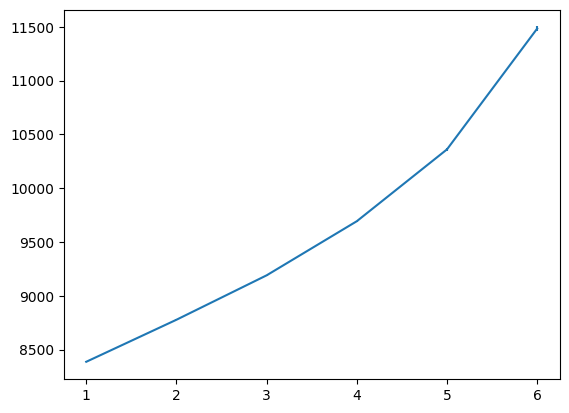

In [9]:
overexpression = numpy.array(overexpression)
ep_concat = pandas.concat(edges, axis=0).fillna(0)  # Dimensions not existing in a neighborhood would be listed as NaN. We use 0 instead.

result_mn = ep_concat.groupby("max_dim")["total_size"].mean()
result_sem = ep_concat.groupby("max_dim")["total_size"].apply(lambda _x: _x.std() / numpy.sqrt(len(_x)))

plt.errorbar(result_mn.index, result_mn.values, yerr=result_sem.values)

For a more detailed view, we want to plot edge participation against total size, in all dimensions.
To that end, we generate binned versions of the edge participation values.

In each dimension, we group the values into 21 linearly spaced bins between 0 and the 98th percentile. Plus one additional bin that holds everything above the 98th percentile. This percentile-based strategy was chosen because the edge participation values are long-tailed with some very severe outlying values.

In [10]:
perc_co = 98  # Percentile value to use to determine bins
nbins = 21  # Number of linearly spaced bins

bin_cols = []
raw_cols = []
dim_bins = {}

for dim in range(2, max_dim + 1):  # Edge participation at dimension 0 is always 0; at 1 is always 1. So we start at 2.
    # Names of DataFrame columns to use
    column_in = "edge_particip_dim_{0}".format(dim)
    column_binned = "dim_{0}_bin".format(dim)
    # Look up raw values
    x = ep_concat[column_in]

    # Linearly spaced bins (between 0 and 98th percentile)
    bins = numpy.hstack([0, numpy.linspace(0.1, numpy.percentile(x, perc_co), nbins)])
    # Digitize to get bin numbers. value "nbins" will be automatically associated with anything above the 98th percentile
    xb = numpy.digitize(x.values, bins=bins) - 1
    # Centers of the bins for plotting purposes. For the "above 98th percentile" bin we use the mean of all contained values.
    bins_centers = numpy.hstack([0, 0.5 * (bins[1:-1] + bins[2:]), numpy.mean(x[xb == nbins])])
    dim_bins[column_binned] = bins_centers # Save bin centers
    ep_concat[column_binned] = xb # Save values

    # List of column names to loop over when plotting.
    bin_cols.append(column_binned)
    raw_cols.append(column_in)


### Plotting the results

Using a normalized, linear x-axis.

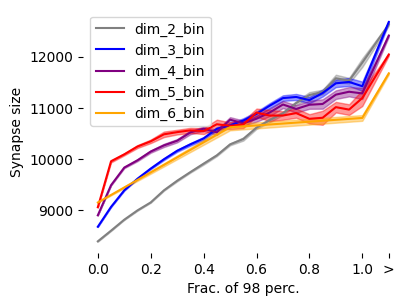

In [11]:
cols = ["grey", "blue", "purple", "red", "orange", "green"]
prop = "total_size"

fig = plt.figure(figsize=(4, 4.5))
ax = fig.add_axes([0.1, 0.4, 0.8, 0.54])

patches = []
for col, c in zip(bin_cols, cols):
    res = ep_concat.groupby(col)[prop].mean()
    res_sd = ep_concat.groupby(col)[prop].std() / numpy.sqrt(ep_concat.groupby(col)[prop].count())
    
    x = numpy.hstack([numpy.linspace(0, 1, len(res) - 1), 1.1])
    coords = numpy.vstack([numpy.hstack([x, x[::-1]]),
                           numpy.hstack([res.values - res_sd.values, res.values[::-1] + res_sd.values[::-1]])])
    polygon = Polygon(coords.transpose())
    ax.add_collection(PatchCollection([polygon], alpha=0.4, color=c))
    ax.plot(x, res, label=col, color=c)

ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.1])
ax.set_xticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0", ">"])
ax.set_ylabel("Synapse size")
ax.set_frame_on(False)
ax.set_xlabel("Frac. of {0} perc.".format(perc_co))
plt.legend()

Using a logarithmic, non-normalized axis

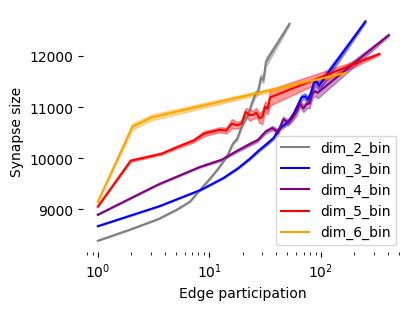

In [12]:
cols = ["grey", "blue", "purple", "red", "orange", "green"]
prop = "total_size"

fig = plt.figure(figsize=(4, 4.5))
ax = fig.add_axes([0.1, 0.4, 0.8, 0.54])

patches = []
for col, c in zip(bin_cols, cols):
    res = ep_concat.groupby(col)[prop].mean()
    res_sd = ep_concat.groupby(col)[prop].std() / numpy.sqrt(ep_concat.groupby(col)[prop].count())
    x = dim_bins[col][res.index] + 1

    coords = numpy.vstack([numpy.hstack([x, x[::-1]]),
                           numpy.hstack([res.values - res_sd.values, res.values[::-1] + res_sd.values[::-1]])])
    polygon = Polygon(coords.transpose())
    ax.add_collection(PatchCollection([polygon], alpha=0.4, color=c))
    ax.plot(x, res, label=col, color=c)

ax.set_xlabel("Edge participation")
ax.set_ylabel("Synapse size")
ax.set_frame_on(False)
plt.legend()
ax.set_xscale("log")

Above we pooled all edges of all neighborhoods.
Here, we attempt to characterize the strength of the observed effect for each individual neighborhood.
As a measure, we contrast the mean total size of the edges with the lowest edge participation in a dimension (25th percentile or lower) with the edges with the highest edge participation (above 75th percentile).

Then we can correlate it with the neuron type of the center neuron, or the amount of connectivity overexpression.


In [18]:
def ep_effect_per_dimension(E, perc_cutoff=(25, 75)):
    use_cols = E.columns.intersection(raw_cols)
    is_low_ep = E[use_cols].apply(lambda _x: _x <= numpy.percentile(_x, perc_cutoff[0]), axis=0)
    is_high_ep = E[use_cols].apply(lambda _x: _x > numpy.percentile(_x, perc_cutoff[1]), axis=0)
    ttl_sz = E["total_size"]
    
    return pandas.Series([michaelson(ttl_sz[is_high_ep[_col]].mean(),
                                     ttl_sz[is_low_ep[_col]].mean())
                          for _col in use_cols],
                          index=use_cols)

res = pandas.concat([ep_effect_per_dimension(_E) for _E in tqdm.tqdm(edges)], axis=1).transpose()
res = pandas.concat([res, smpl_nrn_df.reset_index(drop=True)["cell_type"]], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 443.21it/s]


/tmp/ipykernel_933059/1728639948.py:16: RuntimeWarning: Mean of empty slice
  numpy.nanmean(_res[dim_col]),


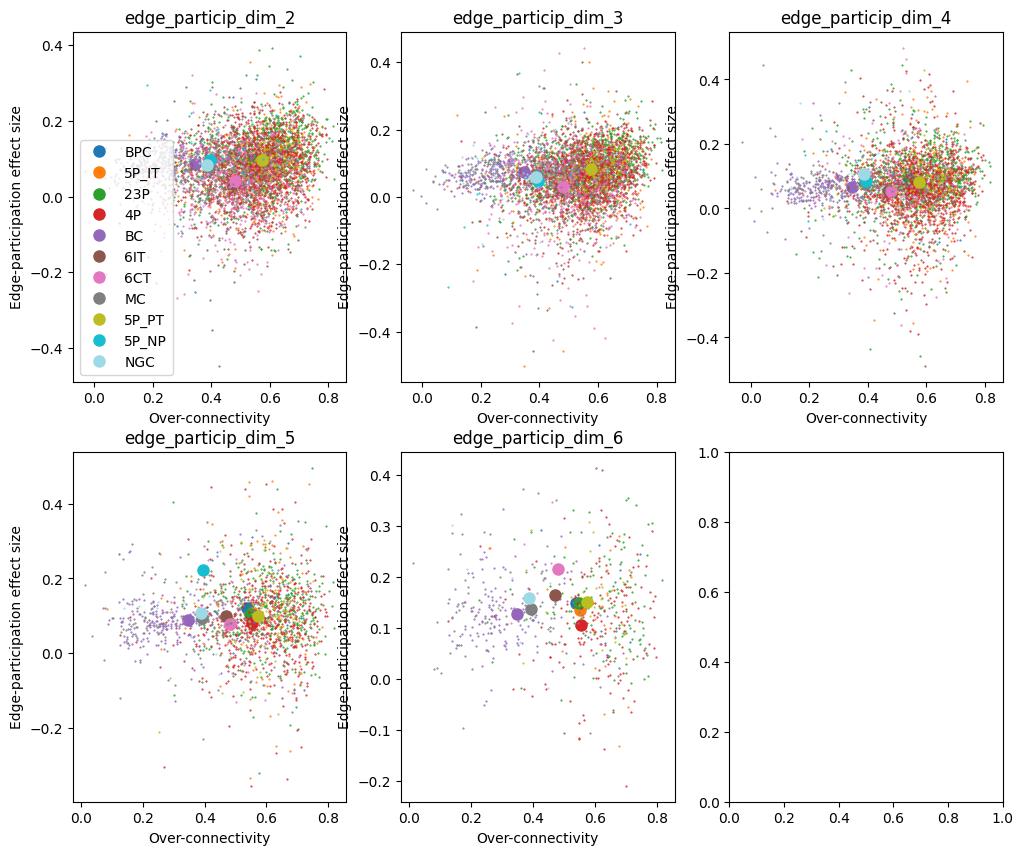

In [20]:
fig = plt.figure(figsize=(12, 10))
axes = fig.subplots(2, 3).reshape(-1)
u_cell_types = res["cell_type"].drop_duplicates().values
cols = plt.cm.tab20(numpy.linspace(0, 1, len(u_cell_types)))

for cell_type, c in zip(u_cell_types, cols):
    _idx = res["cell_type"] == cell_type
    _res = res.loc[_idx]
    _over = overexpression[_idx]
    for ax_i, dim_col in enumerate(raw_cols):
        ax = axes[ax_i]
        ax.set_title(dim_col)
        ax.plot(_over, _res[dim_col], '.',
                 ms=1, color=c)
        ax.plot(numpy.nanmean(_over),
                numpy.nanmean(_res[dim_col]),
                'o', ms=8, color=c, label=cell_type)
        ax.set_xlabel("Over-connectivity")
        ax.set_ylabel("Edge-participation effect size")
axes[0].legend()



[Text(0, 0, 'edge_particip_dim_2'),
 Text(1, 0, 'edge_particip_dim_3'),
 Text(2, 0, 'edge_particip_dim_4'),
 Text(3, 0, 'edge_particip_dim_5'),
 Text(4, 0, 'edge_particip_dim_6')]

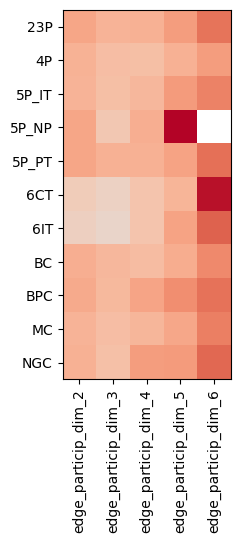

In [21]:
mn_per_cell_type = res.groupby("cell_type")[raw_cols].mean()
plt.imshow(mn_per_cell_type, clim=[-mn_per_cell_type.max(axis=None), mn_per_cell_type.max(axis=None)], cmap="coolwarm")
plt.gca().set_yticks(range(len(mn_per_cell_type))); plt.gca().set_yticklabels(mn_per_cell_type.index)
plt.gca().set_xticks(range(mn_per_cell_type.shape[1])); plt.gca().set_xticklabels(mn_per_cell_type.columns, rotation="vertical")

We see that different cell types mostly lead to different values of over-connectivity.
The edge participation effect seems less impacted or not at all.

However, the strength of the effect clearly increases with dimension considered!